In [1]:
%load_ext autoreload
%autoreload 2

import gc
import os
import pickle
from collections import Counter

import numpy
import pandas
from keras.models import load_model
from keras import Input, Model
from keras.layers import Lambda, subtract
from sklearn.externals import joblib

from hwgen.common import get_meta_data, get_all_assignments, get_all_attempts, get_student_list, make_gb_question_map
from hwgen.deep.ttb_evaluate import evaluate3, class_evaluation, evaluate_by_bucket
from hwgen.deep.ttb_scorecards import create_student_scorecards
from hwgen.deep.ttb_utils import build_SXUA, train_deep_model, create_assignment_summary, \
    augment_data, build_start_dates
from hwgen.profiler import get_attempts_from_db

from importlib import reload
from matplotlib import pyplot as plt

import math

print("started")

use_saved = True
do_train = True
do_testing = True
create_scorecards = True

base = "../../../isaac_data_files/"

Using TensorFlow backend.
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


started


In [2]:
USE_CACHED_ASSGTS = True
SAVE_CACHED_ASSGTS = True
cache_fname = base + "cached_assgts.csv"
if USE_CACHED_ASSGTS:
    print("using cached assets")
    ass_summ = pandas.read_csv(base + "ass_summ.csv")
    ass_summ.loc[:, "creation_date"] = pandas.to_datetime(ass_summ["creation_date"]).dt.floor("D")
else:
    print("not using cached assets ... creating...")
    ass = get_all_assignments()
    #ass = filter_assignments(ass, book_only=False)
    ass_summ = create_assignment_summary(ass)
    if SAVE_CACHED_ASSGTS:
        ass.to_csv(cache_fname)
        ass_summ.to_csv(base + "ass_summ.csv")
        
print(ass_summ.shape)

using cached assets
(29158, 10)


In [3]:
#     import math
#     ss = set()
#     passes = []
#     for aix in ass_summ.index:
#         ss.update(eval(ass_summ.loc[aix,"students"]))
#         # hxz = [h for h in eval(ass_summ.loc[aix,"hexes"]) if (h.startswith("ch_") or h.startswith("ch-i"))]
#         # ass_summ.loc[aix, "hexes"] = str(hxz)

#     for s in list(ss)[0:2000]:
# #         print("...",s)
#         attz = get_attempts_from_db(s)
#         if len(attz)==0:
#             continue
# #         print(passes)
#         for qid in attz["question_id"].unique():
#             qid_attz = attz[attz["question_id"] == qid].correct
#             ct = qid_attz.count()
#             sm = qid_attz.sum()
#             if math.isnan(ct) or math.isnan(sm):
#                 continue
#             passes.append(sm/ct)
    

In [4]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [5]:
from keras import constraints
class BigTable(Layer):

    def __init__(self, _dim, min_w, max_w, **kwargs):
        self.dim = _dim
        self.hilo = kwargs["init_hilo"]
        kwargs.pop('init_hilo', None)
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
#         initialiser = initializers.RandomUniform(av_w*0.99, av_w*1.01)  #.RandomUniform(min_w, max_w)
        if self.hilo:
            if self.hilo=="hi":
                initialiser = initializers.RandomUniform(max_w*.9, max_w)
            elif self.hilo=="lo":
                initialiser = initializers.RandomUniform(min_w, min_w*1.1)
            elif self.hilo=="av":
                av_w = (min_w + max_w)/2.0
                initialiser = initializers.RandomUniform(av_w*0.9, av_w*1.1)
            elif self.hilo is int:
                w = self.hilo
                initialiser = initializers.RandomUniform(av_w*0.9, av_w*1.1)
            
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [2]:
def generate_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)    
    psi_row = psi_table(psi_sel)

    qn_row = Lambda(lambda q: K.clip(q,1,math.inf))(qn_row)
    psi_row = Lambda(lambda s: K.clip(s,1,math.inf))(psi_row)
    
    q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
    s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)

#     qn_row = Lambda(lambda q: K.clip(q,1,math.inf))(qn_row)
#     psi_row = Lambda(lambda s: K.clip(s,1,math.inf))(psi_row)
    
    comps = subtract([psi_row, qn_row])
#     print("dif",dif.shape)
#     comps = Lambda(lambda ps_q: (14*ps_q[0]*ps_q[1]) + 14*(1.0-ps_q[1]) -7 ) ([psi_row, qn_row])
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid1")(comps)
#     comps = Lambda(lambda ps_q: (14*ps_q[0]*ps_q[1]) + 14*(1.0-ps_q[1]) -7 ) ([psi_row, qn_row])
    Prs = Lambda(lambda ps_q: ps_q[2]*ps_q[0]*ps_q[1] + (1-ps_q[1])) ([s_masque, q_masque, Prs])
#     Prs = Lambda(lambda ps_q: ps_q[2]*ps_q[0]*ps_q[1] + (1.0-ps_q[1]) ) ([s_masque, q_masque, Prs])

#     #MULTI LAYER SIGMOID LOGIC
#     notqc = Lambda(lambda q: 20.0*q -10.0)(qn_row)
#     notq = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)))(notqc)
#     comps = Lambda(lambda ps_q: 20.0*ps_q[0] + 20.0*ps_q[1] -10.0 )([notq, psi_row])
#     Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid2")(comps)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     Pr = Lambda(lambda ps: K.min(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)

    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

In [7]:
def generate_binary_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)    
    psi_row = psi_table(psi_sel)

    q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
    s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)

    comps = Lambda(lambda ps_q: (14*ps_q[0]*ps_q[1]) + 14*(1.0-ps_q[1]) -7 ) ([q_masque, s_masque])
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="Pr_sigmoid1")(comps)
    Pr = Lambda(lambda ps: K.min(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)

    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

In [8]:
load_from_file = True

if load_from_file:
    attz_all = pandas.read_csv("attz_all.csv")
else:
    attz = get_all_attempts()
    attz["date"] = attz.timestamp.dt.date
#     d_hist_data = {}
#     qids_seen = set()
#     uids_seen = set()
#     uids_counter = Counter()
#     book_qids = set()
#     uids_across_days = []
    print("copying..")
    attz_all = attz.copy()
    print("copied, saving..")
    attz_all.to_csv("attz_all.csv")
    print("saved.")
dates = attz_all.date.unique()
dates = pandas.Series(dates).sort_values()
print(type(dates))
print(len(attz_all))

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.series.Series'>
24500941


In [9]:
# print(len(uids_across_days), "effective static users")
# # print(uids_counter.most_common(100))

# for pad in sorted(uids_across_days):
#     print(pad)

In [10]:
from keras.optimizers import Adam

# last_qn_table = [0 for q in qids_seen]

dates_to_use = dates[365:730]
attz_to_use = attz_all[(attz_all["date"]>min(dates_to_use)) & (attz_all["date"]<max(dates_to_use))]
print(len(attz_to_use))
attz_to_use.fillna(0, inplace=True)

print(attz_to_use["question_id"][0:10])

attz_to_use = attz_to_use[attz_to_use.user_id.apply(lambda x: x.isnumeric())]
print(len(attz_to_use))

uids_seen = list(attz_to_use.user_id.unique())
# users_subsample = numpy.random.choice(uids_seen, size=min(100, len(uids_seen)), replace=False)
# subsample = attz_to_use[attz_to_use.user_id.isin(users_subsample)]
# subsample = attz_to_use

# qs_subsample = attz_to_use[(attz_to_use.question_id.str.startswith("ch_") | attz_to_use.question_id.str.startswith("ch-"))]
# subsample = qs_subsample #[-100000:]
# print(qs_subsample)
# print(len(qs_subsample))
qs_subsample = attz_to_use

users_subsample = numpy.random.choice(uids_seen, size=min(1000, len(uids_seen)), replace=False)
subsample = qs_subsample[qs_subsample.user_id.isin(users_subsample)]
print(len(subsample))

# subsample = attz_to_use[-100000:]
subsample.fillna(0, inplace=True)
subsample["uid_d"] = subsample["user_id"] + "_" + subsample["date"].map(str)

uids_across_days = list(numpy.sort(subsample["uid_d"].unique()))
subsample["sindex"] = subsample["uid_d"].apply(lambda x: uids_across_days.index(x))

qids_seen = list(numpy.sort(subsample["question_id"].unique()))
subsample["qindex"] = subsample["question_id"].apply(lambda x: qids_seen.index(x))

sz = subsample["sindex"]
qz = subsample["qindex"]
pfz = subsample["correct"]

from collections import defaultdict

counts=Counter()
pazzed=Counter()
for s,q,pf in zip(sz, qz, pfz):
    counts[(s,q)] += 1
    if pf:
        pazzed[(s,q)] += 1
#     print(s,q,"=>",counts[(s,q)], pazzed[(s,q)])
        
probs = defaultdict(float)
probs_list = []
unpassed = {}
unfailed = {}
qcounts = Counter()
for q in qz:
    unpassed[q]=True
    unfailed[q]=True
    qcounts[q]+=1
    
for s,q in counts:
    if pazzed[(s,q)] > 0:
        unpassed[q] = False
        p = 1.0 / (counts[(s,q)] -pazzed[(s,q)] +1)
        probs[(s,q)] = p
        probs_list.append(p)
    else:
        unfailed[q] =False
    print(s,q,"=>",probs[(s,q)])
    
print(len(sz), len(qz), len(pfz))

2979104


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


257           ch_f_p3|3dfab744-0ed3-4b8a-bf32-0d18bc30ffcb
353           ch_f_p3|f1020c1e-d80f-4066-a9de-db3b990e9d42
357           ch_f_p3|db87afb2-f240-4cc5-ae68-4cc823988a9e
1510          ch_f_p3|b5adae83-3a04-4af3-9766-4ee9aa296b8a
2062          ch_f_p3|af6c6136-ef6d-4604-9b41-d97329dbbf92
2120          ch_f_p3|f1020c1e-d80f-4066-a9de-db3b990e9d42
2605     humpback_bridge|11885e75-3939-42fc-9894-d710a7...
2608          ch_f_p3|ab2a7ff3-5043-4e97-8d53-56bd24b68052
3337          ch_f_p3|64926716-9b1c-4135-acbe-9e9827d0e7ed
15569         ch_f_p3|4f6d4391-2919-4731-87eb-db38646b89af
Name: question_id, dtype: object
2780085
153481


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

2827 819 => 0.16666666666666666
3561 456 => 1.0
2920 2458 => 1.0
3352 2178 => 0.5
3352 2180 => 1.0
3352 2179 => 0.5
3352 2181 => 1.0
3352 1396 => 0.3333333333333333
3481 342 => 1.0
3481 350 => 0.3333333333333333
3481 328 => 0.5
3481 359 => 1.0
3481 339 => 0.3333333333333333
3481 330 => 0.2
3481 351 => 0.5
3481 349 => 0.25
3481 341 => 0.2
3481 323 => 0.2
3481 327 => 0.14285714285714285
3481 358 => 1.0
3481 348 => 0.16666666666666666
3481 340 => 0.14285714285714285
3481 355 => 1.0
3481 345 => 0.2
3481 338 => 0.2
3481 325 => 0.16666666666666666
3481 356 => 0.25
3481 344 => 1.0
3481 334 => 1.0
3481 329 => 0.25
3481 352 => 0.5
3481 333 => 0.3333333333333333
3481 331 => 0.3333333333333333
3481 335 => 0.2
3072 425 => 0.5
3072 417 => 0.5
3072 418 => 1.0
3072 426 => 1.0
3072 423 => 0.5
3072 422 => 0.2
3072 424 => 1.0
3072 419 => 1.0
3072 420 => 0.0
3072 421 => 0.0
3072 437 => 0.5
3536 1697 => 1.0
5157 318 => 1.0
5157 321 => 0.3333333333333333
5157 319 => 1.0
5157 313 => 0.125
5157 311 => 1.0
51

3831 816 => 1.0
3831 812 => 1.0
3830 913 => 1.0
3831 823 => 0.5
3830 912 => 0.2
3830 905 => 1.0
3830 910 => 1.0
3831 813 => 0.2
3830 911 => 0.5
3830 906 => 1.0
3831 810 => 1.0
3831 817 => 1.0
3831 818 => 1.0
3831 820 => 1.0
3831 814 => 1.0
3831 809 => 0.5
3831 819 => 1.0
3831 824 => 1.0
3831 822 => 0.5
3831 821 => 1.0
3831 808 => 1.0
3564 1709 => 0.045454545454545456
3564 1710 => 1.0
3564 211 => 0.25
3564 210 => 1.0
3564 2482 => 1.0
3564 2483 => 1.0
3564 94 => 1.0
3564 95 => 1.0
3564 93 => 1.0
3564 1228 => 1.0
3564 1229 => 1.0
3564 1230 => 0.16666666666666666
3194 1709 => 0.07692307692307693
3194 1710 => 0.3333333333333333
3194 116 => 0.3333333333333333
3194 290 => 0.25
3194 1396 => 1.0
3194 193 => 1.0
3194 1952 => 1.0
3194 1953 => 1.0
3194 1954 => 0.2
3194 2490 => 0.5
3194 2512 => 1.0
3194 2605 => 0.2
3194 2568 => 1.0
3194 2569 => 0.1111111111111111
3194 2571 => 0.5
3194 2572 => 0.02857142857142857
3194 2573 => 1.0
3194 2125 => 1.0
3194 2127 => 1.0
3194 2128 => 1.0
3194 2126 => 1.0
31

4023 401 => 1.0
4023 406 => 1.0
4023 390 => 1.0
4023 386 => 1.0
4023 384 => 1.0
4023 392 => 1.0
4023 385 => 0.16666666666666666
4023 388 => 1.0
4023 383 => 1.0
4023 389 => 0.125
4023 391 => 1.0
4023 387 => 1.0
4023 411 => 1.0
4023 408 => 0.125
4023 409 => 0.3333333333333333
4023 407 => 0.2
4023 415 => 1.0
4023 413 => 0.16666666666666666
4023 336 => 0.5
4023 332 => 1.0
3073 536 => 1.0
4023 353 => 1.0
4023 343 => 1.0
4023 342 => 1.0
4023 350 => 1.0
4023 328 => 1.0
3073 534 => 1.0
4023 359 => 1.0
4023 339 => 1.0
4023 330 => 1.0
4023 351 => 1.0
4023 349 => 1.0
4023 341 => 0.3333333333333333
3073 542 => 0.0
4023 327 => 0.09090909090909091
4023 348 => 0.5
4023 358 => 1.0
4023 340 => 0.25
4023 323 => 0.125
4023 355 => 0.25
4023 345 => 0.16666666666666666
3073 539 => 0.0
4023 338 => 0.25
4023 325 => 0.5
3073 541 => 0.0
4023 356 => 1.0
4023 344 => 1.0
4023 335 => 1.0
4023 324 => 0.5
4023 357 => 1.0
4023 347 => 0.5
4023 337 => 0.5
4023 326 => 1.0
4023 354 => 1.0
4023 346 => 1.0
3531 522 => 1.0
3

4119 361 => 1.0
4058 868 => 1.0
4119 366 => 1.0
4119 368 => 0.5
4058 866 => 1.0
4119 369 => 1.0
4058 865 => 1.0
4119 363 => 0.3333333333333333
4058 869 => 1.0
3725 382 => 0.16666666666666666
4119 365 => 1.0
4119 364 => 1.0
4119 370 => 1.0
4119 360 => 1.0
4058 870 => 0.14285714285714285
4114 1134 => 0.3333333333333333
4068 290 => 0.5
4068 1396 => 0.2
4114 1132 => 0.14285714285714285
4068 1192 => 0.3333333333333333
4058 871 => 0.3333333333333333
4068 1193 => 0.25
4068 1697 => 0.16666666666666666
3725 378 => 1.0
3725 375 => 1.0
3725 377 => 1.0
3725 373 => 0.14285714285714285
4068 144 => 0.1111111111111111
4058 1034 => 0.2
3725 379 => 0.5
3725 374 => 0.125
3725 372 => 0.5
3725 380 => 0.025
4114 2320 => 1.0
4068 1706 => 0.5
4325 862 => 1.0
4068 2605 => 0.2
4068 1560 => 0.2
4325 866 => 1.0
4325 865 => 1.0
4325 869 => 1.0
4325 867 => 0.3333333333333333
4325 864 => 1.0
4325 863 => 1.0
4325 868 => 1.0
4068 143 => 0.16666666666666666
3725 376 => 0.2
4114 1133 => 0.5
4068 142 => 0.166666666666666

3093 382 => 0.3333333333333333
3093 375 => 0.5
4201 1030 => 0.5
3093 377 => 1.0
3093 373 => 1.0
4201 1043 => 1.0
3093 379 => 1.0
3093 374 => 1.0
3093 372 => 1.0
4201 1041 => 0.25
3093 380 => 1.0
3093 376 => 0.3333333333333333
3093 381 => 1.0
4201 1035 => 0.0
4201 1029 => 0.0
4133 290 => 0.5
4133 2482 => 1.0
4133 2483 => 1.0
4133 2512 => 1.0
4133 211 => 1.0
4133 210 => 0.5
4133 2075 => 0.25
4133 1929 => 1.0
4133 2178 => 0.16666666666666666
4133 2180 => 0.0
3331 2625 => 1.0
3331 2626 => 1.0
3331 2627 => 1.0
3169 1058 => 1.0
3169 1063 => 1.0
3169 1061 => 1.0
3169 1054 => 1.0
4235 361 => 1.0
4235 366 => 1.0
4235 368 => 1.0
4235 369 => 0.5
4235 363 => 0.16666666666666666
4235 365 => 1.0
4235 364 => 1.0
4235 370 => 1.0
4235 360 => 1.0
4235 362 => 0.3333333333333333
4235 367 => 1.0
4235 371 => 1.0
2869 241 => 0.3333333333333333
4028 794 => 1.0
4255 794 => 1.0
4255 792 => 1.0
4255 791 => 1.0
4028 792 => 0.034482758620689655
4255 793 => 1.0
2869 242 => 1.0
4255 789 => 0.5
4255 795 => 0.5
2869 2

4291 1062 => 0.5
4339 336 => 0.0
4160 377 => 0.5
4291 1046 => 1.0
4291 1049 => 1.0
4291 1048 => 1.0
4309 2206 => 0.25
4160 373 => 1.0
4160 376 => 1.0
4160 381 => 0.0
4309 2204 => 0.0
1995 1922 => 1.0
4291 870 => 0.5
4291 871 => 1.0
4291 872 => 1.0
1995 994 => 0.5
1995 992 => 0.0
4291 876 => 0.2
3574 1906 => 1.0
3574 1192 => 0.0
4291 873 => 1.0
4291 874 => 1.0
3574 318 => 1.0
4291 879 => 1.0
4291 875 => 0.5
3574 321 => 1.0
3574 319 => 0.3333333333333333
4291 877 => 1.0
4291 878 => 0.5
3574 313 => 0.0
3354 318 => 1.0
3354 321 => 1.0
3354 317 => 0.5
3354 319 => 1.0
3354 313 => 1.0
3354 316 => 1.0
3354 311 => 1.0
3354 315 => 1.0
3354 320 => 1.0
3354 314 => 0.5
3354 322 => 1.0
3354 312 => 1.0
3575 313 => 1.0
3575 316 => 1.0
3575 311 => 1.0
3575 317 => 0.5
3853 380 => 1.0
3575 315 => 1.0
3575 320 => 1.0
3575 314 => 0.0
3853 381 => 0.2
3853 379 => 0.25
4286 382 => 1.0
4286 378 => 1.0
4286 375 => 1.0
3853 376 => 0.5
4286 377 => 1.0
4286 373 => 0.5
4286 379 => 0.5
3575 322 => 0.0
4286 374 => 0.

4569 366 => 1.0
4542 360 => 1.0
4542 367 => 0.0
3150 361 => 1.0
3150 366 => 1.0
3150 368 => 1.0
3150 369 => 1.0
3150 363 => 1.0
3150 365 => 1.0
3150 364 => 1.0
3150 370 => 0.0
3150 360 => 1.0
3150 362 => 0.0
3150 367 => 1.0
3150 371 => 1.0
3150 382 => 1.0
3150 378 => 1.0
3150 375 => 1.0
3150 377 => 0.5
3150 373 => 0.3333333333333333
3150 379 => 1.0
3150 374 => 1.0
3150 380 => 0.0
3150 372 => 1.0
3150 376 => 1.0
3150 381 => 1.0
4606 751 => 1.0
4606 746 => 0.3333333333333333
4606 747 => 0.3333333333333333
4606 742 => 0.5
4606 740 => 1.0
4606 754 => 0.5
50 1678 => 0.5
4606 755 => 0.3333333333333333
4606 741 => 0.5
4606 750 => 1.0
4606 749 => 0.3333333333333333
4606 752 => 1.0
4606 748 => 1.0
4606 743 => 0.0
4606 739 => 0.5
4606 745 => 0.3333333333333333
4606 753 => 1.0
4606 744 => 0.3333333333333333
4606 756 => 0.0
4606 761 => 0.5
4606 765 => 1.0
4606 764 => 0.0
4606 766 => 1.0
4606 772 => 0.5
4606 774 => 1.0
4606 780 => 1.0
4606 786 => 0.5
4606 781 => 0.5
4606 782 => 1.0
4606 778 => 0.33

4755 304 => 1.0
3789 1014 => 1.0
4755 307 => 0.5
4755 305 => 1.0
3789 1002 => 0.14285714285714285
4755 310 => 0.5
4755 301 => 1.0
4755 302 => 1.0
3629 2178 => 1.0
3629 2180 => 0.5
4755 300 => 0.5
3789 1008 => 1.0
4755 309 => 1.0
3789 996 => 1.0
3629 2179 => 1.0
3629 2181 => 1.0
4755 994 => 0.5
4755 992 => 1.0
4755 990 => 0.5
4755 987 => 0.3333333333333333
4755 991 => 0.5
4755 993 => 0.5
4755 986 => 1.0
4755 988 => 0.5
4755 989 => 0.16666666666666666
3629 2248 => 1.0
3629 2249 => 1.0
4755 995 => 1.0
3629 437 => 1.0
3629 436 => 1.0
3629 432 => 1.0
3629 434 => 1.0
3629 433 => 1.0
3629 431 => 0.5
3629 430 => 1.0
3629 427 => 0.14285714285714285
3629 435 => 0.0
3629 429 => 1.0
3629 428 => 0.5
3629 438 => 1.0
3629 1573 => 0.3333333333333333
3629 1572 => 0.3333333333333333
3629 2219 => 0.25
4543 362 => 0.2
4543 367 => 1.0
4543 371 => 1.0
3629 2220 => 0.5
3629 2217 => 0.0
3629 1333 => 0.2
4380 2248 => 0.3333333333333333
4763 290 => 1.0
4763 1929 => 1.0
4763 2103 => 1.0
4763 2102 => 1.0
4380 224

4039 393 => 1.0
3176 337 => 0.5
3176 354 => 0.5
3176 326 => 0.16666666666666666
4039 394 => 1.0
4039 402 => 1.0
4039 398 => 1.0
3176 346 => 0.2
4039 397 => 1.0
3176 334 => 1.0
4039 395 => 1.0
3176 329 => 0.3333333333333333
4039 399 => 0.5
4039 404 => 1.0
3176 352 => 0.25
4039 405 => 1.0
4039 396 => 1.0
3176 333 => 0.3333333333333333
4039 403 => 1.0
3176 331 => 1.0
4039 400 => 1.0
4039 401 => 1.0
4039 406 => 1.0
4029 800 => 0.25
3176 2573 => 1.0
4029 805 => 0.5
3176 1650 => 1.0
3176 2027 => 0.3333333333333333
4029 804 => 0.5
3176 2026 => 0.2
4029 797 => 1.0
4029 801 => 1.0
4029 798 => 0.08333333333333333
4029 806 => 1.0
3176 189 => 0.0
4029 159 => 0.5
4029 1876 => 0.0
3176 2643 => 0.0
4029 791 => 0.5
4029 793 => 0.0
4264 427 => 0.1
3576 336 => 0.14285714285714285
4029 2574 => 0.5
3576 332 => 0.3333333333333333
3576 353 => 1.0
3576 343 => 1.0
3576 342 => 1.0
3576 350 => 1.0
3576 328 => 1.0
3576 359 => 1.0
3576 339 => 1.0
3576 330 => 1.0
3576 351 => 1.0
3576 349 => 1.0
3210 361 => 1.0
357

4897 859 => 1.0
3304 1850 => 1.0
4289 2376 => 1.0
3158 995 => 0.3333333333333333
4897 852 => 1.0
4897 854 => 1.0
4289 1652 => 0.0
4385 425 => 0.5
4897 855 => 0.5
4289 219 => 0.3333333333333333
4289 1391 => 0.0
4289 1561 => 0.2
4510 427 => 1.0
4510 435 => 1.0
4510 429 => 0.2
4510 428 => 1.0
4510 438 => 0.0
4289 1190 => 0.0
4256 159 => 1.0
4289 2138 => 0.05
3878 425 => 0.5
3933 425 => 1.0
3933 417 => 0.3333333333333333
3878 417 => 0.5
3933 418 => 1.0
3878 418 => 1.0
3878 426 => 1.0
3933 426 => 1.0
3933 423 => 0.5
4289 1962 => 0.0
4061 1029 => 1.0
3878 423 => 1.0
4898 290 => 0.5
3878 422 => 1.0
3878 424 => 0.25
4256 1876 => 1.0
3933 422 => 1.0
4614 425 => 0.2
3933 424 => 1.0
3906 425 => 1.0
3906 417 => 1.0
3906 418 => 1.0
3906 426 => 1.0
3906 423 => 1.0
3878 419 => 0.5
4544 382 => 1.0
4614 417 => 0.5
4544 378 => 1.0
4570 382 => 0.5
3933 419 => 1.0
4289 1310 => 0.2
4544 375 => 1.0
4544 377 => 0.5
4614 418 => 1.0
4544 373 => 1.0
4570 378 => 1.0
4544 379 => 0.047619047619047616
3906 422 => 1

5041 311 => 1.0
5041 317 => 1.0
5041 315 => 1.0
5041 320 => 0.5
5031 1978 => 0.5
5041 314 => 1.0
5041 322 => 1.0
5041 312 => 1.0
5041 361 => 1.0
5041 366 => 1.0
5041 368 => 1.0
5041 369 => 1.0
5041 363 => 0.3333333333333333
5031 2101 => 1.0
5041 360 => 1.0
5041 362 => 0.5
5041 367 => 1.0
5041 365 => 1.0
5031 1686 => 1.0
5041 364 => 1.0
5041 370 => 1.0
5031 1973 => 0.5
5041 371 => 1.0
5031 228 => 1.0
5031 2278 => 1.0
5031 2524 => 1.0
5031 2404 => 1.0
5031 2405 => 1.0
5031 189 => 1.0
5031 188 => 1.0
5031 1678 => 1.0
5031 1679 => 1.0
5031 1677 => 1.0
5031 1676 => 1.0
5031 2534 => 1.0
5031 1697 => 1.0
5031 1929 => 1.0
5031 1866 => 0.5
5031 1691 => 1.0
5031 2659 => 1.0
5031 2075 => 0.5
5031 1952 => 0.5
5031 1953 => 1.0
5031 1954 => 0.5
5049 2605 => 1.0
4788 318 => 1.0
4788 321 => 1.0
4788 319 => 1.0
4788 313 => 1.0
4788 316 => 1.0
4788 311 => 1.0
4788 317 => 0.5
4788 315 => 1.0
4788 320 => 0.5
4788 314 => 0.25
4788 322 => 0.16666666666666666
4429 425 => 1.0
4788 312 => 0.3333333333333333
44

3726 758 => 1.0
5061 777 => 0.05263157894736842
3726 766 => 1.0
3726 762 => 0.1
3726 775 => 1.0
3726 769 => 1.0
3726 768 => 0.5
3726 777 => 0.5
113 331 => 1.0
3726 770 => 0.0
5061 770 => 0.5
5061 772 => 0.5
3726 772 => 1.0
3726 774 => 0.3333333333333333
5061 774 => 0.5
5061 773 => 0.5
5061 771 => 0.047619047619047616
4813 1611 => 1.0
4813 1612 => 0.5
4813 1610 => 1.0
5119 142 => 1.0
5119 147 => 1.0
5119 144 => 1.0
5119 143 => 1.0
5061 776 => 0.0
5119 146 => 1.0
5119 141 => 1.0
5119 145 => 1.0
5119 1709 => 0.5
5119 1710 => 1.0
5061 779 => 0.5
5119 2490 => 1.0
5061 780 => 1.0
5061 786 => 1.0
5119 2482 => 1.0
5061 781 => 1.0
5080 2534 => 0.25
5079 2534 => 0.5
5061 782 => 1.0
5119 2483 => 1.0
5088 425 => 1.0
5088 417 => 0.5
5119 290 => 1.0
5061 778 => 1.0
5088 418 => 1.0
5061 783 => 0.5
5088 426 => 1.0
5061 785 => 0.5
5119 2427 => 1.0
5061 784 => 0.5
5088 423 => 0.043478260869565216
5119 2424 => 0.5
5080 1396 => 0.5
5119 2426 => 0.2
5079 1396 => 1.0
5080 1929 => 0.2
5080 1697 => 0.25
5088 

4814 1479 => 1.0
4814 1469 => 1.0
4814 1461 => 1.0
4838 2178 => 1.0
4814 1481 => 1.0
4814 1470 => 1.0
4838 2180 => 1.0
4838 2179 => 0.3333333333333333
4814 1462 => 0.5
4838 2181 => 0.2
4814 1482 => 1.0
3080 299 => 0.0
4814 1471 => 1.0
4814 1463 => 1.0
4814 1483 => 1.0
4814 1472 => 1.0
4814 1464 => 1.0
4814 1484 => 1.0
4814 1474 => 0.5
4814 1492 => 1.0
4814 1500 => 1.0
4814 1506 => 0.2
4814 1491 => 0.5
4814 1490 => 0.5
4814 1501 => 1.0
4814 1495 => 1.0
4814 1507 => 0.25
4814 1496 => 1.0
4814 1497 => 0.3333333333333333
4814 1503 => 0.5
4814 1487 => 0.5
4814 1493 => 1.0
4814 1488 => 1.0
4814 1498 => 1.0
4814 1504 => 1.0
4814 1489 => 1.0
4814 1494 => 0.5
4814 1499 => 1.0
4814 1505 => 1.0
4814 1502 => 1.0
4814 1511 => 1.0
4814 1516 => 1.0
4814 1522 => 1.0
4814 1518 => 1.0
4814 1508 => 1.0
4814 1520 => 1.0
4814 1513 => 1.0
4814 1519 => 1.0
4814 1525 => 1.0
4814 1510 => 1.0
4814 1517 => 1.0
4814 1523 => 1.0
4881 438 => 0.05263157894736842
4881 2605 => 0.5
0 1697 => 1.0
0 2399 => 1.0
0 1678 =>

4781 328 => 1.0
4781 359 => 1.0
4573 420 => 0.0
4781 339 => 1.0
4781 330 => 1.0
4781 351 => 1.0
4781 349 => 1.0
4781 341 => 1.0
4781 327 => 1.0
4781 358 => 1.0
4781 348 => 1.0
4781 340 => 1.0
4781 323 => 1.0
4781 355 => 1.0
4781 345 => 1.0
4781 338 => 1.0
4781 325 => 1.0
4781 356 => 1.0
4781 344 => 1.0
4781 347 => 1.0
4781 335 => 1.0
4781 324 => 1.0
4781 357 => 1.0
4781 337 => 1.0
4781 326 => 1.0
4781 354 => 1.0
4781 346 => 1.0
4781 334 => 1.0
4781 352 => 0.5
4781 329 => 1.0
4781 333 => 0.5
4781 331 => 0.3333333333333333
772 860 => 1.0
772 859 => 0.5
772 852 => 1.0
4030 793 => 0.14285714285714285
4030 789 => 0.3333333333333333
2827 824 => 0.0
4030 795 => 0.5
4030 790 => 1.0
4030 787 => 1.0
4030 788 => 0.14285714285714285
4030 796 => 1.0
4030 825 => 1.0
4030 822 => 1.0
4030 826 => 0.5
4030 821 => 0.125
4030 808 => 0.09090909090909091
4030 815 => 1.0
4030 811 => 0.3333333333333333
4030 807 => 0.5
4030 823 => 1.0
4030 812 => 1.0
4030 816 => 1.0
4030 813 => 0.5
4030 810 => 0.5
4030 817 => 

4884 342 => 1.0
284 448 => 0.5
4884 350 => 1.0
4884 328 => 1.0
284 445 => 0.25
284 444 => 0.5
284 441 => 1.0
284 442 => 1.0
284 449 => 1.0
284 447 => 1.0
138 553 => 0.5
284 437 => 0.5
284 436 => 1.0
284 432 => 1.0
284 434 => 1.0
284 433 => 0.0
4937 794 => 0.5
138 551 => 1.0
4937 792 => 1.0
4911 794 => 1.0
4911 792 => 1.0
4937 791 => 1.0
4911 791 => 1.0
4937 793 => 0.14285714285714285
4911 793 => 0.1111111111111111
4909 794 => 1.0
4909 792 => 1.0
4909 791 => 1.0
4911 789 => 0.2
4909 793 => 0.3333333333333333
4911 795 => 1.0
4937 789 => 1.0
4911 790 => 1.0
4911 787 => 1.0
4937 795 => 1.0
4911 788 => 1.0
4911 796 => 1.0
138 547 => 0.3333333333333333
4911 411 => 1.0
4911 408 => 0.5
4937 790 => 1.0
58 211 => 1.0
4911 409 => 1.0
4911 407 => 0.2
4937 787 => 0.3333333333333333
138 550 => 0.0
4909 789 => 1.0
4909 795 => 1.0
4909 790 => 1.0
4911 410 => 0.5
4937 788 => 0.14285714285714285
4909 787 => 1.0
4909 788 => 0.5
4909 796 => 1.0
4909 411 => 0.5
4909 408 => 0.5
4909 409 => 1.0
4909 407 => 1

3782 446 => 0.16666666666666666
4820 638 => 0.3333333333333333
4820 646 => 0.5
4820 640 => 1.0
4820 639 => 0.5
4820 648 => 0.5
4820 636 => 1.0
4820 650 => 0.5
4820 652 => 1.0
4820 635 => 0.5
4820 634 => 1.0
4820 642 => 1.0
4820 637 => 1.0
3782 439 => 1.0
4820 651 => 0.2
4820 653 => 1.0
4820 645 => 1.0
4820 644 => 0.5
3782 449 => 1.0
3782 447 => 1.0
3782 2490 => 0.5
177 1929 => 0.5
4607 756 => 1.0
4607 767 => 1.0
4607 763 => 1.0
4607 759 => 1.0
4607 757 => 1.0
4607 764 => 1.0
4607 760 => 0.5
4607 762 => 1.0
177 1697 => 1.0
177 2534 => 0.5
5082 2659 => 0.25
177 1691 => 0.2
177 2659 => 0.5
177 2278 => 0.3333333333333333
4617 478 => 0.5
5075 756 => 0.1
5075 767 => 1.0
5075 763 => 0.09090909090909091
177 1866 => 0.5
4617 471 => 0.14285714285714285
3908 469 => 1.0
5075 759 => 0.3333333333333333
5075 757 => 0.5
5075 761 => 1.0
5075 765 => 1.0
177 1952 => 1.0
177 1953 => 0.14285714285714285
5075 764 => 0.0
3936 475 => 0.5
3936 478 => 1.0
3908 476 => 0.16666666666666666
5075 760 => 1.0
3936 471

3757 1451 => 1.0
3757 1445 => 1.0
3757 1455 => 1.0
3757 1450 => 1.0
3757 1444 => 1.0
3757 1454 => 1.0
3757 1449 => 1.0
3757 1443 => 1.0
3757 1448 => 1.0
3757 1453 => 1.0
3757 1442 => 1.0
4011 347 => 0.3333333333333333
4011 357 => 0.5
4011 324 => 0.25
4011 335 => 0.5
3757 1452 => 0.3333333333333333
3757 1447 => 1.0
3757 1457 => 1.0
3757 1480 => 1.0
3757 1473 => 1.0
3757 1465 => 1.0
3757 1485 => 1.0
3757 1475 => 1.0
3757 1486 => 1.0
3757 1466 => 0.5
3757 1476 => 0.5
3757 1458 => 0.5
3757 1477 => 1.0
3757 1467 => 0.5
3757 1459 => 0.5
3757 1478 => 1.0
3757 1468 => 0.3333333333333333
4011 337 => 1.0
4011 326 => 1.0
4011 354 => 1.0
4011 346 => 1.0
4011 334 => 1.0
3757 1460 => 1.0
4011 329 => 1.0
3757 1479 => 1.0
4011 352 => 1.0
3757 1469 => 1.0
3757 1470 => 1.0
4011 333 => 1.0
3757 1461 => 1.0
3757 1481 => 1.0
4011 331 => 1.0
3757 1462 => 1.0
3757 1482 => 1.0
3757 1471 => 0.2
4513 548 => 0.0
3757 1463 => 1.0
3757 1483 => 1.0
3757 1472 => 1.0
4277 551 => 0.2
3757 1464 => 1.0
3757 1484 => 0.5


307 1001 => 1.0
307 1006 => 1.0
307 999 => 0.25
307 997 => 0.25
319 1952 => 1.0
319 1953 => 1.0
26 860 => 0.2
307 1010 => 0.5
26 859 => 0.5
307 1009 => 0.5
26 852 => 0.3333333333333333
26 854 => 0.25
315 793 => 0.0
315 789 => 0.0
26 853 => 0.5
26 855 => 0.0
26 861 => 1.0
26 857 => 0.0
4990 338 => 1.0
4990 342 => 1.0
4990 336 => 0.5
4990 332 => 1.0
4990 353 => 1.0
4990 343 => 1.0
4990 350 => 1.0
4990 328 => 1.0
4990 359 => 1.0
4990 339 => 1.0
4990 330 => 1.0
4990 351 => 1.0
4990 349 => 1.0
4990 341 => 1.0
4990 327 => 1.0
4990 358 => 1.0
4990 348 => 0.5
4990 340 => 1.0
4990 323 => 1.0
4990 355 => 1.0
4990 345 => 1.0
4990 325 => 1.0
4990 356 => 1.0
4990 344 => 1.0
4990 335 => 1.0
4990 324 => 1.0
4990 357 => 1.0
4990 347 => 1.0
4990 337 => 1.0
4990 326 => 1.0
4990 354 => 1.0
4990 346 => 1.0
4990 334 => 1.0
4990 329 => 1.0
4990 352 => 1.0
26 858 => 0.16666666666666666
4990 333 => 1.0
4990 331 => 0.5
26 856 => 0.3333333333333333
4124 444 => 0.0
4124 441 => 0.0
4124 442 => 0.5
4124 449 => 0.0

348 2604 => 1.0
348 2603 => 0.5
348 1690 => 1.0
348 1687 => 1.0
348 1590 => 0.5
348 1591 => 0.3333333333333333
348 1596 => 0.125
348 1593 => 0.0
348 290 => 1.0
348 2524 => 1.0
348 268 => 0.5
4886 367 => 1.0
4886 371 => 1.0
4215 558 => 0.5
4215 564 => 1.0
4886 382 => 1.0
4886 378 => 1.0
4886 375 => 1.0
348 228 => 1.0
4886 377 => 1.0
348 2456 => 0.5
4886 373 => 0.5
348 2457 => 1.0
4886 379 => 1.0
4215 565 => 1.0
4886 374 => 0.3333333333333333
4886 372 => 1.0
4886 380 => 0.1
4886 376 => 0.125
348 1703 => 0.5
348 1888 => 1.0
4886 381 => 1.0
348 1886 => 0.5
4886 440 => 0.0
348 1887 => 0.5
348 2427 => 0.5
348 2424 => 1.0
4886 1549 => 1.0
360 970 => 1.0
348 2426 => 1.0
360 961 => 1.0
4886 1548 => 1.0
348 2425 => 1.0
360 968 => 1.0
348 2490 => 1.0
360 962 => 1.0
360 960 => 0.5
360 963 => 1.0
360 969 => 0.3333333333333333
360 965 => 1.0
4886 1686 => 0.5
360 959 => 1.0
4886 1706 => 1.0
4886 1858 => 0.0
4886 385 => 0.0
4886 388 => 1.0
348 1333 => 1.0
348 1643 => 1.0
348 1644 => 1.0
348 1922 => 0.

515 742 => 0.5
515 740 => 0.5
518 862 => 1.0
4864 443 => 0.0
264 439 => 1.0
515 754 => 0.5
264 448 => 0.5
515 755 => 0.5
264 445 => 0.5
515 741 => 0.5
518 864 => 1.0
515 750 => 0.3333333333333333
518 863 => 1.0
264 444 => 1.0
518 868 => 1.0
518 866 => 1.0
515 749 => 0.5
518 865 => 1.0
515 752 => 1.0
264 441 => 1.0
518 869 => 1.0
515 748 => 0.3333333333333333
515 743 => 0.125
5033 1113 => 1.0
515 739 => 0.5
5033 2498 => 0.0
4074 361 => 1.0
4074 366 => 1.0
4074 368 => 0.5
515 745 => 1.0
4074 369 => 0.5
515 753 => 1.0
515 744 => 0.5
4074 363 => 0.5
5033 1596 => 1.0
4074 365 => 1.0
4074 364 => 0.5
4074 370 => 0.25
4074 360 => 1.0
4074 362 => 0.125
4074 367 => 1.0
4074 371 => 1.0
4074 356 => 1.0
4074 336 => 1.0
4074 332 => 1.0
4074 353 => 1.0
4074 343 => 1.0
4074 342 => 1.0
4074 350 => 1.0
4074 351 => 1.0
4074 328 => 1.0
4074 359 => 1.0
4074 339 => 1.0
4074 330 => 1.0
4074 349 => 1.0
4074 341 => 0.2
4074 327 => 0.08333333333333333
4074 354 => 0.5
5112 446 => 0.0
4074 325 => 1.0
5112 445 => 

3237 1006 => 1.0
3237 999 => 1.0
3237 997 => 1.0
3237 996 => 1.0
3237 1061 => 0.16666666666666666
3763 1053 => 1.0
3763 1044 => 1.0
4611 444 => 0.0
3763 1050 => 0.5
3763 1064 => 0.5
3237 1058 => 0.3333333333333333
4611 449 => 0.3333333333333333
3237 1054 => 0.5
3237 1063 => 0.5
5002 1590 => 0.5
3237 1056 => 0.3333333333333333
3237 1051 => 1.0
3237 1060 => 0.5
3237 1057 => 0.3333333333333333
3763 1065 => 1.0
3763 1061 => 1.0
3763 1058 => 1.0
4611 447 => 0.3333333333333333
3763 1054 => 1.0
3763 1063 => 1.0
3763 1056 => 1.0
3763 1051 => 1.0
3763 1060 => 1.0
3763 1057 => 1.0
3237 1053 => 1.0
3237 1044 => 1.0
3237 1050 => 1.0
3237 1064 => 1.0
3763 1049 => 1.0
3237 1049 => 1.0
3763 1062 => 1.0
3237 1062 => 1.0
3763 1046 => 1.0
3237 1046 => 1.0
3237 1048 => 1.0
3763 1048 => 1.0
3237 1065 => 0.5
3237 1047 => 0.02857142857142857
3763 1047 => 0.3333333333333333
3237 1045 => 0.2
3763 1045 => 1.0
5002 1591 => 0.5
3763 1052 => 1.0
3237 1052 => 0.16666666666666666
3763 1059 => 1.0
3763 1055 => 1.0
3

4013 436 => 1.0
4013 432 => 1.0
4013 434 => 0.5
4013 433 => 0.3333333333333333
4013 431 => 1.0
4013 430 => 1.0
4013 427 => 0.3333333333333333
4013 435 => 1.0
4013 429 => 0.5
4013 428 => 0.25
4013 438 => 0.5
4013 132 => 0.5
71 299 => 0.2
4013 133 => 0.5
71 303 => 1.0
4013 134 => 1.0
71 308 => 0.14285714285714285
501 380 => 0.5
71 306 => 1.0
71 304 => 1.0
4013 135 => 1.0
71 307 => 0.3333333333333333
4013 164 => 1.0
4013 165 => 1.0
4013 2605 => 0.5
71 305 => 1.0
71 310 => 0.1111111111111111
71 301 => 1.0
71 302 => 1.0
71 300 => 0.5
4576 440 => 0.07142857142857142
71 309 => 0.0
71 1034 => 1.0
71 1042 => 1.0
71 1033 => 1.0
501 376 => 1.0
71 1032 => 1.0
501 381 => 0.3333333333333333
3602 147 => 1.0
4206 908 => 1.0
4206 909 => 0.5
4206 913 => 0.5
4576 443 => 0.0
3215 2286 => 1.0
4206 912 => 1.0
3215 2285 => 0.3333333333333333
4206 905 => 1.0
3602 144 => 0.5
4206 910 => 0.14285714285714285
3215 2287 => 0.25
187 567 => 0.5
187 559 => 1.0
3602 143 => 0.14285714285714285
3639 552 => 0.25
3215 119

317 798 => 0.0
604 1034 => 1.0
604 1042 => 0.14285714285714285
3456 612 => 0.5
3456 614 => 0.058823529411764705
3456 613 => 0.5
3456 610 => 0.125
4355 916 => 0.0
3456 618 => 1.0
3456 615 => 0.2
3456 611 => 1.0
3456 616 => 0.125
3456 617 => 0.5
3456 619 => 1.0
4355 1731 => 1.0
604 1033 => 1.0
604 1032 => 1.0
1928 303 => 0.0
645 2427 => 0.5
645 2424 => 0.5
108 800 => 0.0
108 805 => 1.0
108 804 => 0.5
108 797 => 1.0
108 801 => 1.0
3267 494 => 0.0
108 806 => 1.0
108 798 => 0.0
4940 857 => 0.14285714285714285
4940 858 => 1.0
4940 856 => 0.3333333333333333
680 751 => 1.0
680 746 => 0.5
680 747 => 1.0
680 742 => 1.0
680 740 => 0.5
680 754 => 0.5
680 755 => 0.5
680 741 => 1.0
680 750 => 0.5
317 801 => 1.0
3758 1685 => 1.0
3758 1203 => 1.0
3758 1202 => 1.0
3758 2303 => 1.0
3758 2302 => 1.0
3758 2193 => 1.0
3758 2194 => 1.0
3758 1197 => 0.5
4577 445 => 0.3333333333333333
4577 443 => 0.0
4577 439 => 0.043478260869565216
4577 444 => 1.0
4577 441 => 0.0
4577 449 => 0.0
4577 447 => 1.0
4577 442 => 1

3653 1601 => 1.0
4963 108 => 0.25
4331 911 => 1.0
4331 907 => 1.0
4419 2285 => 0.25
4331 914 => 1.0
4963 107 => 1.0
4331 906 => 1.0
4963 111 => 0.5
3653 1602 => 1.0
4419 2287 => 0.0
4419 1192 => 0.2
3653 1603 => 1.0
3653 1600 => 1.0
4419 1193 => 0.0
4419 211 => 1.0
4419 210 => 0.5
4419 147 => 0.0
5106 1803 => 1.0
5106 1153 => 1.0
5106 1154 => 1.0
5106 1152 => 1.0
3729 475 => 1.0
3729 471 => 1.0
3154 567 => 1.0
3154 561 => 1.0
3154 563 => 1.0
3160 908 => 0.09090909090909091
3160 909 => 0.1
288 458 => 0.5
288 459 => 0.5
288 451 => 1.0
288 467 => 1.0
288 455 => 1.0
288 454 => 1.0
3160 913 => 1.0
288 462 => 1.0
288 468 => 0.5
3160 912 => 1.0
3160 905 => 1.0
3160 910 => 1.0
288 460 => 1.0
3160 911 => 1.0
288 461 => 1.0
3160 907 => 0.5
288 465 => 1.0
288 466 => 1.0
288 452 => 1.0
288 453 => 0.1111111111111111
4534 460 => 1.0
4534 462 => 1.0
288 456 => 1.0
625 807 => 0.2
625 816 => 1.0
625 812 => 0.25
625 823 => 0.0
625 813 => 0.1
625 810 => 0.0
625 819 => 0.3333333333333333
625 824 => 0.0
62

646 444 => 0.5
3567 667 => 1.0
3567 668 => 0.0196078431372549
646 441 => 0.3333333333333333
646 442 => 1.0
746 505 => 0.16666666666666666
646 449 => 0.0
3567 671 => 0.0
540 315 => 0.1
3567 670 => 1.0
767 862 => 1.0
767 864 => 1.0
767 863 => 1.0
767 868 => 1.0
767 866 => 1.0
767 865 => 1.0
767 869 => 1.0
767 867 => 1.0
746 506 => 0.0
646 447 => 0.5
606 1045 => 1.0
606 1052 => 1.0
540 320 => 0.08333333333333333
606 1059 => 1.0
606 1047 => 0.3333333333333333
540 314 => 0.0
746 509 => 0.0
745 1703 => 0.2
449 575 => 0.5
449 578 => 1.0
449 584 => 1.0
449 572 => 1.0
449 581 => 1.0
449 577 => 1.0
449 569 => 1.0
449 574 => 1.0
449 582 => 1.0
449 568 => 1.0
449 580 => 1.0
540 312 => 0.0
449 583 => 1.0
449 573 => 1.0
449 576 => 1.0
449 571 => 1.0
449 570 => 1.0
449 579 => 1.0
540 322 => 1.0
449 552 => 0.0
449 546 => 0.5
523 318 => 1.0
523 321 => 1.0
523 319 => 1.0
523 313 => 0.3333333333333333
540 336 => 0.0
449 549 => 0.5
449 555 => 0.5
749 870 => 1.0
749 871 => 0.16666666666666666
449 548 => 0.

4718 400 => 1.0
4718 401 => 0.3333333333333333
4718 406 => 1.0
4718 390 => 1.0
4718 386 => 1.0
4718 384 => 0.3333333333333333
4718 392 => 1.0
4718 385 => 0.0
4718 388 => 1.0
542 381 => 1.0
542 375 => 0.0
4718 391 => 1.0
542 379 => 0.0
4718 411 => 1.0
4718 408 => 0.5
4718 409 => 0.14285714285714285
4718 407 => 0.0
4718 410 => 0.5
4718 425 => 1.0
4718 417 => 1.0
4718 418 => 1.0
4718 426 => 1.0
4718 423 => 1.0
4718 422 => 0.5
4718 424 => 0.3333333333333333
4718 419 => 1.0
4718 420 => 1.0
4718 421 => 0.0
4480 515 => 0.0625
4890 453 => 0.3333333333333333
3577 393 => 0.16666666666666666
3577 402 => 0.2
3577 397 => 1.0
3577 395 => 0.3333333333333333
3577 399 => 0.5
3577 404 => 0.3333333333333333
3577 405 => 1.0
3577 396 => 1.0
3577 403 => 0.5
769 509 => 0.0625
3577 400 => 1.0
3577 401 => 0.2
3577 406 => 1.0
3577 390 => 1.0
4890 2101 => 0.0
3577 384 => 0.25
4730 441 => 0.0
3577 392 => 1.0
3577 385 => 0.0
4730 449 => 1.0
3577 388 => 0.5
4730 447 => 0.0
3577 383 => 0.0
4890 1858 => 0.33333333333

3730 468 => 0.25
3730 462 => 1.0
3730 461 => 1.0
3730 460 => 1.0
3161 929 => 0.14285714285714285
1208 994 => 1.0
3730 465 => 1.0
1208 992 => 1.0
1208 990 => 1.0
1208 987 => 1.0
1208 991 => 0.5
1208 993 => 1.0
1208 986 => 0.3333333333333333
3161 934 => 0.14285714285714285
1208 988 => 1.0
1208 989 => 0.16666666666666666
3161 931 => 0.0
1208 995 => 1.0
4420 2286 => 0.0625
3730 466 => 1.0
3161 927 => 0.05263157894736842
3730 452 => 1.0
3730 453 => 0.0
4420 2287 => 1.0
791 361 => 1.0
791 366 => 1.0
791 368 => 1.0
791 369 => 1.0
791 363 => 0.2
4420 147 => 1.0
791 365 => 1.0
4420 144 => 1.0
4420 143 => 0.3333333333333333
791 364 => 0.3333333333333333
791 370 => 1.0
791 360 => 1.0
4420 142 => 1.0
791 1020 => 1.0
4420 146 => 0.5
4839 775 => 1.0
791 1021 => 0.5
791 1019 => 1.0
4839 769 => 1.0
661 2399 => 0.3333333333333333
4839 768 => 0.125
791 1024 => 1.0
791 1022 => 0.5
4420 141 => 1.0
791 1015 => 1.0
791 1023 => 0.5
791 1025 => 1.0
4839 777 => 0.3333333333333333
4420 145 => 1.0
791 1017 => 0.

355 2056 => 1.0
355 2059 => 0.16666666666666666
355 1924 => 0.5
355 109 => 1.0
355 110 => 0.3333333333333333
355 108 => 1.0
355 107 => 0.3333333333333333
355 111 => 0.5
355 251 => 1.0
355 253 => 1.0
355 252 => 0.16666666666666666
355 250 => 0.06666666666666667
355 1669 => 1.0
355 2021 => 0.5
355 182 => 1.0
355 2048 => 1.0
355 1996 => 1.0
355 1393 => 0.25
355 1113 => 0.5
818 2178 => 0.0
4915 2376 => 1.0
4915 2204 => 0.3333333333333333
818 290 => 0.5
4915 2203 => 0.0
818 1134 => 1.0
818 1132 => 1.0
818 1133 => 1.0
818 1228 => 1.0
818 1229 => 1.0
818 1230 => 0.02857142857142857
818 1227 => 0.3333333333333333
4998 2178 => 0.5
4998 2180 => 0.5
818 1697 => 1.0
4998 2179 => 1.0
818 1691 => 0.3333333333333333
4998 2181 => 1.0
818 2456 => 1.0
3178 382 => 1.0
3178 378 => 1.0
818 2457 => 0.5
3178 375 => 1.0
3178 377 => 1.0
3178 373 => 0.3333333333333333
3178 379 => 0.25
3178 374 => 0.5
4998 1952 => 1.0
3178 372 => 1.0
4998 1953 => 0.5
3178 380 => 1.0
3178 381 => 0.0
3178 1807 => 0.0
4998 1954 => 

4202 855 => 0.0
544 364 => 0.5
544 370 => 0.3333333333333333
544 362 => 0.25
544 367 => 0.5
544 371 => 0.3333333333333333
4202 861 => 1.0
4202 857 => 0.0
544 336 => 0.25
561 2605 => 0.2
4202 858 => 0.0
4202 856 => 0.0
544 332 => 0.3333333333333333
544 353 => 1.0
544 343 => 0.5
544 342 => 0.5
544 350 => 0.16666666666666666
544 328 => 1.0
544 359 => 0.5
544 339 => 0.5
544 330 => 1.0
544 351 => 0.3333333333333333
544 349 => 1.0
544 341 => 0.25
544 327 => 0.16666666666666666
544 358 => 1.0
544 348 => 0.14285714285714285
544 340 => 0.5
544 338 => 0.09090909090909091
544 334 => 0.3333333333333333
544 329 => 0.5
544 352 => 0.25
544 333 => 0.3333333333333333
544 331 => 0.3333333333333333
544 323 => 0.5
544 355 => 0.125
5144 751 => 0.5
1042 751 => 1.0
544 345 => 0.2
5144 746 => 1.0
5144 747 => 1.0
544 325 => 0.3333333333333333
544 356 => 0.2
5144 742 => 1.0
5144 740 => 1.0
544 344 => 0.14285714285714285
5144 754 => 0.5
1042 746 => 1.0
544 335 => 0.2
5144 755 => 1.0
544 324 => 0.3333333333333333

3416 620 => 1.0
3416 624 => 1.0
3416 631 => 0.0
3416 632 => 1.0
3416 630 => 0.0
3364 437 => 0.5
3364 436 => 1.0
4973 393 => 1.0
4973 394 => 1.0
4973 402 => 1.0
4973 398 => 1.0
4973 397 => 1.0
4973 395 => 1.0
4973 399 => 0.5
4973 404 => 1.0
1014 334 => 1.0
1014 329 => 0.3333333333333333
1014 352 => 1.0
1014 333 => 0.25
1014 331 => 0.5
1014 337 => 1.0
1014 326 => 1.0
1014 354 => 1.0
1014 346 => 1.0
1014 336 => 0.5
1014 332 => 1.0
1014 353 => 1.0
1014 343 => 1.0
1014 347 => 0.5
1014 359 => 1.0
1014 328 => 1.0
1014 350 => 1.0
1014 342 => 1.0
1014 351 => 1.0
1014 349 => 1.0
1014 330 => 1.0
1014 339 => 1.0
1014 348 => 1.0
1014 358 => 1.0
1014 327 => 1.0
1014 341 => 1.0
1014 345 => 1.0
1014 355 => 1.0
1014 323 => 1.0
1014 340 => 1.0
1014 344 => 1.0
1014 356 => 1.0
1014 325 => 1.0
1014 338 => 1.0
1014 357 => 1.0
1014 324 => 1.0
1014 335 => 1.0
485 458 => 0.0
1435 978 => 0.0
4973 405 => 1.0
4973 396 => 0.5
4973 403 => 1.0
4973 400 => 1.0
4973 406 => 1.0
4973 401 => 1.0
1435 973 => 1.0
1435 977 

4280 545 => 1.0
4280 538 => 1.0
4280 544 => 0.5
4280 540 => 1.0
4280 536 => 0.5
4280 534 => 1.0
4280 542 => 1.0
1028 804 => 0.25
4280 539 => 0.1111111111111111
3661 1767 => 1.0
3661 1766 => 1.0
4280 541 => 0.16666666666666666
4280 535 => 0.0
3661 1261 => 1.0
3661 1262 => 1.0
3661 1270 => 1.0
3661 1269 => 1.0
3661 2032 => 1.0
3661 2033 => 1.0
3661 1782 => 0.5
3661 1783 => 1.0
3661 1763 => 1.0
3661 1762 => 1.0
3661 1268 => 1.0
3661 1267 => 1.0
3661 1754 => 0.3333333333333333
4280 575 => 0.5
4280 578 => 1.0
4280 584 => 1.0
4280 572 => 1.0
4280 581 => 0.2
3661 1755 => 1.0
4280 577 => 1.0
4280 569 => 1.0
4280 574 => 0.5
4280 582 => 1.0
4280 568 => 1.0
4280 580 => 0.07142857142857142
3661 1753 => 1.0
3661 1752 => 1.0
3661 1260 => 1.0
3661 1259 => 1.0
4280 583 => 0.3333333333333333
4280 573 => 1.0
4280 576 => 0.3333333333333333
4280 571 => 1.0
4280 570 => 0.14285714285714285
4280 579 => 0.3333333333333333
1028 797 => 1.0
1028 801 => 1.0
1028 806 => 1.0
1028 798 => 0.2
4702 531 => 0.0
4702 526

4082 851 => 1.0
836 2424 => 0.5
4944 839 => 0.5
836 2426 => 0.1111111111111111
4082 850 => 1.0
4082 848 => 1.0
4082 847 => 1.0
4082 849 => 0.3333333333333333
682 548 => 0.0
945 1662 => 0.14285714285714285
4944 843 => 0.5
4944 842 => 0.5
836 2425 => 0.045454545454545456
4944 845 => 0.0
682 550 => 0.0
945 1663 => 0.0
945 1356 => 0.25
869 2497 => 0.0
945 2225 => 1.0
945 1643 => 0.5
945 1644 => 0.0
945 2226 => 0.5
4944 851 => 0.0
945 1551 => 0.25
945 2531 => 1.0
3417 631 => 1.0
836 2456 => 0.0
836 211 => 1.0
836 210 => 1.0
836 1716 => 0.5
836 1715 => 1.0
836 1717 => 1.0
836 2490 => 1.0
836 2457 => 0.5
962 2512 => 1.0
962 2534 => 1.0
962 1952 => 1.0
962 1953 => 1.0
962 1954 => 0.25
962 1906 => 0.5
962 1929 => 1.0
962 1560 => 0.3333333333333333
962 290 => 0.3333333333333333
962 2604 => 0.0
3585 318 => 1.0
3585 321 => 0.25
3585 319 => 1.0
3585 313 => 0.3333333333333333
3585 316 => 1.0
3585 311 => 1.0
3585 317 => 0.25
3585 315 => 1.0
3585 320 => 1.0
3585 314 => 0.0
3837 891 => 1.0
2871 2528 =>

1045 748 => 1.0
1045 743 => 0.0
1055 912 => 1.0
1055 905 => 1.0
1045 739 => 0.5
451 559 => 0.25
993 422 => 1.0
1045 745 => 1.0
1045 753 => 1.0
993 424 => 0.16666666666666666
451 562 => 0.0
4003 794 => 0.25
4003 792 => 1.0
4003 791 => 1.0
4003 793 => 0.08333333333333333
451 556 => 1.0
451 561 => 0.0
451 563 => 0.0
3586 314 => 0.2
4003 789 => 1.0
84 887 => 0.5
4003 795 => 1.0
4003 790 => 1.0
587 1042 => 0.0
84 886 => 0.1111111111111111
451 566 => 1.0
3586 322 => 0.25
4003 787 => 0.3333333333333333
4003 788 => 0.0
3586 312 => 0.5
451 560 => 1.0
84 882 => 1.0
451 557 => 0.0
84 890 => 1.0
4003 796 => 0.0
3586 494 => 0.5
84 885 => 1.0
993 419 => 0.09090909090909091
84 888 => 0.5
505 567 => 0.14285714285714285
505 559 => 1.0
993 440 => 0.045454545454545456
505 562 => 1.0
505 556 => 1.0
993 443 => 0.0
505 561 => 0.14285714285714285
3640 537 => 1.0
3640 543 => 1.0
3640 545 => 1.0
3640 538 => 0.5
3640 544 => 1.0
3640 540 => 1.0
3640 536 => 1.0
3640 534 => 1.0
950 1678 => 1.0
950 1679 => 1.0
3640

1046 770 => 0.0
1046 772 => 0.3333333333333333
1046 774 => 1.0
1046 773 => 0.1111111111111111
1046 771 => 1.0
1046 776 => 0.0
3014 2156 => 0.16666666666666666
3014 2155 => 0.5
3014 149 => 1.0
3014 2087 => 0.5
3014 267 => 0.3333333333333333
3014 1944 => 1.0
3014 1892 => 1.0
3014 1893 => 1.0
3038 665 => 0.3333333333333333
2874 1937 => 1.0
2874 1938 => 1.0
2874 1940 => 1.0
2874 1939 => 1.0
2874 2157 => 1.0
2874 2159 => 0.5
2874 2160 => 0.5
2874 2158 => 1.0
2874 1968 => 1.0
2874 1969 => 1.0
2874 1970 => 0.5
2874 2241 => 1.0
2874 2243 => 0.2
2874 2242 => 0.5
2874 2144 => 1.0
2874 2143 => 1.0
2874 1864 => 1.0
2874 1863 => 0.5
2874 1865 => 1.0
2874 2587 => 0.5
2874 1182 => 1.0
2874 1183 => 1.0
2874 1185 => 1.0
2874 1184 => 1.0
2874 2088 => 0.5
3014 2300 => 0.25
4830 382 => 1.0
4830 378 => 1.0
4830 375 => 1.0
4830 377 => 0.5
4830 373 => 1.0
4830 379 => 1.0
4830 374 => 1.0
4830 372 => 1.0
4830 380 => 1.0
4830 376 => 1.0
4830 381 => 1.0
3014 1567 => 1.0
3014 1642 => 0.5
3014 1877 => 1.0
3014 222

2876 276 => 0.3333333333333333
2876 275 => 1.0
2876 2423 => 1.0
1120 1677 => 0.07692307692307693
2876 268 => 1.0
1120 1676 => 0.5
2876 1590 => 1.0
2876 1591 => 1.0
2876 1596 => 1.0
2876 1593 => 1.0
2876 1594 => 1.0
2876 1592 => 1.0
2876 1595 => 1.0
2876 1598 => 1.0
2876 1597 => 1.0
2876 1599 => 1.0
2876 1601 => 1.0
2876 1602 => 0.3333333333333333
2876 1603 => 1.0
2876 1600 => 1.0
2876 1607 => 0.25
2876 1605 => 1.0
2876 1609 => 0.3333333333333333
2876 1604 => 1.0
2876 1608 => 0.16666666666666666
2876 1606 => 1.0
1120 2075 => 0.3333333333333333
1120 1952 => 1.0
1120 1953 => 1.0
1120 1954 => 1.0
1120 1866 => 0.3333333333333333
3803 638 => 0.3333333333333333
3803 646 => 0.125
3988 638 => 0.16666666666666666
3803 640 => 0.5
3988 646 => 1.0
3988 640 => 1.0
3803 639 => 1.0
3803 648 => 1.0
3988 639 => 0.3333333333333333
3803 636 => 0.3333333333333333
3988 648 => 1.0
3988 636 => 1.0
3988 650 => 1.0
3988 652 => 1.0
3988 635 => 1.0
3988 634 => 1.0
3988 642 => 0.5
3803 650 => 0.5
3988 637 => 1.0
3

3587 486 => 0.2
1103 92 => 1.0
3587 484 => 0.5
3587 495 => 0.034482758620689655
1103 182 => 1.0
1103 2279 => 0.5
1103 99 => 0.3333333333333333
1103 2498 => 0.0
3587 489 => 0.125
1103 1711 => 1.0
3587 488 => 1.0
3587 483 => 0.14285714285714285
3587 480 => 1.0
3587 496 => 1.0
3587 493 => 1.0
3587 498 => 0.5
3587 490 => 0.14285714285714285
3587 487 => 0.3333333333333333
3587 482 => 1.0
762 794 => 0.5
762 792 => 0.5
762 791 => 1.0
762 793 => 0.25
762 789 => 1.0
762 795 => 1.0
762 790 => 0.5
762 787 => 1.0
762 788 => 1.0
762 796 => 1.0
5027 853 => 0.25
5027 860 => 0.0
1097 92 => 1.0
1097 182 => 1.0
1097 2279 => 1.0
1097 99 => 1.0
1097 2498 => 1.0
1097 1711 => 1.0
1097 1678 => 0.5
1097 1679 => 1.0
1097 1677 => 1.0
1097 1676 => 1.0
1097 1924 => 1.0
1097 109 => 1.0
1097 110 => 1.0
1097 108 => 1.0
1097 107 => 0.5
1097 111 => 0.5
1178 2177 => 0.0
1178 2660 => 0.0
947 1644 => 0.5
947 2530 => 0.07692307692307693
947 2529 => 0.0
838 2465 => 0.0
1148 286 => 0.3333333333333333
1148 284 => 0.5
739 105

828 761 => 0.3333333333333333
828 765 => 0.3333333333333333
4778 793 => 0.14285714285714285
828 766 => 0.5
828 764 => 0.07692307692307693
4778 789 => 1.0
4778 795 => 1.0
828 758 => 0.0
4778 790 => 1.0
4778 787 => 0.5
828 772 => 0.3333333333333333
828 774 => 0.5
4778 796 => 0.3333333333333333
828 565 => 0.5
4778 788 => 0.0
828 559 => 0.0
528 803 => 1.0
4778 803 => 1.0
528 802 => 1.0
4778 802 => 1.0
1179 1831 => 1.0
4778 799 => 1.0
4778 800 => 0.0
528 799 => 0.5
4778 805 => 1.0
913 441 => 0.5
4778 804 => 1.0
528 800 => 1.0
4778 797 => 1.0
913 442 => 1.0
528 805 => 1.0
4778 801 => 1.0
913 449 => 0.5
913 447 => 1.0
4778 798 => 0.0
913 458 => 0.2
913 459 => 0.1111111111111111
1179 2259 => 0.0
4778 806 => 0.5
913 467 => 1.0
913 451 => 0.0
4778 844 => 0.5
4778 839 => 1.0
4778 843 => 1.0
3569 660 => 0.25
4778 842 => 1.0
3569 655 => 0.25
4778 845 => 1.0
4778 840 => 0.0
3569 664 => 1.0
3569 656 => 0.3333333333333333
1179 2494 => 0.0
4778 838 => 0.0
3569 662 => 1.0
3569 661 => 0.5
3569 654 => 0.0

3825 537 => 0.3333333333333333
506 744 => 1.0
3825 543 => 1.0
3825 545 => 1.0
3825 538 => 0.5
3825 544 => 0.3333333333333333
3825 540 => 1.0
3825 536 => 1.0
3825 534 => 0.25
3825 542 => 1.0
3825 539 => 0.5
3825 541 => 1.0
3825 535 => 1.0
4893 1711 => 1.0
4893 2658 => 1.0
4893 2656 => 0.3333333333333333
174 846 => 0.0
181 679 => 0.0
181 415 => 0.5
181 413 => 0.0
181 393 => 0.3333333333333333
5095 794 => 0.3333333333333333
5095 792 => 1.0
5095 791 => 1.0
5095 793 => 0.0
5095 789 => 1.0
873 856 => 0.0
174 848 => 1.0
873 2259 => 0.0
174 847 => 0.0
3642 318 => 1.0
3642 321 => 0.5
3642 319 => 1.0
996 477 => 0.05263157894736842
3642 313 => 1.0
3642 316 => 1.0
3642 311 => 1.0
3642 317 => 0.5
3642 315 => 1.0
3642 320 => 1.0
3642 314 => 1.0
3642 322 => 0.5
3642 312 => 0.5
3642 361 => 1.0
3642 366 => 1.0
3642 368 => 1.0
3642 369 => 1.0
3642 363 => 1.0
3642 365 => 1.0
3642 364 => 1.0
3642 370 => 1.0
3642 360 => 1.0
3642 362 => 1.0
3642 367 => 1.0
3642 371 => 1.0
3642 390 => 1.0
3642 384 => 0.5
364

254 584 => 1.0
254 572 => 1.0
254 581 => 0.3333333333333333
254 577 => 0.25
3990 658 => 0.3333333333333333
254 569 => 1.0
254 574 => 1.0
254 582 => 0.16666666666666666
254 568 => 1.0
254 580 => 1.0
3990 657 => 0.0
1058 2498 => 0.0
3990 663 => 0.5
1077 956 => 0.0
874 2254 => 0.3333333333333333
270 793 => 0.0
928 390 => 0.5
3990 665 => 1.0
928 386 => 1.0
928 384 => 1.0
928 392 => 1.0
33 908 => 0.16666666666666666
928 385 => 0.0
928 388 => 1.0
928 383 => 0.1111111111111111
33 913 => 1.0
33 912 => 1.0
928 389 => 1.0
33 905 => 1.0
33 909 => 0.07692307692307693
928 391 => 0.2
928 387 => 1.0
3552 437 => 0.3333333333333333
270 789 => 1.0
3552 436 => 0.5
928 756 => 0.16666666666666666
33 910 => 0.5
3552 432 => 0.3333333333333333
3552 434 => 0.0
270 795 => 1.0
928 767 => 1.0
928 763 => 0.0
33 911 => 1.0
928 759 => 0.5
3552 428 => 1.0
928 757 => 1.0
33 906 => 1.0
33 907 => 1.0
3552 438 => 1.0
928 761 => 1.0
928 765 => 0.5
33 914 => 0.5
928 764 => 0.0
874 2259 => 0.5
270 790 => 1.0
3552 427 => 0.0

5057 932 => 0.5
1153 2259 => 1.0
5057 926 => 1.0
5057 925 => 0.3333333333333333
1153 2260 => 1.0
1153 2258 => 1.0
5057 929 => 0.14285714285714285
703 958 => 1.0
5057 934 => 0.2
1153 1221 => 1.0
1153 1220 => 0.5
4117 2392 => 0.14285714285714285
5057 931 => 0.2
1078 973 => 0.5
1078 977 => 1.0
1078 982 => 1.0
1078 976 => 1.0
5057 927 => 1.0
1153 1222 => 0.0
1078 972 => 0.25
1078 979 => 1.0
5057 933 => 0.5
1078 978 => 1.0
1078 985 => 1.0
1078 983 => 0.5
1078 981 => 1.0
5057 953 => 1.0
1078 974 => 1.0
5057 954 => 1.0
1078 980 => 0.0
1078 971 => 1.0
5057 952 => 1.0
5057 951 => 1.0
1078 975 => 0.25
4117 2393 => 0.0
1078 984 => 1.0
5057 956 => 0.0
5057 955 => 0.0
1078 955 => 0.07692307692307693
5057 939 => 1.0
5057 940 => 0.3333333333333333
5057 937 => 0.5
5057 938 => 1.0
1078 956 => 0.5
5057 936 => 1.0
5057 943 => 0.0
1078 919 => 0.0
5057 941 => 1.0
5057 942 => 1.0
5057 944 => 1.0
1153 1136 => 1.0
1153 1135 => 1.0
1153 1137 => 1.0
1078 933 => 0.0
1153 2539 => 1.0
1078 970 => 0.25
1078 961 => 

1270 2181 => 0.5
1124 979 => 1.0
1124 978 => 1.0
1124 985 => 1.0
1270 211 => 1.0
1270 210 => 1.0
1124 983 => 1.0
1124 981 => 1.0
1270 99 => 0.2
1124 974 => 1.0
1124 980 => 1.0
1124 971 => 1.0
1124 984 => 1.0
1124 975 => 0.5
4083 908 => 0.5
1270 94 => 0.3333333333333333
4083 909 => 0.5
1270 95 => 1.0
4083 913 => 0.0
1270 93 => 0.16666666666666666
1190 216 => 0.0
4083 912 => 0.0
4083 916 => 0.5
4083 924 => 0.0
4083 915 => 1.0
4083 923 => 0.5
3717 1192 => 1.0
3717 1193 => 1.0
4083 922 => 0.0
4083 918 => 0.0
3717 2178 => 0.25
3717 2180 => 1.0
3717 2179 => 1.0
3717 2181 => 1.0
3717 211 => 1.0
3717 210 => 1.0
3717 99 => 1.0
3717 94 => 1.0
3717 95 => 1.0
3717 93 => 0.25
3717 2456 => 0.3333333333333333
3717 2457 => 1.0
1308 1662 => 0.0
4843 93 => 0.0
4843 95 => 1.0
4843 2004 => 0.0
4843 458 => 0.5
4843 459 => 0.25
4843 467 => 0.5
4843 451 => 1.0
1309 318 => 1.0
1310 862 => 1.0
3951 484 => 0.0
1310 864 => 1.0
1310 863 => 1.0
1310 868 => 1.0
1310 866 => 1.0
1310 865 => 0.5
1310 869 => 1.0
1310 8

3863 664 => 0.14285714285714285
3863 655 => 1.0
3863 654 => 0.5
3863 657 => 0.3333333333333333
3863 665 => 0.3333333333333333
3863 585 => 0.5
3863 586 => 1.0
3991 585 => 0.5
3991 586 => 1.0
3991 596 => 1.0
3863 591 => 1.0
3863 595 => 0.5
3991 591 => 1.0
3863 596 => 0.25
3991 595 => 1.0
3863 597 => 1.0
3991 597 => 0.2
3863 598 => 0.3333333333333333
3863 589 => 0.3333333333333333
3863 593 => 1.0
3991 598 => 0.09090909090909091
3863 587 => 0.0
3863 590 => 1.0
3991 589 => 0.14285714285714285
3863 592 => 0.0
3863 588 => 1.0
3863 594 => 1.0
3991 593 => 1.0
649 473 => 0.0
1184 1952 => 1.0
1184 1953 => 1.0
1184 1954 => 0.25
3171 825 => 1.0
3991 587 => 0.5
3171 822 => 1.0
3171 826 => 0.5
3171 821 => 0.5
3171 808 => 1.0
3171 815 => 1.0
3171 811 => 1.0
3171 807 => 1.0
3171 814 => 1.0
3991 592 => 1.0
3171 823 => 1.0
3991 588 => 1.0
3171 812 => 1.0
3171 816 => 1.0
3171 813 => 0.5
3171 810 => 1.0
3171 817 => 1.0
3171 818 => 1.0
3171 820 => 1.0
3991 590 => 1.0
3171 809 => 1.0
3171 819 => 1.0
3171 824

1198 436 => 1.0
1198 432 => 1.0
1198 434 => 1.0
1198 433 => 1.0
1198 431 => 0.0
607 858 => 0.08333333333333333
607 861 => 1.0
607 857 => 1.0
3272 533 => 0.5
3272 532 => 0.5
3272 527 => 0.0
479 1020 => 1.0
3272 531 => 0.5
607 856 => 1.0
479 1021 => 1.0
479 1019 => 1.0
479 1024 => 0.5
479 1022 => 0.5
479 1015 => 1.0
479 1023 => 1.0
479 1025 => 1.0
479 1017 => 0.5
479 1016 => 1.0
479 1018 => 1.0
1354 239 => 1.0
1354 240 => 0.3333333333333333
121 433 => 1.0
121 1333 => 1.0
121 437 => 1.0
121 436 => 1.0
121 432 => 1.0
121 434 => 1.0
121 431 => 1.0
121 430 => 1.0
121 427 => 1.0
121 435 => 1.0
121 429 => 1.0
121 428 => 1.0
3735 794 => 1.0
3735 792 => 0.25
3735 791 => 1.0
3735 793 => 0.0
3735 788 => 0.16666666666666666
121 438 => 1.0
3735 789 => 1.0
121 1573 => 1.0
3735 795 => 1.0
121 1572 => 1.0
3735 790 => 0.5
3735 787 => 0.5
3735 796 => 1.0
3735 803 => 0.3333333333333333
3735 802 => 1.0
3735 799 => 0.2
3735 805 => 0.2
3735 800 => 1.0
3735 804 => 1.0
3735 797 => 0.25
3735 801 => 1.0
3735 798

1320 2427 => 0.0
841 2497 => 1.0
1200 1906 => 1.0
1200 290 => 1.0
1200 2465 => 0.0
1200 2277 => 1.0
1200 1159 => 0.0
3633 413 => 0.0
3633 414 => 1.0
1200 1973 => 0.5
3839 751 => 0.5
3839 750 => 1.0
3839 746 => 0.3333333333333333
3839 747 => 1.0
3839 740 => 1.0
3839 754 => 1.0
1200 1955 => 0.3333333333333333
3839 741 => 1.0
3839 752 => 1.0
3839 748 => 1.0
3839 743 => 0.125
1200 1957 => 1.0
3839 739 => 0.5
3839 745 => 0.5
1200 1956 => 1.0
1200 1958 => 1.0
1200 1686 => 1.0
1200 1581 => 1.0
3839 753 => 1.0
1200 1794 => 1.0
3839 744 => 1.0
1200 2526 => 0.0
1200 2643 => 0.16666666666666666
3839 756 => 0.3333333333333333
1200 2642 => 1.0
3839 761 => 0.5
3839 764 => 0.16666666666666666
1200 1884 => 1.0
1200 1885 => 1.0
1200 2048 => 1.0
3839 777 => 0.1
3839 760 => 1.0
3839 758 => 0.3333333333333333
3839 766 => 1.0
3839 762 => 0.0
3839 765 => 1.0
3839 767 => 0.0
3839 763 => 0.0
3839 775 => 0.5
3839 769 => 1.0
3839 768 => 0.25
3839 770 => 0.0
3366 440 => 1.0
3366 443 => 0.25
1365 318 => 1.0
1365 

2884 319 => 1.0
2884 313 => 1.0
1399 2221 => 0.03571428571428571
1399 1895 => 0.16666666666666666
1201 176 => 0.058823529411764705
2884 316 => 1.0
2884 311 => 1.0
2884 317 => 1.0
2884 315 => 0.5
2884 320 => 1.0
2884 314 => 1.0
2884 322 => 1.0
2884 336 => 1.0
2884 330 => 1.0
2884 312 => 1.0
2884 332 => 1.0
2884 353 => 1.0
2884 343 => 1.0
2884 342 => 1.0
2884 350 => 1.0
2884 328 => 1.0
2884 359 => 1.0
2884 339 => 1.0
2884 351 => 0.5
2884 349 => 1.0
2884 341 => 1.0
2884 327 => 0.5
2884 358 => 1.0
2884 348 => 1.0
1201 222 => 1.0
2884 346 => 1.0
2884 334 => 1.0
2884 329 => 1.0
2884 340 => 1.0
2884 323 => 1.0
2884 355 => 1.0
2884 345 => 1.0
2884 338 => 1.0
2884 325 => 1.0
2884 356 => 1.0
2884 344 => 1.0
2884 335 => 1.0
2884 324 => 1.0
2884 357 => 1.0
2884 347 => 1.0
2884 337 => 1.0
2884 326 => 1.0
2884 354 => 1.0
2884 331 => 1.0
2884 363 => 0.5
2884 352 => 1.0
2884 333 => 0.5
2884 361 => 1.0
2884 366 => 1.0
2884 368 => 1.0
2884 369 => 1.0
2884 382 => 0.5
2884 365 => 1.0
2884 364 => 1.0
2884 

5058 969 => 1.0
5058 965 => 1.0
5058 959 => 0.2
5058 966 => 1.0
5058 964 => 0.0
1408 1365 => 0.1111111111111111
1408 204 => 1.0
1408 205 => 1.0
1408 1366 => 1.0
1408 1941 => 0.25
1408 87 => 0.2
3100 792 => 1.0
1408 88 => 1.0
1408 1747 => 0.5
3273 415 => 1.0
3273 414 => 0.09090909090909091
3273 412 => 0.14285714285714285
3273 416 => 0.14285714285714285
3273 413 => 0.25
3273 527 => 0.0
1415 193 => 1.0
1415 2490 => 1.0
1415 116 => 0.25
651 519 => 0.25
1415 1560 => 1.0
651 522 => 0.3333333333333333
651 523 => 0.05555555555555555
1400 1838 => 0.09090909090909091
1415 1687 => 0.2
3100 794 => 1.0
3100 791 => 1.0
3100 793 => 0.2
3100 789 => 1.0
3100 795 => 1.0
3100 790 => 1.0
3100 787 => 0.09090909090909091
3634 413 => 0.0
1408 1748 => 1.0
1408 1746 => 1.0
1408 1749 => 1.0
651 525 => 0.07142857142857142
1408 1750 => 1.0
651 514 => 0.16666666666666666
3100 788 => 1.0
3100 796 => 1.0
888 1304 => 0.0
3634 412 => 0.1
651 521 => 0.25
4707 385 => 0.0
1100 375 => 1.0
4707 383 => 1.0
4707 389 => 1.0
3

1158 2516 => 1.0
1158 2519 => 0.5
4520 604 => 1.0
4520 608 => 0.0
4520 607 => 1.0
4520 601 => 1.0
4520 602 => 1.0
4520 603 => 1.0
5068 1228 => 1.0
5068 1229 => 1.0
5068 440 => 0.3333333333333333
5068 1227 => 1.0
5068 443 => 1.0
5068 446 => 0.5
5068 439 => 1.0
5068 448 => 1.0
5068 445 => 1.0
5068 444 => 0.5
5068 441 => 1.0
5068 442 => 1.0
5068 449 => 0.3333333333333333
5068 447 => 1.0
1369 2175 => 0.5
1369 2174 => 0.14285714285714285
1369 212 => 1.0
1369 2423 => 1.0
1369 289 => 0.2
1369 1314 => 1.0
1369 1316 => 1.0
1369 2234 => 1.0
1369 2233 => 1.0
1369 2235 => 1.0
1369 2144 => 1.0
1369 2143 => 1.0
1369 1319 => 0.0
5118 609 => 0.25
1369 1556 => 1.0
1369 2241 => 0.5
1369 2243 => 0.16666666666666666
5118 606 => 0.125
1369 2242 => 0.25
1369 2061 => 1.0
1369 1703 => 0.25
1369 2277 => 1.0
1369 1973 => 0.0
1419 1862 => 0.5
491 517 => 0.058823529411764705
1369 1581 => 0.0
1369 425 => 1.0
491 514 => 1.0
1369 417 => 1.0
1369 418 => 1.0
491 518 => 1.0
1369 426 => 1.0
1369 423 => 0.0
491 524 => 0.

4552 474 => 0.0
1410 1278 => 1.0
4586 474 => 0.3333333333333333
1410 1276 => 0.5
1410 1279 => 0.08333333333333333
2888 568 => 1.0
2888 573 => 1.0
1410 1714 => 0.2
2888 572 => 1.0
2888 575 => 1.0
2888 598 => 0.2
2888 574 => 1.0
2888 571 => 1.0
2888 577 => 1.0
1410 1713 => 0.3333333333333333
2888 582 => 0.5
2888 576 => 1.0
2888 584 => 1.0
2888 578 => 1.0
1370 477 => 0.3333333333333333
2888 581 => 1.0
2888 579 => 1.0
2888 569 => 1.0
2888 583 => 1.0
1410 281 => 1.0
2888 570 => 1.0
2888 580 => 1.0
1410 280 => 0.5
2888 585 => 1.0
2888 586 => 1.0
2888 591 => 0.5
1370 472 => 1.0
2888 595 => 1.0
2888 596 => 1.0
2888 597 => 0.3333333333333333
665 515 => 1.0
1370 474 => 1.0
665 520 => 1.0
2888 589 => 0.5
2888 593 => 1.0
1410 1351 => 0.3333333333333333
1410 1352 => 0.5
2888 587 => 0.5
1410 1350 => 1.0
1370 470 => 0.125
2888 588 => 1.0
1410 2591 => 0.25
2888 592 => 1.0
2888 590 => 1.0
3605 494 => 0.1111111111111111
2888 594 => 0.5
3605 485 => 1.0
3605 479 => 0.5
3605 491 => 1.0
3605 499 => 1.0
2888

1440 583 => 1.0
1440 573 => 1.0
1440 571 => 1.0
1440 576 => 1.0
1440 579 => 1.0
1440 570 => 1.0
1160 102 => 0.2
1440 537 => 1.0
1440 544 => 1.0
1440 538 => 1.0
1440 545 => 1.0
1440 543 => 1.0
1440 540 => 1.0
1440 536 => 0.0
4306 2648 => 0.3333333333333333
829 585 => 1.0
829 586 => 1.0
829 591 => 1.0
829 595 => 1.0
829 596 => 1.0
455 590 => 0.5
829 597 => 1.0
4306 2288 => 0.5
1283 2072 => 0.5
1384 2279 => 1.0
1391 1134 => 1.0
1384 2399 => 1.0
1384 1973 => 0.3333333333333333
1384 99 => 1.0
4738 491 => 0.2
4738 485 => 0.3333333333333333
4738 494 => 0.2
4738 499 => 0.3333333333333333
4738 492 => 0.08333333333333333
4738 479 => 1.0
4738 481 => 0.25
1425 2291 => 1.0
4738 497 => 0.0
4948 301 => 1.0
4948 302 => 1.0
1425 2292 => 1.0
4948 1012 => 1.0
4948 1000 => 1.0
4948 1004 => 0.25
4948 1007 => 1.0
4948 998 => 0.5
4948 1013 => 1.0
4948 1011 => 1.0
4948 1001 => 1.0
4948 999 => 1.0
4948 1006 => 1.0
1425 2528 => 1.0
4738 488 => 0.0
4948 997 => 1.0
882 2172 => 0.0
4738 489 => 0.3333333333333333
8

1161 2300 => 1.0
1127 1000 => 1.0
4982 320 => 1.0
1127 1004 => 1.0
1127 1007 => 1.0
4982 312 => 0.3333333333333333
1127 1013 => 1.0
1395 609 => 1.0
4982 314 => 0.5
1127 1011 => 1.0
1127 998 => 1.0
1127 1001 => 1.0
4982 322 => 1.0
1127 1006 => 1.0
1127 997 => 0.3333333333333333
1127 999 => 1.0
1395 606 => 0.2
1127 1010 => 1.0
1127 1009 => 0.5
4982 336 => 0.14285714285714285
4982 332 => 0.2
1395 605 => 1.0
1127 1003 => 1.0
1127 1005 => 0.5
1395 608 => 1.0
4982 353 => 1.0
1395 601 => 1.0
4982 343 => 1.0
4982 350 => 0.5
4982 359 => 1.0
4982 342 => 1.0
4982 339 => 1.0
1127 1014 => 0.3333333333333333
4982 328 => 1.0
4982 351 => 1.0
4982 324 => 0.3333333333333333
4982 330 => 1.0
4982 349 => 1.0
1161 1127 => 1.0
1395 604 => 1.0
4982 327 => 1.0
4982 358 => 1.0
4982 341 => 1.0
4982 348 => 1.0
4982 340 => 1.0
4982 355 => 1.0
4982 345 => 1.0
1395 607 => 1.0
1161 1128 => 0.5
4982 323 => 1.0
4982 338 => 1.0
4982 325 => 1.0
4982 356 => 1.0
4982 344 => 1.0
1395 602 => 1.0
4982 335 => 1.0
1161 1561 => 

1421 882 => 1.0
1421 890 => 0.5
1421 885 => 0.5
1421 888 => 1.0
1193 2244 => 0.5
1421 891 => 0.0
1421 751 => 0.3333333333333333
1421 746 => 1.0
1421 747 => 0.25
1421 742 => 0.5
1421 740 => 1.0
1421 754 => 0.5
1421 750 => 1.0
1421 755 => 0.5
1421 741 => 1.0
1421 749 => 1.0
1421 752 => 1.0
1421 743 => 0.08333333333333333
1421 748 => 1.0
1421 739 => 0.5
1421 745 => 0.5
1421 753 => 1.0
1421 744 => 0.3333333333333333
1193 2245 => 0.0
1193 2490 => 1.0
1421 889 => 0.0
4983 424 => 0.5
1451 449 => 1.0
1451 515 => 0.0
1451 520 => 1.0
1163 1823 => 0.5
1163 1822 => 0.3333333333333333
1451 469 => 1.0
1451 472 => 0.25
1451 477 => 1.0
1451 474 => 0.5
1451 470 => 0.5
1163 1821 => 1.0
4983 417 => 1.0
4983 425 => 1.0
4983 418 => 1.0
4983 426 => 1.0
4983 423 => 1.0
4983 422 => 0.3333333333333333
1163 1824 => 0.5
1451 476 => 0.0
4983 419 => 1.0
4983 420 => 0.0
1486 519 => 0.1111111111111111
1163 2464 => 1.0
1163 2089 => 1.0
4983 421 => 1.0
616 595 => 1.0
4903 412 => 0.5
1163 2645 => 0.3333333333333333
145

1471 1740 => 1.0
1471 1771 => 1.0
1471 1770 => 0.3333333333333333
3668 285 => 0.5
1407 1404 => 1.0
1407 1405 => 0.5
1407 1408 => 1.0
1407 1413 => 1.0
1407 1407 => 0.3333333333333333
1407 1406 => 1.0
1407 1409 => 1.0
1407 1410 => 1.0
1407 1415 => 1.0
1407 1411 => 1.0
1407 1414 => 0.2
1407 1412 => 0.2
1506 1127 => 1.0
1506 1128 => 0.5
1506 136 => 1.0
1506 1868 => 0.125
1506 1869 => 1.0
1506 1870 => 0.0
1509 572 => 1.0
1407 1417 => 0.25
1407 1419 => 1.0
1407 1416 => 1.0
1509 575 => 1.0
1509 578 => 1.0
1509 584 => 1.0
1509 581 => 1.0
1509 577 => 1.0
1509 569 => 1.0
1509 574 => 0.1111111111111111
1509 568 => 0.3333333333333333
1509 582 => 1.0
1509 573 => 1.0
1509 580 => 1.0
1509 583 => 1.0
1509 576 => 0.125
1509 571 => 1.0
1407 1425 => 1.0
1509 570 => 1.0
1509 579 => 1.0
1407 1426 => 1.0
1407 1427 => 1.0
1407 1428 => 0.5
1407 1429 => 0.3333333333333333
1407 1423 => 1.0
1407 1424 => 1.0
1407 1421 => 1.0
1407 1420 => 1.0
1407 1422 => 0.5
1407 1399 => 0.2
1407 1397 => 0.125
1407 1398 => 0.5
14

3223 531 => 0.25
3223 527 => 0.5
599 504 => 1.0
3223 530 => 0.14285714285714285
4536 527 => 0.5
493 567 => 0.25
4536 530 => 1.0
3223 529 => 1.0
4536 529 => 1.0
3223 526 => 0.25
3223 528 => 0.0
493 559 => 0.25
4536 526 => 0.2
493 562 => 0.0
493 575 => 0.5
493 578 => 1.0
493 584 => 1.0
493 572 => 0.5
493 581 => 1.0
493 577 => 1.0
493 574 => 0.3333333333333333
493 569 => 0.5
493 582 => 0.5
493 568 => 1.0
493 580 => 0.3333333333333333
493 583 => 0.5
493 573 => 1.0
493 576 => 1.0
493 571 => 1.0
493 570 => 0.0
3466 1161 => 0.0
493 775 => 1.0
493 769 => 1.0
493 768 => 1.0
493 777 => 1.0
493 770 => 0.5
1522 1653 => 0.0
3466 1706 => 1.0
1003 567 => 0.5
493 772 => 1.0
3466 186 => 1.0
493 774 => 1.0
493 773 => 0.5
1003 559 => 0.5
493 771 => 1.0
1003 562 => 0.25
3466 99 => 0.25
3702 1695 => 1.0
3702 1694 => 1.0
3702 1696 => 0.5
3702 1866 => 1.0
3702 2279 => 0.5
641 486 => 1.0
845 529 => 0.5
641 484 => 0.5
641 495 => 0.5
845 528 => 0.0
655 494 => 0.5
655 510 => 1.0
655 507 => 0.1111111111111111
666

3085 909 => 1.0
1529 751 => 1.0
1529 746 => 1.0
1529 747 => 1.0
1529 742 => 1.0
1529 740 => 0.5
1529 754 => 0.5
1529 755 => 0.5
1529 741 => 1.0
1529 750 => 0.25
1529 749 => 0.5
1529 752 => 1.0
1529 748 => 1.0
1529 743 => 0.0
1529 739 => 0.5
1529 745 => 1.0
1529 753 => 1.0
1529 744 => 1.0
3085 913 => 0.5
3102 552 => 1.0
3102 546 => 1.0
3102 549 => 1.0
3102 555 => 1.0
3102 548 => 0.3333333333333333
3102 553 => 1.0
3102 551 => 0.5
3102 547 => 1.0
3102 550 => 1.0
3102 554 => 0.09090909090909091
921 1034 => 1.0
921 1042 => 1.0
921 1033 => 1.0
921 1032 => 1.0
921 1037 => 0.3333333333333333
4993 685 => 1.0
921 1040 => 1.0
921 1028 => 0.14285714285714285
4993 682 => 1.0
3102 567 => 0.25
3102 559 => 0.2
3102 562 => 0.5
921 1038 => 1.0
921 1039 => 0.5
3102 556 => 1.0
921 1036 => 1.0
3102 561 => 1.0
3102 563 => 1.0
3102 566 => 1.0
3102 560 => 0.5
921 1031 => 0.3333333333333333
3102 557 => 0.5
3102 558 => 1.0
921 1027 => 1.0
3102 564 => 0.5
3102 565 => 1.0
848 2458 => 0.2
848 2279 => 1.0
848 182 =

3844 770 => 0.5
3844 772 => 0.5
3844 774 => 0.3333333333333333
3844 773 => 1.0
3844 771 => 0.1111111111111111
3844 776 => 0.25
1167 290 => 0.5
1020 470 => 0.2
1020 469 => 0.2
849 1572 => 0.0
849 1346 => 0.0
365 1034 => 1.0
365 1042 => 0.3333333333333333
365 1033 => 1.0
365 1032 => 1.0
3844 779 => 0.3333333333333333
365 1040 => 1.0
365 1037 => 0.25
3844 780 => 1.0
3844 786 => 1.0
365 1028 => 0.3333333333333333
3844 781 => 1.0
3844 782 => 1.0
3844 778 => 1.0
3844 783 => 0.5
1167 318 => 0.5
365 1039 => 1.0
3844 785 => 1.0
365 1038 => 0.5
3844 784 => 1.0
365 1036 => 0.5
365 1027 => 1.0
365 1031 => 1.0
1167 1020 => 1.0
1167 1021 => 1.0
1167 1019 => 1.0
1167 1024 => 0.5
1167 1022 => 1.0
1167 1015 => 1.0
1167 1023 => 0.0
1167 1025 => 1.0
1167 1017 => 1.0
1167 1016 => 1.0
1167 1018 => 0.3333333333333333
3844 416 => 0.3333333333333333
1020 476 => 0.08333333333333333
1020 473 => 0.5
1020 475 => 1.0
1020 478 => 1.0
1020 471 => 0.16666666666666666
359 1034 => 1.0
359 1042 => 0.25
359 1033 => 1.0
3

1229 525 => 0.0
1240 638 => 1.0
1240 646 => 1.0
1240 640 => 1.0
1240 639 => 1.0
1240 648 => 1.0
1240 636 => 1.0
1240 650 => 1.0
1240 652 => 1.0
1240 635 => 1.0
4442 2647 => 0.0
4442 2648 => 0.0
4442 1558 => 0.25
4442 1712 => 0.0
4442 698 => 0.2
4442 705 => 0.5
4442 706 => 1.0
4442 709 => 1.0
4442 708 => 1.0
1609 2381 => 0.0
3704 537 => 0.5
3704 543 => 0.5
3704 545 => 1.0
3704 538 => 1.0
3704 544 => 1.0
3704 540 => 1.0
3704 536 => 1.0
3704 534 => 1.0
3704 542 => 1.0
3704 539 => 0.5
3704 541 => 1.0
3704 585 => 0.5
3704 595 => 1.0
3704 586 => 0.5
3704 591 => 1.0
3704 596 => 1.0
3704 597 => 0.14285714285714285
3704 598 => 0.0
3467 672 => 1.0
3467 669 => 1.0
3467 681 => 1.0
3467 679 => 0.14285714285714285
3467 678 => 0.2
3467 666 => 1.0
3467 673 => 1.0
3467 677 => 0.14285714285714285
3467 676 => 1.0
3467 675 => 1.0
3467 674 => 0.5
3467 667 => 0.5
3467 668 => 1.0
3467 671 => 0.0
3467 638 => 1.0
3467 646 => 0.5
3467 640 => 0.5
3467 639 => 0.25
3467 650 => 0.3333333333333333
3467 648 => 1.0
34

4443 734 => 1.0
4443 724 => 1.0
537 343 => 0.3333333333333333
4443 733 => 1.0
4443 718 => 1.0
4443 729 => 1.0
4443 730 => 1.0
537 342 => 1.0
537 350 => 1.0
537 328 => 1.0
537 359 => 1.0
537 339 => 1.0
537 330 => 1.0
537 351 => 1.0
537 349 => 1.0
537 327 => 0.3333333333333333
537 341 => 0.3333333333333333
537 358 => 1.0
537 348 => 0.5
4443 711 => 0.07692307692307693
537 340 => 1.0
537 323 => 1.0
537 355 => 1.0
537 345 => 0.5
4443 714 => 0.3333333333333333
537 338 => 1.0
537 325 => 1.0
537 356 => 1.0
537 344 => 1.0
537 335 => 1.0
537 324 => 1.0
537 357 => 1.0
537 347 => 1.0
4443 704 => 0.3333333333333333
537 337 => 1.0
537 326 => 1.0
537 354 => 1.0
537 346 => 1.0
537 334 => 1.0
4443 703 => 0.1
537 329 => 1.0
537 352 => 1.0
537 333 => 1.0
4443 699 => 1.0
4443 712 => 1.0
537 331 => 0.5
4443 700 => 0.5
537 361 => 1.0
537 366 => 0.3333333333333333
537 368 => 1.0
537 369 => 1.0
537 363 => 0.5
537 365 => 0.5
537 364 => 0.3333333333333333
537 370 => 0.3333333333333333
537 360 => 1.0
537 362 => 

3241 693 => 1.0
3241 697 => 1.0
3241 687 => 1.0
3241 683 => 1.0
4138 1716 => 0.0
4138 1715 => 0.0
4138 193 => 1.0
4138 1952 => 0.0
4138 1560 => 1.0
4138 1697 => 1.0
1634 2244 => 1.0
1634 2245 => 1.0
1634 2157 => 1.0
1634 2159 => 1.0
1634 2160 => 1.0
1634 2158 => 0.5
1634 2520 => 0.25
3241 686 => 1.0
1634 1200 => 1.0
1634 2241 => 1.0
1634 2243 => 1.0
1634 2242 => 1.0
1634 2088 => 1.0
1634 1630 => 1.0
1634 298 => 1.0
1634 1319 => 0.0
1617 298 => 0.0
3241 698 => 1.0
3241 705 => 1.0
3241 706 => 1.0
3241 709 => 1.0
3241 708 => 1.0
3241 713 => 1.0
3241 701 => 1.0
3241 716 => 1.0
3241 702 => 1.0
3241 711 => 1.0
3241 714 => 1.0
3241 704 => 1.0
3241 707 => 1.0
3241 715 => 1.0
3241 703 => 1.0
3241 699 => 1.0
3241 731 => 1.0
3637 776 => 0.0
3241 727 => 1.0
3241 736 => 1.0
3637 769 => 1.0
3637 768 => 0.2
3241 725 => 1.0
3241 721 => 0.0
3637 777 => 0.0
3241 720 => 1.0
3241 735 => 1.0
3637 771 => 1.0
3241 723 => 1.0
3637 779 => 0.0
3241 734 => 0.5
3241 724 => 1.0
3637 780 => 0.5
3637 786 => 1.0
3241

3255 549 => 1.0
3255 555 => 1.0
4402 520 => 1.0
3255 548 => 0.3333333333333333
3255 553 => 1.0
3255 551 => 0.25
3255 547 => 0.5
3255 550 => 0.0
1657 2244 => 0.0
3377 728 => 1.0
3377 726 => 1.0
3377 720 => 0.3333333333333333
3377 735 => 1.0
3377 723 => 1.0
3377 734 => 1.0
1663 1864 => 1.0
3377 724 => 1.0
1663 1863 => 0.0
3377 733 => 1.0
3377 718 => 1.0
3377 729 => 0.5
3377 730 => 1.0
3377 738 => 0.3333333333333333
3090 192 => 1.0
3377 737 => 1.0
3090 191 => 1.0
3377 717 => 0.0
3090 190 => 0.3333333333333333
3377 686 => 1.0
3377 691 => 0.5
3377 692 => 1.0
3377 693 => 0.5
3377 697 => 1.0
3377 687 => 1.0
3377 683 => 0.5
1453 515 => 0.1111111111111111
3377 685 => 0.0
3090 2092 => 0.0
1453 453 => 0.25
546 405 => 0.2
546 403 => 0.14285714285714285
546 401 => 1.0
1453 476 => 1.0
4809 925 => 1.0
546 387 => 0.0
546 391 => 0.3333333333333333
546 389 => 1.0
546 385 => 1.0
546 386 => 1.0
1453 456 => 1.0
546 388 => 1.0
546 392 => 1.0
1453 473 => 0.0
546 400 => 1.0
546 396 => 0.2
546 406 => 0.25
3869

1315 2130 => 1.0
1315 2131 => 1.0
1315 2132 => 1.0
4833 443 => 0.0
4833 446 => 0.0
4833 448 => 0.5
4833 445 => 0.3333333333333333
4833 444 => 0.25
4833 441 => 1.0
4833 442 => 1.0
4833 449 => 0.0
4833 458 => 1.0
4833 459 => 0.0
1671 552 => 0.0
608 299 => 0.3333333333333333
608 303 => 0.1111111111111111
608 308 => 0.3333333333333333
608 306 => 1.0
608 304 => 1.0
608 307 => 1.0
608 305 => 1.0
608 310 => 1.0
608 301 => 1.0
608 302 => 1.0
608 300 => 1.0
608 309 => 1.0
608 1012 => 1.0
608 1000 => 1.0
608 1004 => 0.5
608 1007 => 1.0
608 1013 => 1.0
608 998 => 1.0
608 1011 => 1.0
608 1001 => 1.0
608 1006 => 1.0
608 999 => 0.5
608 997 => 1.0
608 1010 => 1.0
608 1009 => 1.0
608 1003 => 1.0
608 1005 => 1.0
608 1014 => 0.5
608 1002 => 0.25
608 1008 => 1.0
608 996 => 0.0
3105 1192 => 1.0
3105 1193 => 1.0
3433 705 => 0.3333333333333333
3433 706 => 1.0
3433 709 => 1.0
3433 708 => 1.0
3433 713 => 1.0
3433 701 => 1.0
3433 716 => 0.5
3433 702 => 1.0
3105 2178 => 0.5
3105 2180 => 1.0
3105 2179 => 1.0
310

142 211 => 1.0
142 210 => 1.0
142 99 => 1.0
142 94 => 0.3333333333333333
142 95 => 1.0
142 93 => 0.5
142 2456 => 0.3333333333333333
142 2457 => 1.0
1711 1556 => 0.1111111111111111
1711 1558 => 0.0
1711 1937 => 0.25
1711 1938 => 0.125
55 1020 => 1.0
55 1021 => 1.0
55 1019 => 1.0
55 1024 => 0.5
55 1022 => 1.0
55 1015 => 1.0
55 1023 => 0.3333333333333333
55 1025 => 1.0
55 1017 => 0.5
55 1016 => 1.0
55 1018 => 1.0
3495 495 => 0.08333333333333333
480 425 => 1.0
480 417 => 1.0
480 418 => 1.0
480 426 => 1.0
1711 1939 => 0.25
480 423 => 0.2
3495 412 => 1.0
3495 416 => 1.0
3173 1325 => 1.0
480 422 => 1.0
480 424 => 0.5
3495 476 => 0.0
3173 1326 => 0.3333333333333333
480 419 => 0.25
480 420 => 0.25
480 421 => 0.5
480 437 => 1.0
480 434 => 0.25
3495 473 => 0.0
3495 478 => 0.5
480 427 => 0.0
1455 1678 => 0.5
1455 1679 => 0.0
1455 2659 => 0.3333333333333333
1455 1691 => 0.5
1455 2278 => 0.25
1455 1866 => 0.25
1455 2075 => 1.0
1455 2534 => 0.5
1455 1697 => 1.0
1455 1929 => 0.5
1455 1952 => 1.0
1455 

126 2228 => 0.0
4493 599 => 0.5
4493 600 => 1.0
4493 609 => 1.0
4493 606 => 1.0
4493 605 => 1.0
793 1319 => 0.5
4493 608 => 0.0
793 2227 => 0.0
793 1864 => 1.0
793 1863 => 1.0
793 1865 => 1.0
793 298 => 0.0
793 1200 => 0.25
793 289 => 1.0
3579 751 => 0.5
3579 746 => 1.0
3579 747 => 1.0
3579 742 => 1.0
3579 740 => 1.0
3579 754 => 0.5
3579 755 => 0.3333333333333333
3579 741 => 1.0
3579 750 => 0.3333333333333333
3579 749 => 1.0
3579 752 => 1.0
3579 748 => 0.1
1742 1131 => 1.0
1742 2563 => 1.0
1742 2564 => 1.0
1742 269 => 1.0
1742 1182 => 1.0
1742 1185 => 1.0
1742 1183 => 1.0
1742 1184 => 1.0
4493 601 => 0.5
1742 862 => 1.0
1742 864 => 0.0
4493 604 => 1.0
4493 585 => 0.5
4493 586 => 1.0
4493 591 => 1.0
1742 870 => 1.0
1742 871 => 0.14285714285714285
4493 595 => 1.0
4493 596 => 1.0
1742 879 => 0.0
4493 597 => 0.0
4493 575 => 0.5
4493 578 => 1.0
4493 584 => 1.0
4493 572 => 1.0
4493 581 => 1.0
4493 577 => 1.0
4493 569 => 1.0
4493 574 => 1.0
4493 582 => 1.0
4493 568 => 1.0
4493 580 => 1.0
4493

1674 1022 => 1.0
1763 540 => 0.0
1674 1015 => 0.3333333333333333
1674 1023 => 0.5
570 1642 => 0.16666666666666666
1674 1025 => 1.0
931 612 => 0.25
1674 1017 => 1.0
1674 1016 => 1.0
1674 1018 => 0.3333333333333333
570 1664 => 0.0
931 614 => 1.0
570 2179 => 1.0
931 613 => 0.25
3596 599 => 1.0
570 2532 => 1.0
3596 600 => 0.14285714285714285
931 610 => 0.0
3596 609 => 1.0
3596 606 => 1.0
3596 605 => 0.0
570 1994 => 0.0
3596 608 => 0.3333333333333333
3596 601 => 1.0
570 2226 => 1.0
3596 604 => 1.0
3596 607 => 1.0
3596 602 => 1.0
3596 603 => 1.0
570 1697 => 1.0
570 1906 => 1.0
570 2286 => 1.0
570 2285 => 0.5
570 2287 => 1.0
570 290 => 1.0
570 116 => 0.25
570 2075 => 1.0
570 1678 => 1.0
570 1679 => 1.0
570 1677 => 1.0
570 1676 => 1.0
570 1929 => 1.0
570 2178 => 1.0
570 2180 => 1.0
570 2181 => 1.0
570 2490 => 1.0
570 1866 => 0.3333333333333333
570 2636 => 0.2
570 2634 => 1.0
570 2635 => 0.058823529411764705
794 2227 => 0.16666666666666666
794 2228 => 0.0
794 2241 => 0.0
794 2520 => 1.0
794 131

3532 500 => 1.0
1719 829 => 1.0
1719 833 => 1.0
669 575 => 0.5
1719 836 => 0.3333333333333333
669 578 => 1.0
669 584 => 1.0
3532 510 => 0.3333333333333333
669 572 => 1.0
669 581 => 1.0
3532 507 => 1.0
669 577 => 1.0
669 569 => 0.5
3532 513 => 0.3333333333333333
669 574 => 1.0
3532 501 => 1.0
669 582 => 1.0
1719 834 => 1.0
669 568 => 1.0
669 583 => 0.5
669 573 => 1.0
1719 835 => 0.5
669 576 => 1.0
3532 511 => 0.14285714285714285
1790 1270 => 1.0
669 552 => 0.0
1790 1269 => 1.0
1790 1841 => 1.0
1790 1842 => 1.0
3379 680 => 1.0
3379 670 => 0.5
3532 508 => 0.3333333333333333
1719 827 => 0.25
1790 216 => 1.0
3532 502 => 1.0
3379 390 => 0.09090909090909091
3532 512 => 1.0
1790 2047 => 1.0
1790 2046 => 0.5
924 853 => 0.5
1790 1738 => 1.0
924 860 => 1.0
1790 1739 => 0.5
924 859 => 1.0
1790 2043 => 1.0
1790 2044 => 1.0
1790 2045 => 1.0
3004 1395 => 0.0
1790 1740 => 1.0
1378 440 => 1.0
1378 443 => 1.0
1378 446 => 1.0
1378 448 => 1.0
1378 445 => 1.0
1378 444 => 1.0
1378 441 => 1.0
1378 442 => 1.0

1807 2181 => 1.0
4834 443 => 0.0
4834 446 => 0.058823529411764705
3582 552 => 0.0
4834 439 => 0.3333333333333333
4834 447 => 0.0
3582 505 => 1.0
3582 506 => 1.0
3582 509 => 0.3333333333333333
3582 504 => 1.0
3582 503 => 1.0
4834 459 => 0.07142857142857142
3582 502 => 1.0
3582 512 => 1.0
3582 513 => 1.0
3582 501 => 1.0
3582 511 => 0.0
4834 455 => 0.5
3582 500 => 0.0
4834 460 => 0.0
3582 575 => 0.16666666666666666
4834 454 => 0.0
3582 578 => 1.0
3582 584 => 1.0
3582 572 => 0.5
3582 581 => 1.0
3582 577 => 1.0
3582 569 => 1.0
3582 574 => 0.5
3582 582 => 1.0
3582 568 => 1.0
3582 580 => 0.25
3582 583 => 1.0
3582 573 => 0.5
3582 483 => 0.0
4834 467 => 0.0
4834 390 => 1.0
4834 386 => 0.3333333333333333
4834 384 => 0.3333333333333333
4834 392 => 1.0
4834 385 => 0.125
3582 480 => 1.0
3582 496 => 0.0
4834 388 => 1.0
4834 383 => 0.0
4834 389 => 0.0
3582 493 => 0.3333333333333333
3582 498 => 0.3333333333333333
4834 393 => 0.25
4834 394 => 1.0
4834 402 => 1.0
4834 398 => 0.25
4834 397 => 0.5
4834 39

4176 649 => 0.0
781 887 => 1.0
781 886 => 1.0
781 882 => 1.0
3534 318 => 1.0
781 890 => 1.0
3534 321 => 0.5
3534 319 => 1.0
781 885 => 0.25
3534 313 => 1.0
3534 316 => 0.07692307692307693
3534 311 => 0.5
3534 317 => 0.3333333333333333
3534 315 => 0.5
3534 320 => 1.0
781 888 => 1.0
3534 314 => 0.125
3534 322 => 0.5
3534 312 => 0.5
3053 853 => 0.5
3534 361 => 1.0
3534 366 => 1.0
3534 368 => 1.0
3534 369 => 0.5
3053 860 => 0.25
4929 893 => 0.3333333333333333
4929 899 => 0.25
781 891 => 0.25
4929 896 => 1.0
4929 902 => 0.3333333333333333
3053 859 => 1.0
4929 898 => 1.0
3053 852 => 1.0
781 889 => 0.5
4929 904 => 1.0
3053 854 => 1.0
781 883 => 0.5
4929 900 => 0.3333333333333333
3053 855 => 0.0
4929 894 => 0.125
4954 897 => 1.0
781 884 => 0.0
4954 893 => 0.25
4929 901 => 0.16666666666666666
781 881 => 1.0
3053 861 => 1.0
4954 899 => 0.5
3053 857 => 0.16666666666666666
3053 858 => 1.0
3053 856 => 0.0
4954 896 => 0.16666666666666666
875 970 => 1.0
875 961 => 1.0
875 968 => 1.0
875 962 => 1.0
87

1832 1309 => 1.0
1832 1558 => 0.5
1832 1937 => 1.0
1832 1938 => 1.0
1832 1940 => 1.0
1832 1939 => 1.0
1832 2291 => 1.0
1832 2292 => 1.0
1087 452 => 1.0
1087 453 => 0.0
3461 598 => 1.0
3461 589 => 1.0
3461 593 => 0.2
3461 587 => 0.0
3461 575 => 1.0
3461 578 => 1.0
3461 584 => 1.0
3461 572 => 0.5
3461 581 => 1.0
3461 577 => 1.0
3461 569 => 1.0
3461 574 => 0.5
3461 582 => 1.0
3461 568 => 1.0
3461 580 => 0.09090909090909091
3461 583 => 1.0
3461 573 => 0.125
3461 576 => 1.0
3461 571 => 1.0
1795 1912 => 0.0
3461 570 => 1.0
3461 579 => 1.0
112 862 => 1.0
112 864 => 1.0
112 863 => 1.0
112 866 => 1.0
112 868 => 1.0
112 865 => 1.0
112 869 => 1.0
112 867 => 1.0
3772 1022 => 1.0
3772 1020 => 1.0
3772 1024 => 0.5
3772 1021 => 1.0
3772 1019 => 1.0
3772 1015 => 1.0
3772 1023 => 1.0
3772 1025 => 1.0
3772 1017 => 1.0
3772 1016 => 1.0
3772 1018 => 1.0
3772 1061 => 1.0
3772 1058 => 1.0
3772 1054 => 1.0
3772 1063 => 1.0
3772 1056 => 1.0
3772 1051 => 1.0
3772 1060 => 1.0
3772 1057 => 1.0
3772 1053 => 1.0
3

1088 1025 => 1.0
1088 1017 => 0.5
3687 2249 => 1.0
1088 1016 => 1.0
1088 1018 => 1.0
4930 870 => 1.0
4930 871 => 0.037037037037037035
4930 872 => 1.0
4930 876 => 1.0
4930 873 => 0.5
4930 874 => 0.2
4930 879 => 1.0
4930 875 => 1.0
4930 877 => 0.25
4930 878 => 0.3333333333333333
4035 888 => 0.5
4035 889 => 0.0
1478 612 => 1.0
1478 614 => 1.0
1478 613 => 1.0
1478 610 => 0.5
1478 618 => 1.0
1478 615 => 1.0
1478 611 => 1.0
1478 616 => 1.0
4035 1131 => 1.0
1478 617 => 1.0
1478 619 => 1.0
4035 1646 => 1.0
4035 1645 => 0.16666666666666666
1478 631 => 1.0
1478 630 => 1.0
1478 632 => 1.0
4035 1647 => 0.25
1478 624 => 1.0
1478 625 => 1.0
1478 620 => 1.0
4035 1908 => 1.0
1478 633 => 1.0
1478 622 => 1.0
4035 1909 => 1.0
1478 627 => 1.0
1478 626 => 1.0
1478 623 => 1.0
1478 629 => 1.0
4035 2563 => 0.5
1478 628 => 1.0
1478 621 => 1.0
4035 2564 => 1.0
4035 880 => 0.0
4035 892 => 0.0
4035 881 => 0.0
4035 884 => 0.0
4035 883 => 0.0
1541 660 => 0.5
1541 655 => 1.0
1541 664 => 0.3333333333333333
1541 656 =

1130 114 => 0.5
1089 1033 => 1.0
1089 1032 => 1.0
1089 1040 => 1.0
1089 1037 => 0.0
1130 112 => 0.0
1089 1061 => 0.0
145 644 => 0.0
3006 1395 => 0.0625
1130 18 => 0.3333333333333333
1130 2250 => 1.0
1130 2259 => 1.0
1130 2260 => 0.0
1868 638 => 1.0
1868 646 => 1.0
1868 640 => 1.0
1868 639 => 1.0
1868 648 => 1.0
1868 636 => 1.0
1868 650 => 1.0
1868 652 => 1.0
1868 635 => 1.0
1868 634 => 0.5
1868 642 => 1.0
1868 637 => 1.0
1868 651 => 1.0
1868 645 => 1.0
1868 653 => 1.0
1868 644 => 1.0
1868 649 => 0.5
1868 643 => 1.0
1868 641 => 1.0
1868 647 => 1.0
4995 1711 => 1.0
731 537 => 1.0
731 543 => 0.25
731 545 => 1.0
731 538 => 1.0
731 544 => 0.5
731 540 => 0.0
731 536 => 0.3333333333333333
731 534 => 0.3333333333333333
731 542 => 0.16666666666666666
731 539 => 0.2
3689 1934 => 0.0
731 541 => 1.0
731 535 => 0.0
731 2573 => 0.0
1130 113 => 1.0
1130 1250 => 1.0
783 870 => 1.0
1869 1192 => 1.0
1869 1193 => 1.0
783 872 => 0.16666666666666666
1869 2178 => 0.125
783 876 => 1.0
1869 2180 => 1.0
1869 2

3500 617 => 0.2
3500 619 => 0.5
3500 791 => 1.0
3500 793 => 1.0
3500 789 => 1.0
3500 795 => 1.0
3557 477 => 1.0
3500 790 => 1.0
3557 472 => 1.0
3557 474 => 0.0
3500 787 => 1.0
3500 788 => 0.3333333333333333
3500 796 => 0.5
1772 93 => 0.0
1772 2456 => 0.25
1772 2457 => 1.0
1772 2004 => 0.0
1885 2021 => 0.25
1882 1192 => 1.0
1882 1193 => 0.3333333333333333
1882 2178 => 0.5
1882 2180 => 1.0
1882 2179 => 0.5
1882 2181 => 1.0
1799 1912 => 0.0
1886 908 => 0.5
1886 909 => 0.5
1886 913 => 1.0
1886 912 => 0.5
1886 905 => 0.5
1886 910 => 1.0
1886 911 => 0.5
1886 906 => 1.0
1886 907 => 1.0
1886 914 => 1.0
1886 916 => 0.0
3259 26 => 0.0
1808 211 => 1.0
1808 210 => 1.0
2025 2494 => 0.0
1647 424 => 1.0
1808 99 => 1.0
1808 94 => 1.0
1808 95 => 1.0
1808 93 => 1.0
1808 2456 => 1.0
1808 2457 => 1.0
3608 575 => 1.0
3608 578 => 1.0
3608 584 => 1.0
3608 572 => 1.0
3608 581 => 0.5
3608 577 => 1.0
3608 569 => 1.0
3608 574 => 1.0
3608 582 => 1.0
3608 568 => 1.0
3690 393 => 1.0
3690 394 => 1.0
3690 402 => 1.0


1803 872 => 0.0
1803 876 => 0.5
1803 874 => 0.0
1803 873 => 1.0
1803 879 => 1.0
1803 875 => 1.0
1803 877 => 0.25
1803 878 => 1.0
5017 649 => 0.0
1810 1304 => 1.0
1810 1302 => 1.0
1810 1303 => 1.0
1810 1866 => 0.5
1810 2004 => 1.0
1810 2020 => 1.0
1810 186 => 1.0
1810 1119 => 0.2
1810 1120 => 0.07142857142857142
1810 1118 => 0.0
3018 517 => 1.0
458 522 => 0.25
458 519 => 0.5
1870 1646 => 1.0
1870 1645 => 1.0
1870 1647 => 1.0
458 523 => 1.0
458 521 => 1.0
458 525 => 1.0
458 517 => 0.07692307692307693
5153 650 => 1.0
5153 634 => 0.5
5153 651 => 0.5
1870 1130 => 0.16666666666666666
458 514 => 0.05263157894736842
458 524 => 0.041666666666666664
5153 644 => 0.3333333333333333
1870 1816 => 0.0
458 518 => 1.0
148 521 => 1.0
148 517 => 0.0
148 516 => 0.5
148 515 => 0.0
458 520 => 0.2
458 516 => 1.0
458 515 => 0.5
5153 649 => 1.0
1091 1058 => 1.0
1091 1061 => 0.3333333333333333
1091 1054 => 0.5
1091 1063 => 1.0
1091 1056 => 0.5
1091 1051 => 1.0
1091 1060 => 1.0
1091 1057 => 0.5
1091 1053 => 0.33

4745 605 => 1.0
1878 790 => 1.0
4745 607 => 1.0
4745 602 => 1.0
4745 603 => 1.0
4745 604 => 1.0
1949 618 => 0.5
1878 787 => 1.0
4052 1552 => 1.0
4052 199 => 0.25
4054 178 => 0.3333333333333333
4052 198 => 1.0
4054 180 => 0.2
4449 417 => 1.0
4052 196 => 0.5
4449 425 => 1.0
1951 289 => 0.3333333333333333
1932 1681 => 0.16666666666666666
4449 418 => 1.0
4449 426 => 0.25
4052 195 => 0.03333333333333333
4449 423 => 0.5
1932 1682 => 0.1111111111111111
1950 318 => 1.0
1932 1686 => 1.0
4449 422 => 0.09090909090909091
4054 179 => 0.14285714285714285
1951 2227 => 0.0
4179 417 => 1.0
4179 425 => 1.0
1926 189 => 1.0
1950 321 => 1.0
1950 319 => 1.0
1950 313 => 0.08333333333333333
4052 197 => 0.3333333333333333
4179 418 => 1.0
4179 426 => 1.0
4449 424 => 1.0
1926 188 => 1.0
4449 419 => 1.0
4179 423 => 0.25
1956 318 => 0.125
1950 316 => 1.0
1950 311 => 1.0
4052 194 => 1.0
4449 420 => 1.0
4449 421 => 1.0
1950 317 => 0.5
1956 321 => 0.020833333333333332
1932 1680 => 0.25
858 2013 => 0.0
4054 1927 => 1.

1930 1686 => 0.5
1930 1973 => 1.0
1930 228 => 1.0
1930 2278 => 0.3333333333333333
1930 2524 => 1.0
1930 2404 => 1.0
1930 2405 => 1.0
1930 189 => 0.0
1930 188 => 1.0
3007 2376 => 1.0
3007 2668 => 0.3333333333333333
301 908 => 1.0
4450 437 => 0.5
301 909 => 0.2
4450 434 => 1.0
4450 436 => 1.0
301 913 => 0.5
3007 219 => 1.0
4450 432 => 0.5
4450 433 => 1.0
4450 431 => 1.0
4450 430 => 1.0
301 912 => 0.5
4450 427 => 0.045454545454545456
301 905 => 0.5
3007 1391 => 0.3333333333333333
301 910 => 1.0
301 911 => 1.0
4450 435 => 1.0
4450 429 => 0.16666666666666666
301 906 => 1.0
301 914 => 1.0
4450 428 => 1.0
301 907 => 1.0
4450 438 => 1.0
3007 2538 => 0.0
3007 2138 => 0.16666666666666666
1889 934 => 1.0
1889 955 => 0.0
4495 751 => 1.0
4495 747 => 1.0
4495 742 => 1.0
4495 755 => 1.0
4495 741 => 1.0
4495 750 => 1.0
4495 749 => 0.5
4495 752 => 1.0
4495 748 => 0.5
4495 743 => 0.25
4495 739 => 0.5
4495 745 => 0.3333333333333333
150 458 => 0.5
150 459 => 1.0
4223 751 => 0.5
4223 746 => 1.0
4223 747 =>

4851 568 => 1.0
4851 580 => 1.0
4851 583 => 1.0
4851 573 => 1.0
4851 576 => 1.0
4851 571 => 1.0
4851 570 => 0.5
4851 579 => 1.0
1386 731 => 0.5
1386 727 => 1.0
1386 736 => 0.5
1386 732 => 1.0
1386 725 => 0.08333333333333333
1386 721 => 0.14285714285714285
1386 728 => 0.3333333333333333
1386 726 => 1.0
1386 720 => 0.5
1386 735 => 1.0
1386 723 => 1.0
1386 734 => 1.0
1386 724 => 1.0
1386 733 => 1.0
1386 718 => 1.0
1386 729 => 1.0
1386 730 => 1.0
1984 690 => 0.0
1386 738 => 1.0
1386 737 => 0.0
1386 717 => 1.0
1386 722 => 1.0
3008 1561 => 1.0
1984 612 => 0.5
1984 614 => 0.0
3008 1310 => 1.0
1984 613 => 0.3333333333333333
1984 610 => 0.0
3008 1962 => 0.5
3008 1961 => 1.0
3008 1652 => 1.0
3008 1190 => 0.0
1984 618 => 0.0
153 462 => 1.0
153 460 => 1.0
153 461 => 1.0
153 466 => 1.0
153 453 => 1.0
153 456 => 1.0
153 261 => 1.0
1890 970 => 1.0
153 2496 => 0.5
1890 961 => 0.07692307692307693
1890 968 => 0.3333333333333333
1890 962 => 1.0
1890 960 => 0.25
1890 963 => 1.0
1890 969 => 0.5
1890 965 =>

2048 654 => 0.2
3187 2245 => 0.0
1756 2249 => 1.0
1756 186 => 0.5
2048 659 => 1.0
1756 2244 => 0.0
1937 2293 => 0.3333333333333333
1937 1689 => 0.25
1937 522 => 0.0
2052 1192 => 1.0
2052 1193 => 1.0
2052 2178 => 1.0
1993 2219 => 0.3333333333333333
2052 2180 => 1.0
1993 2220 => 1.0
2052 2179 => 1.0
2052 2181 => 1.0
2052 211 => 1.0
2052 210 => 1.0
2052 99 => 0.5
1993 2218 => 0.0
2052 94 => 1.0
2052 95 => 1.0
2052 93 => 1.0
2052 2456 => 1.0
2052 2457 => 1.0
1993 2202 => 1.0
2052 2004 => 0.5
1993 2201 => 0.0
2052 2020 => 1.0
2052 2248 => 1.0
2052 2249 => 1.0
2052 186 => 1.0
4852 461 => 0.2
4852 460 => 1.0
4852 465 => 1.0
4852 466 => 0.25
4852 452 => 0.25
4852 453 => 0.0
1258 1766 => 0.5
1938 2318 => 1.0
2026 1192 => 1.0
2026 1193 => 1.0
2026 2178 => 1.0
2026 2180 => 1.0
2026 2179 => 1.0
2026 2181 => 1.0
2026 211 => 1.0
2026 210 => 1.0
2026 99 => 1.0
2026 94 => 1.0
2026 95 => 1.0
4181 427 => 1.0
4181 435 => 1.0
4181 429 => 1.0
4181 438 => 0.5
2026 93 => 1.0
2026 2456 => 1.0
4181 420 => 1.0


2073 679 => 0.0
2073 666 => 1.0
2073 677 => 0.047619047619047616
2073 676 => 0.3333333333333333
2073 675 => 0.3333333333333333
2073 674 => 0.0
2073 667 => 0.3333333333333333
2073 668 => 0.3333333333333333
46 1061 => 0.5
2073 671 => 0.0
46 1058 => 1.0
46 1054 => 1.0
46 1063 => 1.0
46 1056 => 1.0
46 1051 => 0.5
46 1060 => 0.5
46 1057 => 0.16666666666666666
46 1053 => 1.0
46 1044 => 0.5
46 1050 => 0.1111111111111111
46 1064 => 0.1111111111111111
46 1049 => 0.0
46 1046 => 0.0
46 1065 => 1.0
46 1047 => 0.14285714285714285
46 1045 => 0.5
46 1052 => 0.0
46 1043 => 0.0
2091 2613 => 1.0
2091 2609 => 1.0
2091 2612 => 1.0
2091 2607 => 1.0
2091 2608 => 1.0
2091 2611 => 1.0
2091 2610 => 1.0
2091 2606 => 0.25
2091 2616 => 1.0
2091 2617 => 1.0
2091 2620 => 1.0
2091 2619 => 1.0
2091 2618 => 0.5
2091 2614 => 1.0
2091 2615 => 1.0
2093 1690 => 1.0
3784 1693 => 1.0
3420 599 => 0.25
3420 600 => 0.3333333333333333
3420 609 => 1.0
3420 606 => 0.5
3420 605 => 1.0
3420 608 => 1.0
2094 299 => 0.3333333333333333

2143 1192 => 1.0
2143 1193 => 1.0
2143 2178 => 0.5
2143 2180 => 0.5
2143 2179 => 0.25
2143 2181 => 1.0
2143 211 => 1.0
2143 210 => 1.0
2143 99 => 1.0
2143 94 => 0.3333333333333333
2143 95 => 1.0
2203 1061 => 1.0
2143 93 => 0.5
2143 2456 => 0.14285714285714285
2203 1058 => 1.0
2203 1054 => 1.0
2203 1063 => 1.0
2143 2457 => 1.0
2203 1056 => 1.0
2203 1051 => 1.0
2203 1060 => 1.0
2203 1057 => 0.3333333333333333
2143 586 => 1.0
2143 585 => 0.5
2143 591 => 1.0
2143 595 => 0.5
2203 1053 => 0.5
2143 596 => 0.5
2203 1044 => 1.0
2143 597 => 1.0
2203 1050 => 1.0
2143 590 => 1.0
2203 1064 => 1.0
2143 594 => 1.0
2143 592 => 1.0
2203 1046 => 1.0
2203 1049 => 1.0
2203 1062 => 1.0
2143 587 => 1.0
2203 1048 => 1.0
2143 598 => 0.0
2203 1065 => 0.5
2203 1047 => 0.0
1963 612 => 1.0
2143 2248 => 0.0
1963 614 => 0.3333333333333333
2203 1059 => 1.0
1963 613 => 0.5
2203 1055 => 0.0
1963 610 => 0.3333333333333333
1963 618 => 0.0
1963 616 => 0.16666666666666666
1963 617 => 1.0
1963 619 => 0.06666666666666667
22

1578 2614 => 1.0
1578 2615 => 1.0
3612 660 => 1.0
3612 655 => 1.0
2141 2616 => 0.5
3612 664 => 1.0
3612 656 => 1.0
3612 662 => 1.0
3612 661 => 0.5
3612 654 => 0.3333333333333333
3612 659 => 0.3333333333333333
465 1099 => 1.0
2157 1691 => 1.0
2157 2659 => 1.0
2157 2278 => 1.0
2157 147 => 0.3333333333333333
2157 143 => 1.0
2157 144 => 1.0
2157 142 => 1.0
2157 146 => 0.5
2157 141 => 0.5
2157 145 => 1.0
2157 2202 => 1.0
2157 2201 => 0.5
3244 471 => 1.0
3244 478 => 1.0
2157 2566 => 0.07142857142857142
2157 2574 => 0.5
1908 1687 => 0.5
1908 1954 => 1.0
1908 1690 => 1.0
1908 2286 => 0.5
1908 2285 => 0.5
1908 2287 => 1.0
1908 2399 => 0.5
1908 2075 => 0.5
1908 1560 => 0.5
2141 2617 => 0.5
4747 613 => 1.0
4747 610 => 1.0
1908 1866 => 0.3333333333333333
2141 2620 => 0.1111111111111111
2147 2458 => 1.0
2147 1858 => 1.0
2147 1859 => 0.5
2163 182 => 1.0
2163 1973 => 1.0
2141 2619 => 0.3333333333333333
2163 2279 => 0.25
2163 99 => 1.0
2163 2388 => 0.3333333333333333
2163 94 => 1.0
2163 95 => 1.0
2163

2897 2520 => 1.0
2897 1558 => 1.0
2897 1712 => 1.0
2897 2227 => 1.0
2897 2228 => 1.0
2897 2229 => 0.3333333333333333
2897 2648 => 1.0
2897 1836 => 1.0
2897 1122 => 1.0
2897 1360 => 1.0
2897 2581 => 1.0
2897 2580 => 1.0
2897 2050 => 1.0
2897 2051 => 1.0
2897 2049 => 1.0
2897 1362 => 1.0
2897 2066 => 1.0
2897 2068 => 1.0
2897 2067 => 1.0
2186 318 => 1.0
2186 321 => 1.0
2186 319 => 1.0
2186 313 => 1.0
2186 316 => 1.0
2186 311 => 0.5
2186 317 => 0.5
2897 2592 => 1.0
2897 1363 => 1.0
2186 315 => 1.0
2897 1650 => 0.3333333333333333
2186 320 => 1.0
2897 1765 => 1.0
2186 314 => 0.3333333333333333
2897 1764 => 1.0
2186 322 => 0.25
2897 1763 => 1.0
2897 1762 => 1.0
2897 1780 => 1.0
2186 312 => 0.1111111111111111
2897 2034 => 1.0
2897 2035 => 1.0
2897 1757 => 1.0
2897 1756 => 1.0
2897 1754 => 0.5
2897 1755 => 1.0
2897 1260 => 1.0
2897 1259 => 1.0
2897 1268 => 1.0
2897 1267 => 1.0
2186 336 => 0.2
2001 1192 => 1.0
2897 1297 => 1.0
2001 1193 => 1.0
2001 2178 => 1.0
2001 2180 => 1.0
2001 2179 => 1.0


4541 477 => 1.0
4541 472 => 1.0
4541 474 => 0.5
4541 470 => 1.0
4750 618 => 0.5
4750 615 => 0.0
4541 469 => 1.0
3226 2604 => 0.3333333333333333
3226 2603 => 1.0
4541 476 => 0.125
3226 1690 => 1.0
3226 1709 => 0.2
3226 1710 => 0.5
374 2417 => 0.5
3226 2183 => 0.3333333333333333
3226 186 => 1.0
788 1026 => 1.0
788 1030 => 0.16666666666666666
788 1043 => 1.0
788 1041 => 0.5
4187 439 => 1.0
4853 505 => 0.5
4853 506 => 0.5
4853 509 => 0.3333333333333333
4853 504 => 0.3333333333333333
4853 503 => 1.0
4853 500 => 0.5
4853 510 => 1.0
863 1686 => 1.0
863 193 => 0.5
4853 507 => 1.0
4853 513 => 1.0
4853 501 => 1.0
4853 511 => 0.5
4853 508 => 0.25
4853 502 => 1.0
4853 512 => 1.0
4853 533 => 0.125
4853 532 => 1.0
4853 531 => 0.125
788 1061 => 0.2
788 1058 => 0.3333333333333333
4853 527 => 0.5
4853 530 => 0.125
2095 1864 => 1.0
4853 529 => 0.0
1260 2417 => 0.14285714285714285
4853 526 => 0.0
2095 1865 => 1.0
2095 1863 => 1.0
788 1054 => 1.0
788 1063 => 1.0
788 1051 => 1.0
788 1056 => 1.0
4853 528 =>

3118 611 => 0.3333333333333333
3118 616 => 0.16666666666666666
3118 617 => 1.0
3118 619 => 1.0
251 731 => 0.3333333333333333
251 727 => 1.0
251 736 => 0.3333333333333333
251 732 => 1.0
296 469 => 1.0
296 478 => 1.0
251 725 => 0.0
251 721 => 1.0
251 728 => 0.25
251 726 => 0.2
251 719 => 0.5
251 720 => 0.5
251 735 => 1.0
251 723 => 1.0
251 734 => 1.0
251 724 => 1.0
251 733 => 0.5
251 718 => 0.14285714285714285
251 729 => 0.25
251 730 => 1.0
251 738 => 0.5
251 737 => 0.3333333333333333
251 717 => 1.0
296 473 => 0.0
251 722 => 1.0
1047 794 => 1.0
1047 792 => 1.0
1047 791 => 1.0
1047 793 => 0.3333333333333333
1047 789 => 0.0
2211 1074 => 0.3333333333333333
2211 1081 => 0.0
3462 587 => 0.09090909090909091
3202 599 => 1.0
3202 600 => 1.0
3202 609 => 1.0
3202 606 => 1.0
3202 605 => 0.2
3202 608 => 1.0
3202 601 => 1.0
3462 592 => 0.5
3462 588 => 1.0
3462 599 => 1.0
3462 600 => 1.0
3462 609 => 1.0
2218 2613 => 1.0
2218 2609 => 0.5
3202 604 => 1.0
790 1055 => 0.3333333333333333
790 1066 => 0.0
21

4854 528 => 0.1
4854 526 => 1.0
2219 2620 => 0.5
4854 529 => 0.16666666666666666
575 1690 => 1.0
303 660 => 1.0
303 655 => 1.0
303 664 => 0.5
303 656 => 1.0
575 2145 => 0.0
303 654 => 1.0
303 662 => 1.0
303 661 => 1.0
303 659 => 1.0
303 657 => 1.0
303 665 => 0.3333333333333333
2241 1101 => 0.16666666666666666
2241 1099 => 1.0
2241 1084 => 0.5
303 658 => 1.0
2241 1097 => 0.5
2241 1102 => 1.0
2241 1092 => 1.0
2241 1093 => 0.5
2241 1088 => 1.0
2241 1086 => 1.0
2241 1100 => 0.3333333333333333
4561 798 => 0.14285714285714285
4561 797 => 0.14285714285714285
2241 1103 => 1.0
2241 1095 => 0.5
4561 801 => 0.5
4561 806 => 0.5
4561 552 => 1.0
4561 546 => 0.5
1547 440 => 1.0
1547 443 => 0.16666666666666666
4686 458 => 1.0
3395 459 => 1.0
1547 446 => 0.5
4686 459 => 1.0
5019 660 => 0.0
1547 439 => 0.5
4686 451 => 1.0
4686 467 => 0.5
1547 448 => 0.5
1547 445 => 0.5
1547 444 => 0.5
4686 455 => 0.5
3395 451 => 0.3333333333333333
4686 454 => 1.0
1547 441 => 1.0
3395 467 => 0.2
4686 462 => 0.33333333333

4499 637 => 1.0
4499 651 => 1.0
4499 645 => 1.0
4499 653 => 1.0
4499 660 => 1.0
4499 655 => 0.25
4499 664 => 1.0
3122 838 => 0.5
4499 656 => 1.0
4499 662 => 1.0
4499 661 => 1.0
4499 654 => 0.5
4499 659 => 1.0
4499 658 => 0.0
3122 839 => 1.0
4499 657 => 0.0
3122 843 => 1.0
3122 842 => 1.0
3122 845 => 1.0
3122 840 => 1.0
3122 841 => 1.0
3122 825 => 1.0
3122 822 => 1.0
3122 826 => 1.0
3122 808 => 0.5
3122 821 => 1.0
3122 815 => 0.5
3122 811 => 1.0
3122 807 => 1.0
470 655 => 0.3333333333333333
470 664 => 0.5
470 656 => 1.0
470 662 => 1.0
470 661 => 0.5
470 654 => 1.0
470 659 => 0.5
470 658 => 0.0
470 657 => 0.5
470 665 => 1.0
470 663 => 0.0
377 1575 => 1.0
377 1574 => 1.0
2256 751 => 1.0
2256 746 => 1.0
2256 747 => 1.0
2256 742 => 1.0
2256 740 => 1.0
2256 754 => 0.5
4669 413 => 0.05
4669 414 => 0.16666666666666666
2253 616 => 0.09090909090909091
4669 412 => 0.0625
2253 617 => 1.0
2253 619 => 0.25
277 411 => 1.0
277 408 => 1.0
277 409 => 0.5
277 407 => 0.25
277 410 => 1.0
277 415 => 1.0
277

2129 836 => 0.5
2129 834 => 0.5
2129 835 => 0.5
2129 827 => 1.0
2129 830 => 0.5
2129 828 => 1.0
2129 832 => 1.0
2129 837 => 1.0
2063 318 => 1.0
2063 321 => 0.5
2063 319 => 1.0
2063 313 => 0.5
2063 316 => 1.0
2063 311 => 1.0
2063 317 => 0.25
2063 315 => 1.0
2063 320 => 1.0
1812 1944 => 1.0
1812 1959 => 0.3333333333333333
1812 1960 => 1.0
1812 96 => 0.16666666666666666
2270 1952 => 1.0
2270 1953 => 1.0
2270 1954 => 1.0
1812 2278 => 1.0
1812 1175 => 0.09090909090909091
1812 1174 => 0.14285714285714285
2129 341 => 0.5
2129 348 => 0.5
2129 358 => 1.0
2129 327 => 1.0
2129 323 => 1.0
2129 340 => 1.0
2129 355 => 1.0
2129 345 => 0.5
2129 338 => 1.0
2129 325 => 1.0
2129 356 => 1.0
2129 344 => 1.0
2129 335 => 1.0
2129 324 => 0.16666666666666666
2129 357 => 1.0
2129 347 => 1.0
2129 337 => 0.5
2129 326 => 1.0
2129 354 => 1.0
2129 346 => 1.0
2129 334 => 1.0
2129 329 => 1.0
2129 352 => 1.0
2129 333 => 1.0
2129 331 => 1.0
2129 361 => 1.0
2129 368 => 1.0
2129 366 => 1.0
2129 369 => 1.0
2129 363 => 0.2


2278 540 => 1.0
2278 537 => 0.5
2279 1864 => 1.0
2279 267 => 0.0
2278 543 => 0.5
2278 545 => 1.0
2278 538 => 1.0
2278 544 => 0.5
2279 537 => 0.0
384 698 => 1.0
384 705 => 1.0
384 706 => 1.0
384 709 => 1.0
384 708 => 0.5
384 713 => 1.0
384 701 => 1.0
384 716 => 0.3333333333333333
384 702 => 0.3333333333333333
2194 522 => 0.3333333333333333
459 660 => 0.5
831 660 => 0.14285714285714285
2194 519 => 1.0
459 655 => 0.5
2194 523 => 0.1111111111111111
831 655 => 0.1
459 664 => 1.0
2194 521 => 0.0
459 656 => 1.0
459 662 => 1.0
459 661 => 0.3333333333333333
459 654 => 1.0
459 659 => 1.0
459 658 => 0.2
63 690 => 1.0
63 689 => 1.0
63 694 => 0.5
63 688 => 1.0
63 695 => 1.0
63 685 => 1.0
63 682 => 1.0
63 686 => 1.0
63 684 => 1.0
63 691 => 1.0
63 692 => 1.0
63 693 => 1.0
63 697 => 1.0
63 696 => 1.0
4091 862 => 1.0
4091 864 => 1.0
4091 863 => 0.5
4091 868 => 0.25
4091 866 => 0.5
4091 865 => 1.0
4091 869 => 0.5
4091 867 => 1.0
297 803 => 1.0
297 802 => 1.0
297 799 => 1.0
297 800 => 1.0
297 805 => 0.33

2103 186 => 1.0
2103 2248 => 0.3333333333333333
2103 2249 => 1.0
2103 2020 => 0.5
2103 94 => 1.0
2103 95 => 1.0
2103 93 => 0.0
2103 211 => 0.3333333333333333
2103 210 => 1.0
2103 2456 => 0.5
2103 2457 => 0.25
2103 2180 => 0.0
2103 2179 => 0.5
2103 2181 => 1.0
2104 2180 => 1.0
2104 93 => 0.0
4671 530 => 0.3333333333333333
4671 526 => 0.0
4671 529 => 1.0
4671 528 => 1.0
4564 551 => 1.0
4564 547 => 1.0
4564 550 => 1.0
4564 554 => 1.0
4564 537 => 1.0
4564 543 => 1.0
4564 545 => 1.0
4564 538 => 1.0
4564 544 => 1.0
4564 540 => 1.0
4564 536 => 1.0
4564 534 => 1.0
4564 542 => 1.0
4564 599 => 1.0
4564 600 => 1.0
4564 609 => 1.0
4564 606 => 1.0
4564 605 => 1.0
4564 608 => 1.0
4564 601 => 1.0
4564 604 => 1.0
4564 607 => 1.0
1598 794 => 1.0
1598 792 => 0.5
1598 791 => 1.0
1598 793 => 1.0
1598 789 => 1.0
1598 795 => 1.0
1598 790 => 1.0
1598 787 => 1.0
1598 788 => 0.5
3398 2607 => 1.0
3398 2608 => 0.25
3398 2611 => 0.0
1598 796 => 1.0
3398 2610 => 0.0
1598 803 => 1.0
2903 862 => 1.0
2903 864 => 1.0


2288 2235 => 1.0
2288 2144 => 1.0
2288 2143 => 1.0
2288 1315 => 0.5
2288 1316 => 0.3333333333333333
2288 1314 => 1.0
2288 193 => 1.0
2288 1906 => 1.0
2288 1709 => 0.5
2288 1710 => 1.0
2288 2571 => 1.0
2288 2107 => 1.0
2288 2108 => 1.0
2288 2106 => 1.0
2288 1929 => 1.0
2288 1396 => 1.0
1814 1187 => 0.09090909090909091
390 1118 => 0.0
1814 1873 => 1.0
1814 1872 => 0.08333333333333333
1814 1874 => 0.0
2905 779 => 1.0
2905 780 => 1.0
2905 786 => 1.0
2905 781 => 1.0
2905 782 => 0.5
2905 778 => 1.0
2905 783 => 0.5
2905 785 => 0.5
2905 784 => 1.0
756 1630 => 0.5
756 2520 => 1.0
756 147 => 1.0
756 144 => 1.0
756 143 => 1.0
756 142 => 1.0
756 146 => 0.25
756 141 => 0.5
756 145 => 1.0
756 1864 => 1.0
756 1863 => 1.0
756 1865 => 1.0
3127 2471 => 1.0
3127 2473 => 1.0
3127 2472 => 0.3333333333333333
756 2604 => 0.5
756 2603 => 1.0
2292 2234 => 1.0
2292 2233 => 1.0
2292 2235 => 1.0
2292 2144 => 0.5
2292 2143 => 0.5
2292 1315 => 1.0
2292 1316 => 1.0
2292 1314 => 0.2
2292 193 => 1.0
2292 1906 => 0.0
2

2246 933 => 1.0
2118 818 => 1.0
2118 820 => 1.0
2118 814 => 1.0
2246 939 => 1.0
2246 940 => 0.5
2246 937 => 1.0
2246 938 => 1.0
2246 936 => 1.0
2246 943 => 1.0
2246 941 => 1.0
2118 809 => 0.25
2246 944 => 1.0
2246 935 => 1.0
2118 819 => 0.25
2246 1012 => 1.0
2246 1004 => 1.0
1329 2274 => 0.5
2246 1011 => 1.0
2118 824 => 1.0
1329 2271 => 0.3333333333333333
2246 1006 => 1.0
2118 801 => 0.5
2118 798 => 0.25
2118 806 => 1.0
2246 986 => 1.0
2246 988 => 0.5
2246 999 => 1.0
1461 725 => 0.0
2246 989 => 0.0
2246 995 => 1.0
2246 953 => 1.0
2246 954 => 1.0
2246 952 => 0.5
2246 951 => 1.0
2246 956 => 0.5
1815 2176 => 0.5
2246 955 => 0.0
2246 957 => 1.0
2246 958 => 1.0
394 1394 => 0.5
394 1395 => 1.0
394 1991 => 1.0
394 1990 => 1.0
394 1992 => 0.5
394 1989 => 0.3333333333333333
394 1118 => 0.0
1618 1937 => 1.0
1329 2270 => 0.25
1329 2272 => 0.2
1329 2273 => 1.0
1618 298 => 0.2
1618 2482 => 0.5
1618 2483 => 0.5
1618 1148 => 0.5
1618 1931 => 1.0
1618 1932 => 0.25
1618 2647 => 0.25
1618 1938 => 1.0
16

2338 513 => 1.0
2338 501 => 1.0
2338 502 => 1.0
2338 512 => 1.0
2338 456 => 1.0
2338 452 => 0.5
2338 453 => 1.0
3589 717 => 0.5
3589 722 => 0.125
3589 690 => 0.3333333333333333
3589 689 => 1.0
3589 694 => 0.3333333333333333
400 1876 => 0.0
2330 2075 => 0.3333333333333333
2330 2587 => 0.25
2330 2234 => 1.0
2330 2233 => 1.0
2330 2235 => 0.25
2330 2647 => 1.0
2131 638 => 1.0
2131 646 => 0.2
2131 640 => 1.0
2131 639 => 1.0
2131 648 => 1.0
2131 636 => 1.0
2131 650 => 1.0
2131 637 => 1.0
2131 652 => 1.0
2131 635 => 1.0
2131 634 => 1.0
2131 642 => 1.0
2131 651 => 1.0
2131 653 => 1.0
2131 645 => 1.0
2131 644 => 0.2
2131 649 => 0.0
1569 575 => 0.5
1569 537 => 1.0
1569 543 => 1.0
1569 545 => 1.0
1569 538 => 1.0
1569 544 => 1.0
1569 540 => 1.0
1569 536 => 1.0
1569 534 => 1.0
1569 542 => 0.5
1569 539 => 1.0
1569 541 => 0.5
1569 535 => 0.0
3589 688 => 0.25
3589 695 => 0.3333333333333333
1569 578 => 1.0
1569 584 => 0.5
1569 572 => 1.0
1569 581 => 1.0
1569 577 => 1.0
1569 569 => 1.0
1569 574 => 1.0
1

1431 537 => 1.0
1431 543 => 0.3333333333333333
1431 545 => 0.5
1431 538 => 1.0
1431 544 => 1.0
1431 540 => 1.0
1431 536 => 1.0
2304 690 => 1.0
2304 689 => 1.0
2304 694 => 0.5
1431 534 => 1.0
1431 542 => 1.0
1431 539 => 1.0
811 876 => 0.14285714285714285
1431 541 => 1.0
2281 1020 => 1.0
1431 535 => 0.25
2281 1021 => 1.0
2281 1019 => 1.0
2281 1024 => 1.0
2281 1022 => 1.0
2281 1015 => 0.3333333333333333
2304 688 => 0.0
2281 1023 => 0.2
2281 1025 => 1.0
2281 1017 => 1.0
2281 1016 => 1.0
2281 1018 => 1.0
2304 627 => 1.0
2304 622 => 0.5
2304 633 => 1.0
2304 625 => 1.0
2304 620 => 1.0
811 873 => 1.0
2304 624 => 1.0
2304 631 => 0.3333333333333333
811 874 => 0.5
2304 630 => 1.0
2304 632 => 1.0
811 879 => 0.5
811 875 => 1.0
811 877 => 0.0
811 887 => 0.05
2304 647 => 0.0
811 886 => 1.0
811 882 => 1.0
811 890 => 0.125
465 1096 => 1.0
811 885 => 1.0
811 888 => 0.25
4858 168 => 1.0
811 889 => 0.2
465 1087 => 1.0
811 883 => 1.0
4858 166 => 0.2
811 891 => 1.0
811 884 => 0.25
2853 318 => 1.0
4858 1934 

2284 2483 => 1.0
2284 2320 => 0.5
2284 2323 => 1.0
2284 2322 => 1.0
2284 2321 => 0.25
2284 2319 => 1.0
1816 1311 => 0.2
623 1097 => 1.0
623 1102 => 1.0
5137 443 => 0.5
623 1092 => 1.0
5137 442 => 1.0
1599 522 => 1.0
1599 519 => 0.25
1725 888 => 0.3333333333333333
1599 523 => 1.0
1599 521 => 0.16666666666666666
623 1093 => 1.0
1599 517 => 0.16666666666666666
1599 514 => 1.0
1599 518 => 1.0
1599 524 => 1.0
1599 520 => 0.0
1599 516 => 1.0
1599 515 => 0.0
623 1088 => 1.0
243 709 => 1.0
243 708 => 1.0
243 713 => 1.0
243 701 => 0.5
243 716 => 0.3333333333333333
243 702 => 0.2
243 711 => 0.0
243 707 => 0.0
623 1086 => 1.0
324 2019 => 1.0
324 2018 => 0.5
324 2014 => 1.0
324 2015 => 0.04
2133 649 => 0.3333333333333333
2133 643 => 1.0
2078 649 => 1.0
2078 643 => 1.0
2078 641 => 0.25
2133 641 => 1.0
2078 647 => 1.0
2133 647 => 0.3333333333333333
1571 535 => 0.1
2111 825 => 1.0
5137 446 => 1.0
2111 822 => 0.5
2111 826 => 0.5
2111 821 => 0.3333333333333333
2111 808 => 0.2
2111 811 => 1.0
2111 815 =

2305 723 => 1.0
2305 734 => 1.0
2305 724 => 1.0
2305 733 => 1.0
2305 718 => 1.0
2305 729 => 0.5
2305 730 => 1.0
2305 738 => 0.5
2788 299 => 1.0
2305 737 => 1.0
2305 717 => 0.5
2305 722 => 0.25
2305 672 => 0.5
2305 669 => 1.0
2305 681 => 1.0
2305 679 => 0.06666666666666667
2788 306 => 1.0
2305 666 => 1.0
2305 678 => 0.14285714285714285
2305 673 => 1.0
2305 677 => 0.25
2305 676 => 1.0
2305 675 => 1.0
2305 674 => 0.1111111111111111
2305 667 => 1.0
2305 668 => 0.5
2305 671 => 1.0
2305 670 => 1.0
2305 680 => 0.012345679012345678
2788 304 => 1.0
2788 307 => 1.0
2788 305 => 1.0
2788 310 => 1.0
2788 301 => 1.0
2788 302 => 1.0
2788 300 => 1.0
2788 309 => 1.0
2662 2656 => 1.0
2788 1012 => 1.0
2788 1000 => 1.0
2788 1004 => 1.0
2788 1007 => 1.0
2788 998 => 1.0
2788 1013 => 1.0
2788 1011 => 1.0
2788 1001 => 1.0
5 2275 => 0.25
2788 1006 => 1.0
2788 999 => 1.0
2788 997 => 1.0
2788 1010 => 1.0
2788 1009 => 1.0
3327 1293 => 0.5
2788 1003 => 1.0
2788 1005 => 1.0
2788 1014 => 1.0
2788 1002 => 1.0
2788 10

3190 2651 => 0.5
3190 2650 => 0.5
2423 1172 => 1.0
2423 1171 => 0.3333333333333333
3190 1649 => 0.0
2423 1309 => 1.0
466 1094 => 1.0
2423 1200 => 0.5
2423 2157 => 1.0
3190 2628 => 1.0
2423 2159 => 0.16666666666666666
3190 1833 => 0.3333333333333333
2423 2160 => 0.3333333333333333
2423 2158 => 0.3333333333333333
3190 1287 => 0.16666666666666666
428 2639 => 1.0
466 1089 => 0.25
1975 1994 => 0.0
1975 1910 => 0.5
1975 1129 => 0.5
466 1090 => 1.0
2857 831 => 0.5
2857 829 => 1.0
2857 835 => 0.3333333333333333
2058 903 => 0.3333333333333333
2424 794 => 0.5
2424 853 => 0.5
2058 893 => 1.0
2424 860 => 0.0
2424 803 => 1.0
2424 802 => 1.0
2424 799 => 0.5
2424 800 => 1.0
2424 805 => 1.0
2058 899 => 1.0
4501 689 => 1.0
4247 690 => 0.1
4247 689 => 1.0
4247 694 => 1.0
4247 688 => 0.2
3927 660 => 0.1
4247 695 => 1.0
2058 896 => 1.0
3961 655 => 0.2
2058 902 => 0.16666666666666666
4247 685 => 0.0
3927 655 => 0.2
3903 660 => 1.0
4247 686 => 1.0
4247 691 => 1.0
4247 692 => 1.0
4247 693 => 0.5
4247 697 => 

1439 1064 => 1.0
1439 851 => 0.0
3294 836 => 0.5
2120 481 => 0.3333333333333333
2120 497 => 1.0
2120 484 => 0.0
2209 536 => 0.058823529411764705
2209 534 => 0.5
3294 834 => 1.0
3133 887 => 1.0
3133 886 => 0.5
3133 882 => 1.0
3133 890 => 1.0
3133 885 => 1.0
3133 888 => 1.0
3133 891 => 0.5
3133 889 => 1.0
3133 883 => 1.0
3133 884 => 1.0
3133 881 => 1.0
3133 880 => 1.0
3133 892 => 1.0
281 690 => 1.0
281 689 => 1.0
281 694 => 1.0
281 688 => 0.3333333333333333
2459 794 => 1.0
2459 792 => 0.5
2459 791 => 1.0
2459 793 => 0.0
2459 789 => 1.0
2459 795 => 0.3333333333333333
2459 790 => 1.0
2459 787 => 0.25
2459 788 => 1.0
2459 803 => 0.0
3294 827 => 1.0
3133 895 => 0.0
3133 1302 => 0.5
3133 1303 => 1.0
3294 830 => 1.0
2908 1860 => 1.0
2908 1167 => 1.0
2908 1168 => 0.0
2908 260 => 1.0
2908 1335 => 1.0
2908 2663 => 1.0
2908 2631 => 0.5
2908 1653 => 0.5
2908 2142 => 1.0
3294 828 => 1.0
3010 2204 => 0.07692307692307693
3294 832 => 1.0
3294 837 => 1.0
3010 2203 => 0.07692307692307693
3294 809 => 1.0


3134 2619 => 0.5
3134 2618 => 0.25
3134 2614 => 1.0
3134 2615 => 1.0
3134 895 => 1.0
3134 903 => 1.0
3134 897 => 1.0
3134 893 => 1.0
3134 899 => 1.0
3134 896 => 1.0
3134 902 => 0.5
3134 898 => 1.0
3134 904 => 1.0
1910 494 => 0.5
1910 485 => 0.5
1910 491 => 0.5
1910 499 => 1.0
1910 492 => 0.25
1910 479 => 0.3333333333333333
1910 481 => 1.0
1910 497 => 1.0
1910 486 => 0.14285714285714285
1910 484 => 1.0
1910 495 => 0.16666666666666666
1910 489 => 1.0
1910 488 => 1.0
1910 483 => 0.0
3192 1175 => 0.016129032258064516
3622 682 => 0.5
3192 1174 => 0.034482758620689655
3192 110 => 0.25
3192 108 => 1.0
3192 107 => 0.5
3192 111 => 1.0
3192 1393 => 0.0
3622 696 => 1.0
3622 686 => 1.0
3622 691 => 0.3333333333333333
3622 692 => 0.5
3622 693 => 0.5
2608 2638 => 1.0
2608 2639 => 1.0
3622 697 => 1.0
3622 687 => 0.5
3622 683 => 0.3333333333333333
3622 684 => 0.0
2113 853 => 1.0
2113 860 => 1.0
2113 859 => 1.0
2113 852 => 1.0
2113 854 => 1.0
2113 858 => 1.0
2113 861 => 1.0
2113 856 => 1.0
2608 1579 => 

3865 1056 => 1.0
3865 1060 => 0.3333333333333333
2737 830 => 1.0
3865 1057 => 1.0
3865 1053 => 1.0
3865 1044 => 1.0
3865 1050 => 1.0
2737 828 => 1.0
2468 912 => 1.0
2468 905 => 0.14285714285714285
2468 910 => 1.0
2468 911 => 1.0
2468 906 => 0.125
2737 837 => 1.0
282 716 => 0.25
282 702 => 0.25
2468 907 => 1.0
2468 914 => 1.0
2468 916 => 0.3333333333333333
282 711 => 0.5
2468 924 => 0.5
2468 915 => 1.0
2468 923 => 1.0
2832 853 => 0.0
2468 922 => 1.0
2468 918 => 1.0
2468 917 => 0.3333333333333333
2468 921 => 1.0
2468 920 => 1.0
2468 919 => 0.0
2461 805 => 1.0
2461 804 => 1.0
2461 797 => 0.0
2461 801 => 1.0
2461 798 => 0.0
2461 831 => 0.0
2461 806 => 1.0
2461 829 => 1.0
2461 833 => 1.0
2461 834 => 0.5
3301 880 => 1.0
2461 835 => 0.5
3301 885 => 1.0
2461 827 => 1.0
3301 889 => 1.0
2461 830 => 0.0
3962 672 => 1.0
3962 669 => 0.3333333333333333
3962 681 => 0.5
3962 666 => 1.0
3962 673 => 1.0
3962 675 => 1.0
3962 667 => 1.0
3962 668 => 0.3333333333333333
4630 672 => 0.5
4630 669 => 0.33333333

2829 1966 => 0.2
3140 1711 => 1.0
3140 2400 => 1.0
3140 2257 => 1.0
3140 2551 => 0.0
1551 505 => 1.0
1551 506 => 0.16666666666666666
1551 509 => 0.25
1551 504 => 0.16666666666666666
1551 503 => 1.0
1551 500 => 1.0
1551 510 => 1.0
1551 507 => 0.3333333333333333
1551 513 => 0.3333333333333333
1551 511 => 1.0
1551 508 => 0.125
1551 533 => 1.0
1551 532 => 1.0
1551 531 => 0.0
1551 527 => 1.0
1551 530 => 0.0
2439 1688 => 0.125
2518 2276 => 1.0
2518 2275 => 0.2
2737 857 => 0.0
3035 862 => 1.0
3035 864 => 1.0
2829 1964 => 0.3333333333333333
3035 863 => 1.0
3035 868 => 1.0
3035 866 => 1.0
3035 865 => 1.0
3035 869 => 1.0
3035 867 => 1.0
3035 870 => 1.0
3035 871 => 0.5
3035 872 => 0.5
3035 876 => 1.0
3035 873 => 1.0
3035 874 => 1.0
3035 879 => 1.0
3035 875 => 1.0
3035 877 => 1.0
3035 878 => 0.5
3035 887 => 1.0
3035 886 => 1.0
3035 882 => 0.5
3035 890 => 1.0
3035 885 => 1.0
3035 888 => 1.0
4568 685 => 0.5
4568 682 => 0.5
3035 891 => 0.1
4568 696 => 1.0
4568 686 => 1.0
4568 691 => 1.0
4568 692 => 0

3143 2140 => 1.0
3143 2139 => 1.0
3143 2649 => 0.5
3143 1558 => 1.0
3143 1179 => 0.5
3143 1180 => 0.0
3143 2653 => 1.0
3143 2654 => 1.0
4677 714 => 1.0
3143 292 => 0.5
2033 612 => 0.08333333333333333
3143 293 => 0.0
4677 704 => 0.0
3143 1313 => 1.0
2033 614 => 1.0
2033 613 => 1.0
3143 196 => 1.0
3143 195 => 1.0
3143 197 => 0.3333333333333333
4677 700 => 1.0
4677 710 => 0.0
3143 194 => 0.3333333333333333
3143 1308 => 1.0
2033 610 => 0.2
2033 618 => 0.0
2033 551 => 0.05
2033 547 => 0.2
2033 550 => 1.0
2033 554 => 0.0
2033 477 => 1.0
2033 472 => 1.0
2033 474 => 0.14285714285714285
3143 1353 => 1.0
2033 470 => 0.09090909090909091
2033 469 => 0.16666666666666666
2033 476 => 0.0
2033 473 => 0.0
2033 475 => 0.0
3143 2669 => 1.0
2033 478 => 0.5
3143 2540 => 1.0
2033 471 => 0.0
3143 2244 => 0.3333333333333333
3143 2245 => 1.0
2407 1646 => 1.0
2418 242 => 1.0
2418 241 => 1.0
2407 1645 => 0.5
2033 494 => 1.0
2033 485 => 1.0
2033 491 => 1.0
2407 1647 => 0.3333333333333333
2407 1563 => 0.5
2407 156

2035 440 => 1.0
2470 1007 => 1.0
2833 1967 => 1.0
2470 1013 => 1.0
2035 443 => 1.0
2833 1965 => 1.0
2470 998 => 1.0
2470 1011 => 1.0
2035 446 => 1.0
2833 1966 => 0.3333333333333333
2035 448 => 1.0
2470 1001 => 1.0
2035 445 => 1.0
2470 1006 => 1.0
1653 473 => 0.125
2470 999 => 1.0
2470 997 => 0.14285714285714285
1653 475 => 0.5
2035 444 => 1.0
1653 478 => 0.5
2833 1964 => 1.0
2470 1010 => 0.2
1653 471 => 0.0
2035 441 => 1.0
2470 1009 => 1.0
2732 898 => 0.0
2035 442 => 1.0
2035 447 => 0.5
2035 449 => 0.14285714285714285
2035 541 => 0.5
2035 539 => 1.0
2035 535 => 0.0
2525 1164 => 0.0
2525 2290 => 1.0
2525 2289 => 0.25
2525 2288 => 1.0
2525 209 => 0.25
2525 1689 => 1.0
2525 2276 => 1.0
2525 2275 => 0.5
2525 208 => 0.25
2732 904 => 0.5
2391 793 => 0.3333333333333333
2391 789 => 1.0
2391 794 => 1.0
4252 704 => 0.2
4252 712 => 0.3333333333333333
2391 792 => 1.0
2391 791 => 0.5
4252 707 => 1.0
2391 795 => 1.0
690 677 => 0.034482758620689655
2035 562 => 1.0
690 679 => 1.0
690 678 => 0.5
1820 1

2037 468 => 1.0
2037 460 => 1.0
2037 461 => 0.5
2037 465 => 1.0
2037 466 => 1.0
2037 452 => 0.5
2037 453 => 0.1
2037 456 => 0.3333333333333333
2037 476 => 1.0
2037 473 => 0.16666666666666666
2452 91 => 0.0
2037 475 => 0.5
2037 471 => 0.14285714285714285
2037 499 => 0.5
2037 492 => 0.5
2037 479 => 0.14285714285714285
2037 481 => 0.5
2037 497 => 1.0
2037 486 => 1.0
2037 484 => 0.25
1345 177 => 0.0
1345 1646 => 0.2
1345 1645 => 0.3333333333333333
1345 1647 => 0.25
1345 1554 => 1.0
1345 1553 => 0.25
1345 1555 => 0.0
2037 495 => 0.5
1630 318 => 1.0
1630 321 => 1.0
1630 319 => 0.3333333333333333
3625 710 => 1.0
1630 313 => 1.0
1630 316 => 1.0
1630 311 => 1.0
1630 317 => 0.5
1630 315 => 1.0
1630 320 => 1.0
1630 314 => 1.0
1630 322 => 0.5
1630 312 => 1.0
1630 336 => 0.16666666666666666
906 1318 => 0.5
906 1317 => 0.125
1630 332 => 0.125
1630 353 => 1.0
1630 343 => 1.0
1630 342 => 1.0
1630 350 => 1.0
1630 328 => 1.0
2537 794 => 1.0
2537 792 => 1.0
2537 791 => 1.0
2537 793 => 1.0
2537 789 => 1.0

1944 517 => 1.0
1944 525 => 1.0
2913 2668 => 1.0
1944 514 => 0.16666666666666666
2914 318 => 1.0
2064 2318 => 1.0
2064 522 => 0.2
1944 518 => 0.5
1944 524 => 0.5
2064 519 => 0.5
2064 459 => 1.0
2064 451 => 0.5
2064 467 => 1.0
2914 321 => 1.0
2913 2376 => 1.0
1944 516 => 0.25
1944 751 => 0.25
939 696 => 1.0
1944 746 => 1.0
1944 747 => 0.5
1944 742 => 1.0
1944 740 => 1.0
1944 754 => 0.5
1944 755 => 1.0
1944 741 => 1.0
1944 750 => 0.5
1944 749 => 0.5
1944 752 => 1.0
1944 748 => 1.0
1944 743 => 0.16666666666666666
1944 739 => 0.5
1944 745 => 0.3333333333333333
1944 440 => 0.08333333333333333
4461 584 => 1.0
4461 572 => 0.5
2914 319 => 1.0
2913 1256 => 0.2
2914 313 => 1.0
1881 299 => 0.1
1881 303 => 1.0
1881 308 => 0.3333333333333333
1881 306 => 1.0
1881 307 => 0.5
1881 304 => 0.2
1881 305 => 0.3333333333333333
1881 310 => 1.0
1881 301 => 1.0
1881 302 => 1.0
2443 1834 => 1.0
760 537 => 0.5
760 543 => 1.0
760 545 => 0.5
760 538 => 1.0
4461 552 => 0.3333333333333333
4461 546 => 1.0
4461 549 =

1009 421 => 0.3333333333333333
1683 876 => 1.0
1683 873 => 1.0
1683 874 => 0.2
1729 425 => 1.0
1729 417 => 0.3333333333333333
1729 418 => 0.1
2042 517 => 0.0
2915 2475 => 0.0
1729 426 => 0.16666666666666666
1729 423 => 0.16666666666666666
1729 422 => 1.0
1729 424 => 0.25
1729 419 => 0.5
1729 994 => 0.5
1729 992 => 0.25
2554 537 => 1.0
2554 543 => 1.0
2554 545 => 1.0
2554 538 => 1.0
2554 544 => 1.0
1729 990 => 1.0
2554 540 => 1.0
1729 987 => 0.3333333333333333
1729 991 => 1.0
1729 993 => 0.0
2554 536 => 1.0
2475 1106 => 0.05263157894736842
2915 2476 => 0.5
431 1549 => 1.0
2915 2474 => 0.3333333333333333
2475 1109 => 0.5
2475 1104 => 0.2
2475 1108 => 1.0
2475 1111 => 0.5
1262 2615 => 0.0
2475 1112 => 1.0
2475 1107 => 0.5
2475 1110 => 1.0
2475 1105 => 0.0
431 1548 => 1.0
2535 552 => 1.0
2535 546 => 0.1111111111111111
2535 549 => 0.0
2535 548 => 0.5
2555 1979 => 0.125
2555 1978 => 0.5
2555 2055 => 1.0
2555 2057 => 0.2
2555 2058 => 0.3333333333333333
2555 2056 => 1.0
2555 2059 => 1.0
2555 1

4197 587 => 0.14285714285714285
4197 592 => 1.0
4197 588 => 1.0
1553 575 => 0.25
1553 578 => 1.0
1553 584 => 0.3333333333333333
1553 572 => 1.0
1553 581 => 1.0
1553 577 => 1.0
1553 569 => 1.0
1553 574 => 0.25
3409 585 => 0.5
3409 586 => 0.14285714285714285
1553 582 => 1.0
1553 568 => 1.0
1553 580 => 0.3333333333333333
1553 583 => 0.5
1553 573 => 1.0
1553 585 => 0.16666666666666666
1553 586 => 0.2
4689 575 => 0.5
1553 591 => 1.0
4689 578 => 1.0
1553 595 => 1.0
4689 584 => 1.0
4689 572 => 0.5
4689 581 => 1.0
4689 577 => 1.0
4689 569 => 0.5
4689 574 => 1.0
4689 582 => 0.3333333333333333
1553 596 => 1.0
4689 568 => 1.0
4689 580 => 1.0
4689 583 => 1.0
4689 573 => 1.0
3409 591 => 1.0
3409 595 => 0.5
1553 597 => 1.0
3409 596 => 1.0
4689 576 => 1.0
1553 598 => 0.14285714285714285
4689 571 => 1.0
4689 570 => 1.0
4689 579 => 1.0
1553 589 => 0.5
4689 585 => 0.25
4689 586 => 0.3333333333333333
3409 597 => 0.5
4689 591 => 1.0
4689 595 => 0.5
4689 596 => 1.0
1553 593 => 1.0
3409 598 => 0.5
1553 587 

3626 1954 => 0.25
2080 518 => 1.0
2080 524 => 0.5
2080 516 => 1.0
2352 430 => 1.0
2352 427 => 0.0
3626 1192 => 1.0
1684 1928 => 1.0
3410 592 => 0.0
3410 537 => 1.0
3410 588 => 1.0
3410 543 => 0.16666666666666666
3410 545 => 0.5
3410 538 => 1.0
3410 544 => 0.5
3410 540 => 1.0
2352 435 => 0.0
1948 469 => 1.0
1948 476 => 0.0
1948 1888 => 0.2
1948 1886 => 0.0
2574 1127 => 0.25
3931 751 => 0.3333333333333333
3931 746 => 1.0
3931 747 => 1.0
3931 742 => 1.0
3931 740 => 1.0
3931 754 => 0.5
3931 755 => 0.5
3931 741 => 1.0
3931 750 => 1.0
3931 749 => 0.5
3931 752 => 1.0
3931 748 => 0.5
3931 743 => 0.0
2495 2153 => 1.0
2495 2154 => 1.0
2495 91 => 0.0
4462 537 => 0.3333333333333333
4462 543 => 1.0
4462 545 => 0.25
4462 538 => 1.0
4462 544 => 0.5
4462 540 => 1.0
4462 536 => 1.0
4462 534 => 1.0
4462 542 => 0.3333333333333333
4462 539 => 0.25
4462 541 => 1.0
2521 299 => 0.16666666666666666
4462 535 => 0.25
3070 1250 => 0.5
1601 537 => 1.0
1601 543 => 1.0
1601 545 => 1.0
1601 575 => 0.3333333333333333

2580 462 => 1.0
2580 461 => 0.5
2580 460 => 1.0
2580 465 => 1.0
2580 452 => 1.0
2580 466 => 1.0
2580 453 => 0.16666666666666666
2580 456 => 1.0
2580 1199 => 0.0
2916 378 => 1.0
2916 375 => 1.0
1750 318 => 1.0
1750 321 => 1.0
1750 319 => 1.0
1750 313 => 1.0
1750 316 => 1.0
1750 311 => 1.0
1750 315 => 1.0
1750 317 => 0.5
1750 320 => 1.0
1750 336 => 0.25
1750 332 => 0.5
1750 353 => 0.5
1750 343 => 1.0
1750 342 => 1.0
1750 350 => 1.0
1750 328 => 1.0
1750 359 => 1.0
1750 339 => 1.0
1750 330 => 1.0
1750 351 => 1.0
1750 349 => 1.0
1750 341 => 0.5
1750 358 => 1.0
1750 348 => 1.0
1750 327 => 1.0
1750 340 => 1.0
1750 323 => 1.0
1750 355 => 1.0
1750 345 => 1.0
1750 338 => 1.0
1750 325 => 1.0
1750 356 => 1.0
1750 344 => 1.0
1750 335 => 1.0
1750 324 => 1.0
1750 357 => 1.0
1750 347 => 1.0
1750 337 => 1.0
1750 326 => 1.0
1750 354 => 1.0
1750 346 => 1.0
2916 377 => 1.0
1750 334 => 1.0
1750 329 => 1.0
1750 352 => 1.0
1750 333 => 1.0
1750 331 => 1.0
1750 361 => 1.0
1750 366 => 1.0
1750 368 => 1.0
1750 3

2593 2411 => 0.0
2486 2175 => 0.3333333333333333
2486 2174 => 1.0
2486 298 => 0.3333333333333333
2486 1309 => 1.0
2486 1864 => 1.0
2486 1863 => 0.1
2486 1865 => 1.0
2486 289 => 0.5
2486 2157 => 1.0
2486 2159 => 1.0
2486 2160 => 1.0
2486 2158 => 1.0
2486 2003 => 0.5
2486 2000 => 0.25
2486 2001 => 1.0
2486 2002 => 0.5
2486 1793 => 1.0
2486 1365 => 0.0
2486 2480 => 1.0
2486 2478 => 0.5
2616 2637 => 0.0
2609 2004 => 0.3333333333333333
2616 1164 => 0.0
1463 2613 => 0.5
1463 2609 => 0.25
1463 2612 => 0.1
1463 2607 => 1.0
1463 2608 => 0.3333333333333333
1463 2611 => 1.0
1463 2610 => 1.0
1463 2606 => 0.16666666666666666
1463 586 => 0.5
1463 597 => 0.14285714285714285
1463 2616 => 1.0
1463 2617 => 0.5
1463 2620 => 1.0
1463 2619 => 0.5
1463 2618 => 0.2
1463 2614 => 1.0
1463 2615 => 1.0
1463 585 => 1.0
1754 475 => 1.0
1754 478 => 0.5
1754 471 => 1.0
1463 591 => 1.0
1463 595 => 0.5
1754 494 => 1.0
1463 596 => 1.0
1754 485 => 1.0
1463 598 => 0.3333333333333333
1754 491 => 1.0
1754 499 => 1.0
1754 4

1655 802 => 1.0
1655 799 => 0.25
1655 800 => 0.0
1655 805 => 1.0
1655 804 => 0.3333333333333333
1655 797 => 0.3333333333333333
1655 801 => 0.0
1655 798 => 0.0
1897 890 => 1.0
1897 885 => 1.0
1897 888 => 1.0
1897 889 => 0.5
1897 883 => 0.5
1897 895 => 1.0
1897 903 => 0.14285714285714285
1897 897 => 0.08333333333333333
699 199 => 0.3333333333333333
699 198 => 0.16666666666666666
699 1308 => 1.0
699 1320 => 0.06666666666666667
699 1313 => 0.25
699 1325 => 0.0
699 1963 => 0.0
699 1326 => 1.0
699 281 => 0.2
699 2516 => 0.0
699 280 => 0.3333333333333333
699 2519 => 0.3333333333333333
699 2515 => 0.0
699 908 => 0.09090909090909091
699 913 => 0.25
699 909 => 0.5
699 912 => 0.0
699 911 => 1.0
699 905 => 0.5
699 910 => 1.0
699 906 => 1.0
699 907 => 1.0
699 994 => 0.5
699 1012 => 1.0
699 1000 => 0.0
2621 1101 => 0.16666666666666666
2621 1084 => 1.0
2621 1100 => 0.0
2621 1094 => 0.0
1573 1020 => 1.0
1573 1021 => 1.0
1573 1019 => 1.0
1573 1024 => 1.0
1573 1022 => 1.0
1573 1015 => 0.5
1573 1023 => 1

2618 2617 => 0.3333333333333333
2618 2620 => 1.0
2618 2619 => 1.0
2618 2618 => 0.25
2618 2614 => 1.0
2618 2615 => 1.0
2645 2476 => 0.2
4507 878 => 1.0
2645 1794 => 0.3333333333333333
2645 1979 => 0.25
2645 1978 => 0.125
2627 2389 => 1.0
2627 2390 => 0.5
2627 2391 => 0.5
2627 2392 => 0.3333333333333333
2627 2393 => 1.0
2650 825 => 0.2
2650 822 => 1.0
2650 826 => 1.0
2650 821 => 0.25
2699 298 => 0.5
2699 239 => 0.5
2699 240 => 1.0
2699 2144 => 1.0
2699 1866 => 0.3333333333333333
2693 825 => 1.0
2693 822 => 1.0
2917 1304 => 0.3333333333333333
4632 2458 => 0.5
3964 2178 => 1.0
3964 2180 => 1.0
2917 1302 => 0.25
3964 2179 => 1.0
3964 2181 => 1.0
3964 1955 => 1.0
3964 1957 => 0.5
3964 1956 => 1.0
3964 1958 => 1.0
2645 2475 => 0.5
2645 2474 => 1.0
2645 268 => 0.3333333333333333
2645 1331 => 0.25
2645 1330 => 0.25
2645 2670 => 0.25
2645 228 => 0.3333333333333333
2645 2484 => 1.0
4254 870 => 1.0
4254 871 => 0.5
1700 318 => 1.0
1700 321 => 1.0
1700 319 => 1.0
1700 313 => 0.5
1700 316 => 0.333333

4714 2241 => 0.5
4714 2243 => 0.3333333333333333
2647 1581 => 1.0
4636 206 => 0.5
4714 2242 => 0.0
2647 2503 => 0.25
2647 2504 => 0.0
4636 1747 => 1.0
2647 1282 => 0.2
4636 1748 => 1.0
2647 1285 => 1.0
4636 1746 => 1.0
2551 831 => 1.0
2551 829 => 1.0
2551 833 => 1.0
4714 476 => 0.5
2551 836 => 1.0
4636 1749 => 0.5
2551 834 => 1.0
2551 835 => 1.0
2551 827 => 1.0
2551 830 => 1.0
4636 1750 => 0.5
2551 828 => 1.0
2551 832 => 1.0
2551 837 => 1.0
4714 473 => 1.0
3412 413 => 0.0
2733 2670 => 1.0
2733 208 => 1.0
2733 1689 => 1.0
2721 423 => 0.0
2721 424 => 0.0
2733 1164 => 0.0
2733 1165 => 0.0
4523 908 => 0.3333333333333333
4523 909 => 0.3333333333333333
4523 913 => 1.0
4523 912 => 1.0
4523 905 => 1.0
4523 910 => 0.5
4523 911 => 1.0
4523 906 => 1.0
4523 907 => 1.0
4523 914 => 1.0
4523 916 => 1.0
4523 924 => 1.0
4523 915 => 1.0
4523 923 => 1.0
4523 922 => 1.0
4523 918 => 0.5
2694 826 => 0.5
2694 821 => 1.0
2694 808 => 1.0
2694 815 => 1.0
2694 811 => 1.0
2694 807 => 1.0
2694 823 => 1.0
2694 816 

2771 813 => 0.5
2771 810 => 1.0
2771 817 => 1.0
2771 818 => 0.3333333333333333
1604 606 => 0.2
2771 820 => 1.0
2773 1310 => 1.0
2771 814 => 1.0
2772 2376 => 1.0
2777 2020 => 0.0
2771 809 => 0.0
2776 291 => 0.3333333333333333
2776 1327 => 1.0
2773 1391 => 0.5
2772 1147 => 0.0
2772 1310 => 1.0
2772 1718 => 0.3333333333333333
1604 605 => 1.0
1604 608 => 1.0
1604 601 => 1.0
2773 1190 => 0.25
1604 604 => 0.5
1604 607 => 1.0
1604 602 => 1.0
1604 603 => 1.0
2685 813 => 0.07142857142857142
2918 2498 => 0.3333333333333333
2773 2205 => 0.0
2773 2206 => 0.0
2778 809 => 0.5
2778 819 => 0.5
2778 824 => 1.0
2630 268 => 1.0
2630 1330 => 1.0
2630 2670 => 1.0
2630 2485 => 0.5
2630 2486 => 1.0
2685 823 => 0.058823529411764705
2685 818 => 1.0
2685 820 => 0.2
2685 814 => 0.125
2685 810 => 0.14285714285714285
2770 1678 => 0.25
2685 817 => 0.5
2779 318 => 1.0
2779 321 => 1.0
2770 1679 => 1.0
2770 1677 => 0.0
2779 319 => 1.0
2779 313 => 0.5
2678 815 => 1.0
2678 811 => 1.0
2779 316 => 0.5
2779 311 => 1.0
2678

940 1006 => 1.0
940 999 => 1.0
940 997 => 0.25
4639 105 => 1.0
940 1010 => 0.5
4639 106 => 1.0
4639 1875 => 1.0
644 994 => 1.0
4639 1936 => 1.0
644 992 => 1.0
4639 1147 => 1.0
1701 799 => 1.0
4639 1718 => 0.5
4639 2300 => 0.5
2704 832 => 1.0
4639 2089 => 1.0
2704 809 => 1.0
4639 2491 => 0.25
4857 1250 => 0.5
4857 1251 => 0.0
4857 2495 => 0.5
4857 1996 => 0.5
4857 2665 => 1.0
1317 2404 => 1.0
1317 2405 => 1.0
432 1571 => 1.0
2501 321 => 1.0
2501 319 => 1.0
2501 313 => 1.0
2501 316 => 1.0
2501 311 => 1.0
2501 315 => 1.0
2501 336 => 0.5
2501 332 => 0.5
2501 353 => 1.0
2724 1556 => 1.0
2654 831 => 0.0
2501 343 => 1.0
2501 339 => 1.0
2501 330 => 1.0
2501 342 => 1.0
2501 350 => 1.0
2501 328 => 1.0
2501 359 => 1.0
2501 351 => 1.0
2501 349 => 1.0
2501 327 => 1.0
2501 341 => 1.0
2501 358 => 1.0
2501 348 => 1.0
2501 340 => 1.0
2501 323 => 1.0
2501 355 => 1.0
2501 345 => 1.0
2501 338 => 1.0
2501 325 => 1.0
2501 356 => 1.0
2501 344 => 1.0
418 120 => 1.0
2501 335 => 1.0
2501 324 => 1.0
2501 357 => 

2926 2513 => 0.5
432 996 => 1.0
1266 1305 => 0.0
2795 440 => 1.0
2795 443 => 1.0
2795 446 => 1.0
2795 439 => 1.0
2795 448 => 0.5
2795 445 => 1.0
2795 444 => 1.0
2795 441 => 1.0
2795 458 => 1.0
2795 459 => 1.0
2795 451 => 1.0
2795 467 => 1.0
2795 455 => 1.0
2795 454 => 0.5
2795 462 => 1.0
2795 468 => 0.3333333333333333
2926 2512 => 1.0
2795 460 => 1.0
2795 461 => 1.0
2795 465 => 1.0
421 1982 => 1.0
421 862 => 1.0
421 864 => 1.0
421 863 => 1.0
2795 466 => 0.0
421 868 => 0.5
421 866 => 1.0
421 865 => 1.0
421 869 => 1.0
2795 452 => 1.0
421 867 => 1.0
1266 1345 => 0.0
432 1570 => 1.0
421 870 => 1.0
2795 477 => 0.5
2795 472 => 1.0
421 871 => 1.0
2795 474 => 0.16666666666666666
421 872 => 1.0
421 876 => 1.0
421 873 => 1.0
421 874 => 1.0
2926 211 => 1.0
421 879 => 1.0
2795 470 => 0.0
421 875 => 1.0
421 877 => 0.5
421 878 => 1.0
2795 469 => 1.0
2795 476 => 0.0
2926 210 => 1.0
2798 895 => 0.16666666666666666
2798 903 => 0.0
2798 893 => 0.07692307692307693
2798 899 => 0.0
2798 896 => 0.0
2798 902

3560 2245 => 0.0
3560 2520 => 0.0
3560 2019 => 0.3333333333333333
3560 2018 => 0.5
2713 1190 => 0.5
3560 474 => 0.25
3560 470 => 0.0
3560 469 => 0.0
3560 467 => 1.0
3560 478 => 1.0
3560 458 => 1.0
3560 459 => 1.0
3560 451 => 1.0
3560 455 => 1.0
3560 454 => 1.0
3560 462 => 1.0
3560 468 => 1.0
3560 460 => 1.0
3560 461 => 1.0
3560 465 => 0.0
2831 837 => 1.0
2359 537 => 0.5
2359 1319 => 0.0
2729 903 => 0.5
2729 897 => 0.5
3561 466 => 1.0
2729 899 => 0.0
2714 2477 => 1.0
2714 219 => 1.0
2714 2205 => 1.0
2714 2206 => 0.25
2714 2204 => 0.0
1701 605 => 0.5
2820 2575 => 0.5
2820 2604 => 0.5
426 1124 => 0.0
1852 2613 => 1.0
1852 2609 => 1.0
1852 2612 => 1.0
1852 2607 => 1.0
1852 2608 => 1.0
1852 2611 => 1.0
1852 2610 => 1.0
1852 2606 => 1.0
1852 2616 => 1.0
1852 2617 => 0.5
1852 2620 => 1.0
1852 2619 => 1.0
1852 2618 => 1.0
1852 2614 => 1.0
1852 2615 => 1.0
427 1345 => 1.0
427 1337 => 1.0
427 1336 => 1.0
427 1340 => 1.0
427 1341 => 1.0
427 1339 => 1.0
427 1344 => 0.5
427 1342 => 0.5
427 1338 => 

434 954 => 1.0
434 952 => 1.0
434 951 => 1.0
434 956 => 1.0
434 955 => 0.1111111111111111
434 957 => 1.0
434 958 => 1.0
435 1299 => 0.2
435 1301 => 1.0
435 1300 => 0.5
2920 2004 => 0.5
435 89 => 1.0
435 1198 => 1.0
2920 2021 => 1.0
2920 2638 => 0.0
2920 2031 => 1.0
1702 862 => 1.0
2920 2030 => 1.0
2920 2239 => 1.0
1702 864 => 1.0
1702 863 => 1.0
1702 868 => 0.5
1702 866 => 0.5
1702 876 => 0.3333333333333333
1702 865 => 1.0
1702 869 => 1.0
1702 867 => 0.5
1702 870 => 1.0
1702 871 => 0.5
1702 872 => 0.25
2920 1688 => 0.25
1702 873 => 1.0
1702 874 => 1.0
1702 879 => 0.5
1702 875 => 1.0
1702 877 => 0.5
1702 878 => 1.0
1702 887 => 0.3333333333333333
2920 1161 => 0.3333333333333333
1702 886 => 1.0
1702 882 => 1.0
1702 890 => 1.0
1702 885 => 1.0
1702 888 => 1.0
1702 889 => 1.0
2920 1160 => 0.5
1702 883 => 1.0
1702 884 => 1.0
1702 881 => 1.0
1702 880 => 1.0
1702 892 => 1.0
1702 895 => 1.0
1702 903 => 0.5
1702 897 => 0.3333333333333333
2920 2387 => 1.0
1702 899 => 0.5
2920 1579 => 1.0
1702 896 

2716 2287 => 0.16666666666666666
2716 1560 => 0.5
2716 1952 => 1.0
2716 1953 => 1.0
2716 1954 => 1.0
2716 1328 => 0.0
2716 1334 => 1.0
2716 2399 => 1.0
2716 2306 => 0.0
2613 1812 => 1.0
2613 1299 => 1.0
2613 1300 => 1.0
2613 1825 => 1.0
2320 1199 => 0.0
2505 2520 => 0.5
2320 1825 => 0.16666666666666666
2320 2481 => 0.0
2320 2479 => 1.0
2320 1708 => 1.0
2791 312 => 0.0
2791 322 => 0.0
2791 314 => 0.0
4986 2236 => 1.0
4986 2237 => 1.0
4986 1156 => 0.0
4986 1248 => 0.0
2949 318 => 0.5
2949 321 => 1.0
2949 319 => 1.0
2949 313 => 0.3333333333333333
2949 316 => 1.0
2949 311 => 1.0
2949 317 => 0.5
2949 315 => 1.0
2949 320 => 0.5
2949 314 => 0.0
2321 2414 => 0.058823529411764705
2321 2413 => 1.0
2321 2415 => 0.3333333333333333
2949 322 => 0.16666666666666666
2949 312 => 0.0
2949 361 => 1.0
2949 366 => 1.0
2949 368 => 1.0
2949 369 => 1.0
2949 363 => 0.1111111111111111
2321 1392 => 0.0
2949 365 => 1.0
2949 360 => 0.3333333333333333
2949 382 => 1.0
2949 378 => 1.0
2949 375 => 1.0
2949 374 => 1.0


2584 354 => 1.0
2584 346 => 0.5
2851 1132 => 1.0
2851 1133 => 0.3333333333333333
2851 2233 => 1.0
2851 2234 => 1.0
2851 2235 => 1.0
2584 334 => 1.0
2584 329 => 0.3333333333333333
2584 352 => 1.0
2584 333 => 0.5
2584 331 => 0.3333333333333333
2584 361 => 1.0
2584 366 => 0.5
2584 368 => 1.0
2584 369 => 1.0
2584 370 => 0.125
2584 363 => 0.2
2584 365 => 1.0
2584 364 => 0.25
2584 360 => 1.0
2584 362 => 0.14285714285714285
2851 2019 => 0.3333333333333333
2851 2018 => 0.5
2584 367 => 0.5
2584 371 => 0.5
2822 2512 => 1.0
2822 2513 => 0.5
440 2538 => 0.5
440 2537 => 0.25
440 1176 => 1.0
440 1250 => 0.3333333333333333
440 1251 => 0.16666666666666666
440 2315 => 1.0
440 2314 => 1.0
440 1730 => 1.0
440 2513 => 1.0
440 2505 => 0.16666666666666666
440 2506 => 0.25
441 1304 => 0.5
441 1302 => 1.0
441 1303 => 1.0
2852 1863 => 0.125
2852 1864 => 0.5
2852 1931 => 1.0
2852 1865 => 1.0
441 2038 => 0.5
2852 1932 => 1.0
2852 2241 => 0.2
2161 92 => 1.0
441 1550 => 0.0
2852 2243 => 1.0
2852 2242 => 0.0
2161 2

2964 1903 => 1.0
2964 1900 => 1.0
2964 1878 => 1.0
2964 1747 => 1.0
2964 1748 => 1.0
2964 1746 => 1.0
2956 638 => 1.0
2964 1749 => 1.0
2964 1750 => 1.0
2964 1191 => 1.0
2968 2144 => 1.0
2973 82 => 1.0
2968 2143 => 0.5
2973 84 => 1.0
2973 83 => 1.0
2973 85 => 1.0
2973 81 => 1.0
444 2470 => 1.0
444 2469 => 1.0
444 1566 => 0.3333333333333333
444 1565 => 1.0
444 2236 => 1.0
444 2237 => 1.0
444 2547 => 0.5
444 2546 => 1.0
444 2003 => 1.0
444 2000 => 1.0
444 2001 => 1.0
444 2002 => 1.0
444 2283 => 1.0
444 2282 => 1.0
444 1911 => 0.25
2969 1864 => 1.0
2969 1863 => 0.0
2945 2648 => 0.0
1389 1040 => 1.0
1389 1037 => 0.16666666666666666
1389 1028 => 0.5
1389 1038 => 0.14285714285714285
1389 1039 => 1.0
1389 1036 => 0.0
1389 1031 => 0.16666666666666666
1389 1026 => 1.0
2945 1291 => 0.0
1389 1030 => 0.0
1389 1043 => 0.25
1389 1041 => 1.0
1389 1035 => 1.0
1389 1029 => 0.16666666666666666
2974 24 => 1.0
2974 22 => 0.5
2974 23 => 1.0
2974 50 => 1.0
2974 49 => 1.0
2974 51 => 1.0
2974 53 => 1.0
2974 54

In [11]:
print(len(qids_seen))
# for q in qz:
#     print(q)
#     print(qids_seen[q])

print("UNPASSED")
c=0
for k,v in unpassed.items():
    if v:
        c+=1
        print(k, qids_seen[k], qcounts[k])
print(c)

2673
UNPASSED
1188 corner_climbing_num|8c3dcc1f-2f59-4ffb-8ba0-043cb5d0de58 9
1071 ch_j_p4_green|a200d9ed-1ee6-42b6-8114-63e6e7f45f40 34
1807 jump_over_log_num|05113b90-cd5e-4e0b-b095-a8fed9b0ab9b 5
1661 gravity_collision|91ccdd56-00a4-4ae7-b112-3b6e5c81df9a 5
158 ang_vel_sun_num|05a6da35-0300-49cd-a8d8-30f6e8b587bd 9
2461 test_rocket_num|e2f16456-94b5-43a1-9ebb-793461d5ba9b 10
2660 wheel_and_wall_num|d89ca5a2-bb20-4861-879c-1b095e0eedd8 4
2494 three_spheres|c8f6cb19-a972-4ada-b795-8b9481b4a6f4 6
1698 helical_path|62394dd6-c6bf-41fd-9570-a97049904409 7
1306 drop_ball_spring|829b250a-6b67-49f5-88d8-53b39d0391da 1
1222 damped_pendulum_num|66115ede-e352-4cfa-ba0c-eab9c851a7af 2
1950 oil_drop_multiple_fields_num|a6ea7897-888a-480d-9964-b9c93bf6aa62 1
1284 don't_bragg|535b442b-1ea1-459a-9b12-704e538712a2 8
1925 moon_earthshine||ba4cf12d-90f7-40ee-b4b3-332e61565f7d 1
2173 ring_drop|5a4f4059-23b1-4813-b86c-a7a9eede58ce 2
138 air_sandwich|52e69f8f-2c78-42e8-9986-51399c5773c0 7
1852 longest_fli

In [12]:
print("UNFAILED")
c=0
for k,v in unfailed.items():
    if v:
        c+=1
        print(k, qids_seen[k], qcounts[k])
print(c)

UNFAILED
2458 target_practice|752c1d84-0e42-4091-b4e9-3b807bfc79b6 49
2179 rocket_orbit|b83b6cf1-2784-47be-b511-b5c586af5558 76
2181 rocket_orbit|dfdba9ae-9195-47eb-aca9-d60ed5042c53 65
350 ch_a_p2|b5fd85a7-df8f-412d-a6f4-641f126f43e5 151
328 ch_a_p2|114592e4-b7b1-4ab3-95ff-21f6d21165cb 112
359 ch_a_p2|f3a37a17-b9b2-4246-9ee0-78311a282b05 107
330 ch_a_p2|417f593f-d4ab-4205-a173-63abc6aa2c16 138
351 ch_a_p2|bb39097c-7ffc-766d-8f4c-f2f872e9c17f 112
349 ch_a_p2|a5aef8c9-0eb7-4zc9-af51-bc05ccdbe5fb 116
355 ch_a_p2|d8ff293a-30b2-43d6-b61b-b141ed3ea8cc 120
345 ch_a_p2|a5aef8c9-0eb7-4bc9-af51-bc0gccdbe5fb 171
356 ch_a_p2|d8ff293a-30b2-43d6-b61b-b2317d3ea8cc 116
344 ch_a_p2|a5aef8c9-0eb7-4bc9-af51-bc05cddbe5fb 113
334 ch_a_p2|95569a2c-029c-43af-a07f-a898f687305d 126
329 ch_a_p2|2852ba92-a614-44b0-809a-0ee85d4fa5eb 184
352 ch_a_p2|d7faf53e-1364-4706-8b95-5e1a402c9e54 140
333 ch_a_p2|83554e68-55db-4ba6-b9b1-8dd2a4d64dcc 170
331 ch_a_p2|4cffc22f-ad69-4e12-8561-1b26bc8ae036 160
426 ch_b_p1|fbcf350

1757 int_exponentials3_multi|bf1f35de-c2ee-4fc7-92d5-51a3cc92d71c 6
1756 int_exponentials3_multi|ab21f671-c60a-4578-ac94-951bddd30fb3 8
1201 cyclotron_dep|b4be15db-ed14-44aa-9319-c93b27292542 17
2043 product_rule3_multi|86711fc1-de8b-4672-9af9-aef906db6bbc 11
2044 product_rule3_multi|9ca9e3c6-63a0-4ae5-a701-d01e6ef55e8e 9
2045 product_rule3_multi|de54dc89-4b4e-4f72-9fe4-78b3d53d4704 8
234 boat_position|a3cc265f-d0bd-4f9b-8e34-baa89b4eeab1 10
233 boat_position|460a84e2-a774-446b-9764-043b68e09bff 9
186 ball_on_thread|c9d52cec-38bc-4338-b4ea-0c1d25d378a8 99
1020 ch_j_p1|74c2998d-21fc-474c-b8d3-35590afd077b 54
1019 ch_j_p1|71b0f4a1-fc2c-4b8b-b7fa-734d42c78a9c 56
1024 ch_j_p1|eafa600c-e327-46ab-837b-2c42466741e3 69
1022 ch_j_p1|cae12219-d0d4-44dd-bee5-de0c7c955568 63
1015 ch_j_p1|5a7fa272-50ba-40d9-86ba-30822c378140 82
1025 ch_j_p1|ed67ae06-3612-4279-b602-339145a2349e 53
1017 ch_j_p1|6d84b3dd-fb5b-496b-8b0c-03260b4273cd 92
1016 ch_j_p1|62177c4f-8c50-43df-8d52-bd65c89fb464 57
1018 ch_j_p1|7

2485 three_collisions_num|b9658b58-efaf-43cb-8fc9-31532c0d5ddd 18
2297 sphere_in_a_field|9d5332d3-b089-4adb-b2d5-2e482a8b5a4e 22
2299 sphere_in_a_field|fcb53ad6-9ba2-4331-ad9a-b0a4f1e60378 12
2298 sphere_in_a_field|d21ac32f-f59b-465c-aca7-5533acef5022 8
1286 door_moments|c85c40b4-eb66-496a-8813-89052f6c762b 26
578 ch_c_p4|9a512515-7bac-4dbb-b61b-1607fdca6ec5 134
584 ch_c_p4|e3399ba4-17b9-49a0-9844-3791cece294c 122
572 ch_c_p4|1cf3109d-dead-4beb-bacb-b57c194ac02c 112
581 ch_c_p4|dd0c1f12-9e59-41cf-bb66-277c0d6e8e80 98
577 ch_c_p4|7fdb2065-021b-45c7-98ee-41c9b2737215 115
569 ch_c_p4|119eec2a-117d-457d-9bd6-1a227ff70e2a 102
582 ch_c_p4|df29dd58-17b0-45d3-815f-8ff9b52c4eb5 168
568 ch_c_p4|0d1cd24e-d02b-42a4-b10f-fb1b74527eae 99
583 ch_c_p4|e0362290-1d16-46da-bf1d-16716ee8d80c 127
571 ch_c_p4|1c512070-59cd-4bb5-a7dc-2912b23cd430 81
579 ch_c_p4|a9af0a59-3438-4c1e-905c-85ec6013d2ae 83
1390 factorise_5_num|e436824f-673b-4f56-b9f7-7965d5f37235 5
2071 quadratic_formula_3_num|5a470c25-61cb-49c2-8

1672 half_angle1_multi|c064da26-a9a9-43d6-b2c0-00875937e345 1
1670 half_angle1_multi|2d30553b-c2bf-457b-9271-6a9f9d16eafd 1
128 addition_of_angles5_multi|b46fae8f-b703-4104-b2fa-c83e3e752c8a 1
127 addition_of_angles5_multi|a2f11a63-f287-469f-8d81-1173990edc5f 1
2600 vector_notation4_num|47ee3a17-f6fb-43ea-9e2a-e75670551fcd 2
2602 vector_notation4_num|d1b61b8d-8f35-49b5-b036-472867c48b3a 3
2601 vector_notation4_num|51086113-7ccf-4518-ac6d-79090556bfce 3
2255 shooting_balloon_num|bfc1571b-5c14-489e-aad9-7980d37e7466 1
2256 shooting_balloon_num|e6977c0e-b756-451f-8b61-4401395ef736 1
218 bike_power|f6296a86-65ac-44c9-98f6-45b1ea8758ee 1
217 bike_power|7bac22cd-d3ab-4c48-91ee-16dd80d154d0 4
1281 discs_on_a_table_num|bd5c941e-4d85-4942-88ba-d4380c15fb9e 4
1280 discs_on_a_table_num|638278d3-04cb-48f2-994e-99580b983003 2
2410 superball_num|0ef6abdc-b1c1-467e-83f2-b5e594648d2d 11
1656 grating_spectrum|65d9402e-0a50-48a8-8ba2-c32823e56ad7 7
1658 grating_spectrum|a936c23c-88c5-4885-83da-49e0833d5

1571 foggy_jet_new_hint|c6afe2d9-52dd-4e8e-99c2-5eaef8bf6b34 3
1140 circles_and_arcs1_multi|82c5b646-7cd4-4cb2-820b-6f8100512b47 1
1139 circles_and_arcs1_multi|770eaa80-ab3f-4b98-9113-4049363f570f 1
1141 circles_and_arcs1_multi|bddd0b40-0dcd-474c-bc47-a56b248309e2 1
1138 circles_and_arcs1_multi|1630eafb-5719-44b1-bd51-c04b76fea6ac 3
2247 shelf_brackets_new_hints_Jul_16|c66050cc-e0bb-44cd-8900-a5d288c3f9a7 3
1570 foggy_jet_new_hint|3627303e-bba5-4b4e-9b00-4521cfd24b04 4
2430 symmetry_and_com|94c700f6-fa3b-4e70-9194-a0739671f518 5
1813 launching_a_rocket_num_new_hint_jul_16|d165557c-59dc-40a9-a95d-bc8d04a240e0 9
2414 swimming_boat_new_hint_jul_16|e65d2511-1cb5-4f8c-8319-14d87281234g 20
2413 swimming_boat_new_hint_jul_16|d49c208f-239d-4d46-b69a-0fedbd91707g 10
2415 swimming_boat_new_hint_jul_16|e953dd7b-2de6-4f9f-906b-638e9cd04ac2 9
2505 trapdoor|186752c1-948e-4c15-b3df-7d39a99fe9d6 9
2506 trapdoor|8912cac7-79e1-406e-a3d3-f54677527494 7
1126 changing_perspective|fe3c1dce-7236-4e79-b5fe-c6

In [13]:
# from graphviz import Graph
# dotg = Graph()
g=defaultdict(set)
seen = set()
for s,q,p in zip(sz,qz,pfz):
    sstr = "s"+str(s)
    qstr = "q"+str(q)
    if (sstr,qstr) in seen:
        continue
    g[sstr].add(qstr)
    g[qstr].add(sstr)
    seen.add((sstr,qstr))
    
print(len(g.keys()))

# print(len(seen))
# c=0
# from random import shuffle
# seen = list(seen)
# shuffle(seen)
# for e in seen[0:2000]:
#     dotg.edge(e[0],e[1])
#     c+=1
# dotg.view()

    

7837


In [14]:
def get_components(g):
    s=[]
    seen = set()
    cs = []
    for root in g:
        if root in seen:
            continue
        new = set()
        cs.append(new)
        s=[root,]
        while s != []:
            n = s.pop()
            if n in seen:
                continue
            seen.add(n)
            new.add(n)
            nz = g[n]
            s.extend(nz)
    return cs

# g ={ 
#     "s1":["s2"],
#     "s2":["s1"],
#     "s3":["s4"],
#     "s4":["s3"],
# }

# print(g)
cs = get_components(g)
cnt=0
cix=0
stragglers=set()
stragglers_ids = set()
for c in cs:
    print(c)
    for v in c:
        if cix >0 and v.startswith("q"):
            stragglers.add( qids_seen[int(v[1:])] )
            stragglers_ids.add(int(v[1:]))
        cnt+=1
    cix+=1
print(len(cs))
print(cnt)
print(stragglers)
print(stragglers_ids)

print(len(sz), len(qz), len(pfz))
# for s,q,p in zip(sz,qz,pfz):
#     if q in stragglers_ids:
#         continue

# qids_seen = all_qids_seen
# all_qids_seen = qids_seen.copy()
# qids_seen = [qid for qid in qids_seen if qid not in stragglers_ids]
sqpz = [(s,q,p) for (s,q,p) in zip(sz,qz,pfz) if q not in stragglers_ids]

sz,qz,pfz = zip(*sqpz)
sz=numpy.array(sz)
qz=numpy.array(qz)
pfz=numpy.array(pfz)
print(len(sz), len(qz), len(pfz))

{'s1879', 's331', 's911', 's4524', 's2956', 's798', 'q2063', 's2397', 's4563', 's166', 's3654', 's1202', 's3650', 's3325', 's1308', 's1898', 's2115', 's3575', 's499', 's615', 'q1687', 'q1118', 's1632', 'q119', 's1499', 's264', 's3980', 's2106', 's4402', 's1707', 'q2603', 's160', 'q2234', 's1027', 's5105', 's1697', 's893', 'q860', 's3899', 's3857', 's1497', 's1045', 'q308', 'q1331', 's2309', 's3973', 's358', 'q1776', 's4346', 's4051', 's1604', 's3578', 's982', 's1626', 'q677', 's3558', 'q407', 's4066', 's3452', 's4067', 's3045', 'q1048', 'q1438', 'q375', 'q2565', 's1092', 's4697', 's891', 's49', 's4763', 'q1825', 'q1912', 's328', 's1554', 's3715', 's3109', 's3375', 's1239', 'q1885', 's4744', 'q333', 's3992', 's3040', 'q234', 's4607', 's4044', 's4619', 's3331', 'q260', 'q1073', 'q2139', 'q488', 's4954', 's4876', 's2030', 's1491', 's2964', 'q2470', 's3976', 's119', 's3569', 's3098', 'q700', 's5088', 's4782', 's4422', 'q1847', 's1821', 's2750', 'q497', 'q1639', 's2625', 's2257', 's4636', '

153368 153368 153368


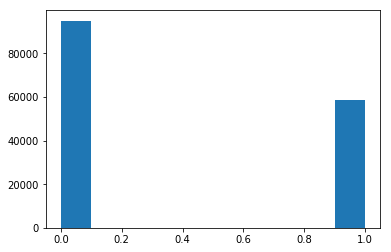

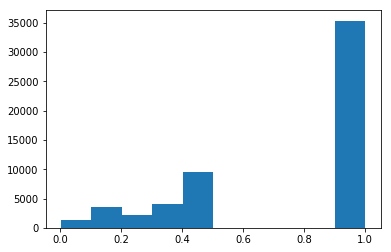

In [15]:
plt.hist(pfz)
plt.show()

plt.hist(probs_list)
plt.show()

In [20]:
    dim = 30
    
    opt = Adam()#lr=0.05)
    
    qn_table = BigTable((len(qids_seen),dim), 0, 1, init_hilo="av")
    s_table =  BigTable((len(uids_across_days), dim), 0, 1, init_hilo="av")

    
    q_wgts_history = []
    s_wgts_history = []

#     s_table =  BigTable((len(userz), 1), 0, 10)
    qs_model = generate_binary_qs_model(qn_table, s_table, opt)
    min_loss = math.inf
    max_acc = 0
    init_patience = 10
    patience = init_patience
    best_q_weights = None
    best_s_weights = None
    
    for _ in range(100000):
        h = qs_model.fit(x=[qz, sz], y=pfz, epochs=1, verbose=1, shuffle=True)
#         print(h.history)
        loss = h.history['loss'][-1]
        mse = h.history['mean_squared_error'][-1]
        acc = h.history['acc'][-1]
#         qs_model.train_on_batch(x=[qz,sz], y=pfz)
#         loss,mse,acc = qs_model.evaluate(x=[qz,sz], y=pfz)
        print(loss, mse, acc)
        if loss <= min_loss or acc > max_acc:
            print("new min loss")
            min_loss = loss
            max_acc = acc
            best_q_weights = qn_table.get_weights()
            best_s_weights = s_table.get_weights()
            patience = init_patience
        else:
            patience -= 1
        q_wgts_history.append( qn_table.get_weights()[0] ) 
        s_wgts_history.append( s_table.get_weights()[0] )
    
        if patience == 0:
#         else:
            print("patience spent")
            break
        print("patience is now {}".format(patience))

        qn_table.set_weights(best_q_weights)
        s_table.set_weights(best_s_weights)
        
        #     ix=0
# #     if last_qn_table:
#     for lw,w in zip(last_qn_table, qn_table.get_weights()[0]):
#         if w != lw:
#             print("{} : {} - {}->{}".format(ix,qids_seen[ix],lw,w))            
#         ix+=1
#     last_qn_table = qn_table.get_weights()[0]

<__main__.BigTable object at 0x7f51da4a6d30> <__main__.BigTable object at 0x7f51da4a6c50> Tensor("psi_select_2:0", shape=(?, 1), dtype=int32) Tensor("q_select_2:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (2673, 30)
selector shape (?, 1)
flat selector shape (?,)
call kk (2673, 30)
'rows' shape, (?, 30)
kk (5164, 30)
selector shape (?, 1)
flat selector shape (?,)
call kk (5164, 30)
'rows' shape, (?, 30)
Pr (?, 1)
Epoch 1/1
153368/153368 [==============================] - 17s 110us/step - loss: 0.9636 - mean_squared_error: 0.3248 - acc: 0.5548
0.963595092046 0.32480839273 0.554815867717
new min loss
patience is now 10
Epoch 1/1
153368/153368 [==============================] - 16s 101us/step - loss: 0.4681 - mean_squared_error: 0.1529 - acc: 0.7776
0.468088218209 0.152911197621 0.777587241142
new min loss
patience is now 10
Epoch 1/1
153368/153368 [==============================] - 14s 94us/step - loss: 0.4226 - mean_squared_error: 0.1351 - acc: 0.8071
0.422596102323 0.13505094

In [21]:
#Binary embeddings
# D | acc
# 30| .-
# 20| .820
# 10| .-
#  7| .-
#  5| .-
#  1| .-


xs = range(len(q_wgts_history))
ww = qn_table.get_weights()[0].shape[0]

print(len(q_wgts_history))

print(ww)

32
2673


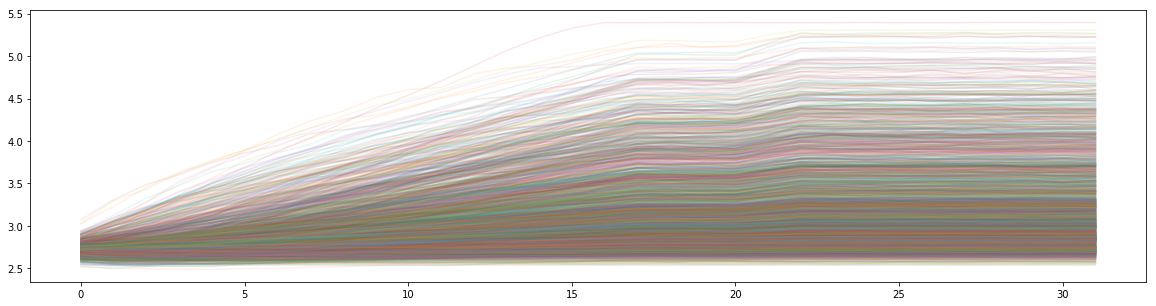

car_suspension_bumps_num|9aefe021-2541-4d66-b840-73b9c5147d3d 2.5384 9
ch_j_p4|9c40e394-2915-4708-a33f-8532a25d53e4 2.54137 12
longest_flight|c2022ed1-c17f-4e4d-adbb-ad9084683c23 2.55193 11
waves_on_a_beach|ea319d58-2c5c-4a8d-9441-13b050b3cfca 2.55339 16
ft_mechanics_core_5|90f8ebe7-8109-4498-9cfa-3224545bc516 2.55849 14
the_lift_num|cd032ee9-1660-49d4-9853-a91a12781b58 2.56569 13
discharging_capacitor|f9acd32d-28fd-4116-b7df-3b0acb07ea79 2.56733 14
two_orbiting_masses|6d5365bd-da02-4064-824d-003fef1613ae 2.56995 11
sand_ridges|78e4a8c9-657a-4daa-afb2-501204c51c37 2.57388 11
two_rods|518730bd-d086-431e-a666-e973d42613dc 2.5757 9
ch_j_p2|40ec167e-3e4a-44c5-a40d-363fcceed032 2.57656 14
build_tennis_court_num|f4165779-90d3-41b7-b935-ac2f60aab3ca 2.58296 12
gravity_earth|9beef47f-285b-458e-bd66-e2816f1db395 2.5833 14
throw_ball_flat|80f04e9a-e396-436f-bf81-aff6329f73e2 2.58545 13
doppler_spectral_lines|5d97915b-eb56-44b6-8588-c99ad4330f00 2.58653 10
basic_electric_field_strength|9826b4dd-9

radical_radiometers|ec85b0f2-ef01-434e-88d0-d498ffb000cb 2.9532 23
int_powers4_multi|7ba6276c-f009-4991-be07-09e12656d89e 2.95441 19
metal_squares|1bfc3d5c-740e-4fee-ab6d-38c225eec01b 2.95469 24
waves_at_sea|cba209c2-f54e-4e5f-94db-70f2ff1f986b 2.95474 21
harbour_entrance_num|1ce03da9-9e23-4be6-bc8c-dcf4d564b510 2.9549 25
sumsdiffs2_multi|2644d5b1-7169-4b11-b673-f35d78b12664 2.95492 26
ch_j_p2|b39522b8-1c4a-499b-942a-20bda8efda1b 2.95562 22
a6_part_frac_sym|ba3e7b5e-47d8-4563-89b8-8eb185f3d731 2.95569 21
ch_d_p7|8673bf83-4ee1-4d8d-b2a3-1c9865e46355 2.9558 22
heating_an_electric_fire|90f541a9-f76c-4fc9-bc90-9f6ec59f96b9 2.95711 23
microscopic_current|45e98243-cdf6-476c-86a7-020acc06f58d 2.95787 21
body_capacitance|fd30a59b-5480-4b8f-bdc9-e4f8e72a615f 2.95804 21
hammer_nail|2d7ba28a-750b-4a23-9d55-0bff18eeb53e 2.95886 22
x_ray_crystallography|9dddc687-7e55-4bf0-860f-dccbc6ddf0e9 2.95946 23
ch_g_p4|c30d0b9d-97f1-4a02-b951-1a79b611a347 2.96084 25
accelerating_voltage_diff|e3c2f58f-da4a-4e0

fc3_transformation_of_func|ca4b9ac2-61b4-4e94-97bc-8ef658096332fc32 3.3139 22
fc2_transformation_of_func|ca4b9ac2-61b4-4e94-97bc-8ef658096331 3.31419 25
fc3_transformation_of_func|ca4b9ac2-61b4-4e94-97bc-8ef658096332fc317 3.31468 26
ch_f_p3|dfabb2a7-6c97-4bad-bed4-5768e20eacc1 3.31633 24
ch_i_p2|8432a632-fd4e-4104-9b75-57b266c6adcc 3.31637 27
ch_h_p3|636108f2-0e57-41a1-a595-9943be73e388 3.31673 27
ch_d_p4|57c6843f-6d45-4d24-8517-7691d8ca0dde 3.31674 26
powers_cr1_multi|d1efd939-7dc1-4f4d-804b-28ad5ce1cafb 3.31785 30
a2_quad_eqns|ca5d902a-7abc-4fdf-8e1f-10a0db742912 3.31812 28
ch_g_p2|688d6587-5d05-4d01-b5af-a5f68ee0e5e4 3.31913 26
stopping_distances_num|a27a0ca8-f708-4d03-b119-cedd4fe4ea13 3.31997 28
ch_e_p4|7214a6f4-21f0-4c46-8f4b-df1449f496ea 3.32003 24
vectors1_college_courtyard|dc991b1b-4ad5-48f5-96be-b73c9ffa81e6 3.32215 28
ch_g_p4|adce9bf6-5a4b-494b-8ff0-340e12ae1742 3.32332 28
ch_h_p4|c4c372c3-d26c-4182-8013-de4e332d55aa 3.32518 26
ch_e_p1|a1cb8664-18d8-4639-8d9e-9ce509406205 3.

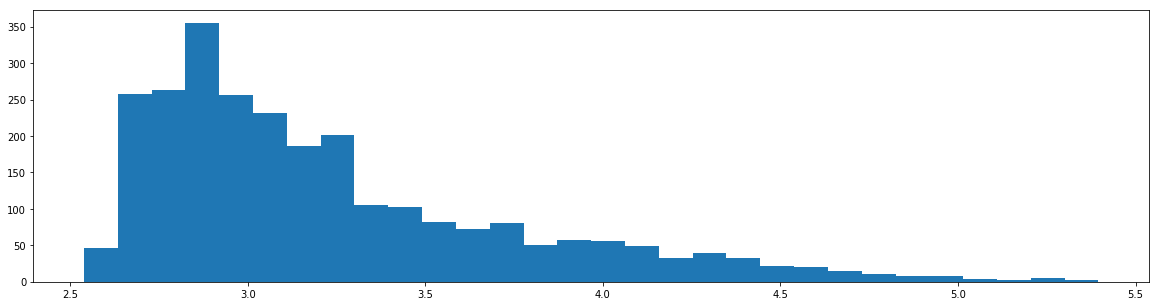

In [22]:
q_pairs = []
q_book_tups = []
for wix in range(ww):
#     if not (qids_seen[wix].startswith("ch_") or qids_seen[wix].startswith("ch-")):
#         continue
    mags = []
    ncs = []
    for hix in xs:
        wgts = q_wgts_history[hix][wix]
        mag = numpy.linalg.norm(wgts) # calculate the Frobinius norm
        n_comps = numpy.sum(wgts > 0.5)
        mags.append(mag)
    if mags[0] != mags[-1]:
        q_pairs.append((qids_seen[wix], mag, n_comps))
        if (qids_seen[wix].startswith("ch_") or qids_seen[wix].startswith("ch-")):
            q_book_tups.append((qids_seen[wix],mag, wgts, n_comps))
        plt.plot(xs,mags, alpha=0.1)
plt.gcf().set_size_inches(20,5)
plt.show()

q_pairs.sort(key=lambda x: x[1])
hist_data = []
for p in q_pairs:
    hist_data.append(p[1])

for p in q_pairs:#[0:100]:
    print(p[0], p[1], p[2])
print("...")
# for p in q_pairs[-100:]:
#     print(p[0], p[1], p[2])

numpy.savetxt("./{}d_all_qs.csv".format(dim), q_pairs , fmt="%s", delimiter=",")
bookpairs=[(p[0],p[1]) for p in q_book_tups]
bookpairs.sort(key=lambda x: x[1])
numpy.savetxt("./{}d_book_qs.csv".format(dim), bookpairs , fmt="%s", delimiter=",")

plt.hist(hist_data, bins=30)
plt.gcf().set_size_inches(20,5)
plt.show()
    

[[ 0.37385377  0.44238815  0.43463838 ...,  0.4257991   0.40270779
   0.41525215]
 [ 0.45828956  0.44144347  0.53123283 ...,  0.51504201  0.51446176
   0.48420453]
 [ 0.53461593  0.53804886  0.58614987 ...,  0.58864039  0.50080818
   0.58211654]
 ..., 
 [ 0.38276082  0.34901351  0.42066166 ...,  0.35958812  0.35305199
   0.39075148]
 [ 0.40422934  0.4556298   0.43553576 ...,  0.40487197  0.38008162
   0.48182681]
 [ 0.49276772  0.50786942  0.50652283 ...,  0.47359312  0.4986043
   0.48677316]]
5293


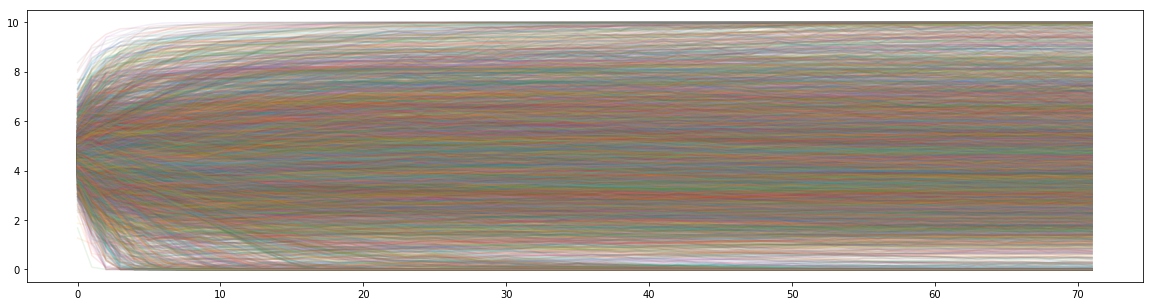

10000_2015-09-17 5.66299 37
10000_2015-09-28 5.20678 31
10000_2015-10-03 7.42011 62
10000_2015-10-04 8.13465 90
10000_2015-10-07 8.63397 100
10000_2015-10-08 6.9263 66
10006_2015-09-17 4.86052 25
10006_2015-09-19 4.54489 30
10006_2015-09-24 10.0 100
10006_2015-09-25 5.12235 30
10006_2015-09-29 2.25913 5
10006_2015-09-30 5.80833 36
10006_2015-10-01 7.11811 73
10006_2015-10-13 0.0 0
10006_2015-10-14 5.13151 30
10006_2015-10-15 4.35497 27
10006_2015-11-24 0.0 0
10006_2015-11-26 5.1888 39
10023_2015-09-17 5.24769 32
10036_2015-09-17 8.92297 100
10095_2016-06-09 2.32702 6
10099_2015-09-17 1.1582 3
10099_2015-09-19 8.56635 100
10099_2015-12-07 5.1591 43
10099_2016-02-03 3.82808 22
10099_2016-03-04 5.01722 34
10099_2016-03-21 7.57874 73
10099_2016-05-12 2.13638 4
10130_2015-09-20 5.26766 34
10130_2015-09-21 8.53258 100
10130_2015-09-23 4.35847 29
10130_2015-09-24 2.66449 11
10147_2015-09-18 6.35581 94
10147_2015-09-22 8.58058 87
10147_2015-12-27 7.10807 77
10176_2015-09-18 4.37931 21
10176_20

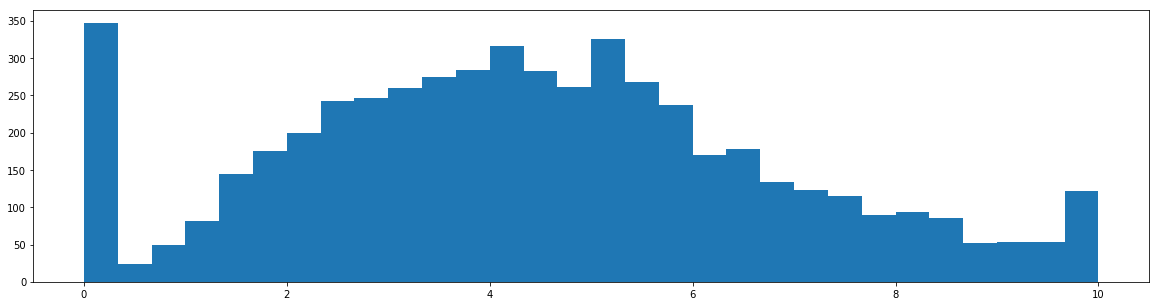

7 5286


In [18]:
from random import shuffle

# swgts = s_table.get_weights()[0]
# print("student range:", min(swgts), max(swgts))

uids_across_days = list(uids_across_days)
# uids_across_days = sorted(uids_across_days)

# print(uids_across_days)
# for u in uids_across_days[0:100]:
#     print(u)

xs = range(len(s_wgts_history))
# ww = s_wgts_history[0][0]
print(s_wgts_history[0])

u_pairs = []
unchanged = set()

ww_choices = numpy.random.choice(uids_across_days, size=min(len(uids_across_days),20000), replace=False)
# ww_choices = uids_across_days
print(len(ww_choices))
for uid in ww_choices:
    uix = uids_across_days.index(uid)
    mags = []
    for hix in xs:
        wgts = s_wgts_history[hix][uix]
        mag = numpy.linalg.norm(wgts) # calculate the Frobinius norm
        n_comps = numpy.sum(wgts > 0.5)
        mags.append(mag)
    if mags[0] == mags[-1]:
        unchanged.add(uid)
    else:
        u_pairs.append((uid, mag, n_comps))
        plt.plot(xs,mags, alpha=0.1)
plt.gcf().set_size_inches(20,5)
plt.show()

# u_pairs.sort(key=lambda x: x[1][0])
# hist_data = []
# for p in u_pairs:
#     print(p[0], p[1][-1])
#     hist_data.append(p[1][-1])

for p in sorted(u_pairs)[0:100]:
    print(p[0], p[1], p[2])
print("--")
for p in sorted(u_pairs)[-100:]:
    print(p[0], p[1], p[2])

hist_data = []
for p in u_pairs:
    hist_data.append(p[1])

# print("...")
# for el in unchanged:
#     print(el)
    
plt.hist(hist_data, bins=30)
plt.gcf().set_size_inches(20,5)
plt.show()

print(len(unchanged), len(u_pairs))

[298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497,

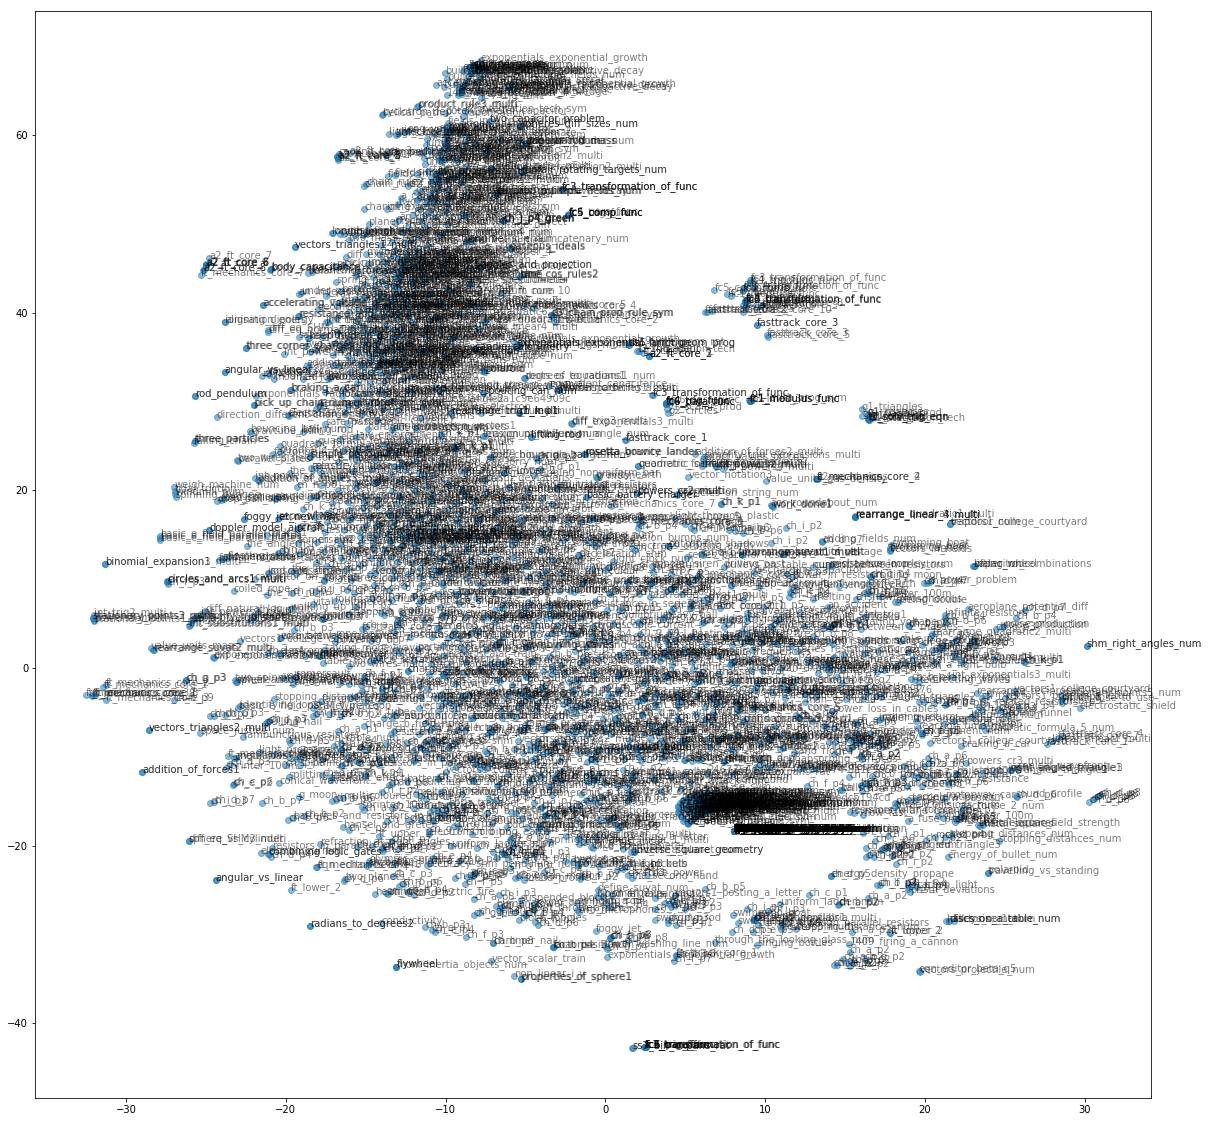

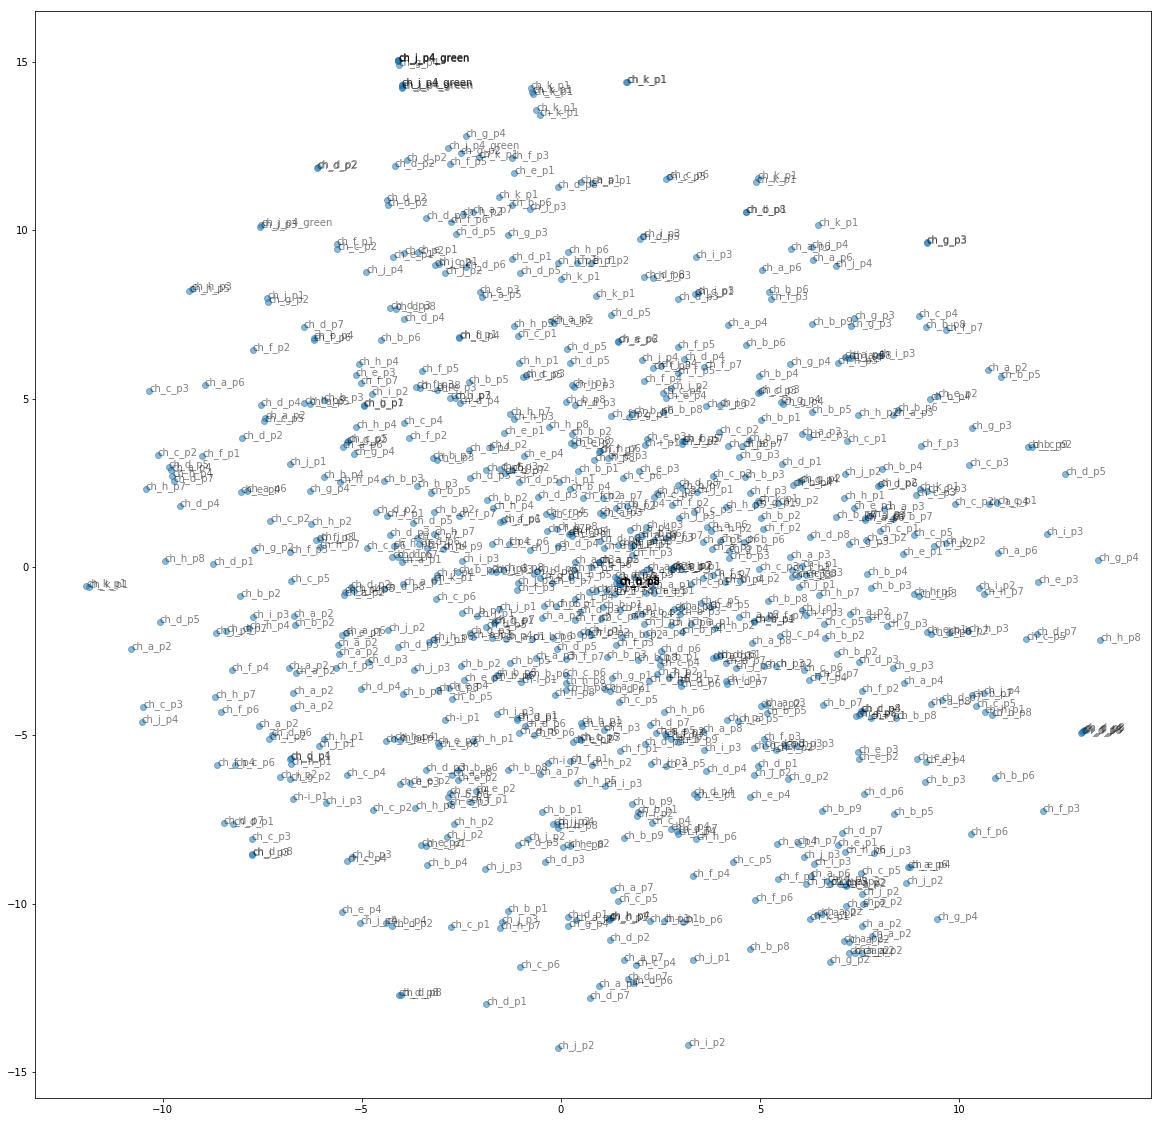

In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
indices = [qids_seen.index(tup[0]) for tup in q_book_tups]
print(indices)

mutate = TSNE(n_components=2)
warr = numpy.array([qn_table.get_weights()[0][qids_seen.index(qid)] for qid in [tup[0] for tup in q_pairs]])

data_flat = mutate.fit_transform(warr)
# data_flat = warr

# plt.scatter(x=[tvp[2][0] for tvp in q_book_tups], y=[tvp[2][1] for tvp in q_book_tups])
plt.scatter(x=data_flat[:,0], y=data_flat[:,1], alpha=0.5)

for ix,tup in enumerate(q_pairs):
#     qix = qids_seen.index(tup[0])
    L = tup[0].split("|")[0]
    plt.annotate(L, (data_flat[ix,0], data_flat[ix,1]), alpha=0.5 )
plt.gcf().set_size_inches(20,20)
plt.show()


warr = numpy.array([tup[2] for tup in q_book_tups])
data_flat = mutate.fit_transform(warr)
# data_flat = warr
# plt.scatter(x=[tvp[2][0] for tvp in q_book_tups], y=[tvp[2][1] for tvp in q_book_tups])
plt.scatter(x=data_flat[:,0], y=data_flat[:,1], alpha=0.5)

for ix,tup in enumerate(q_book_tups):
#     qix = qids_seen.index(tup[0])
    L = tup[0].split("|")[0]
    plt.annotate(L, (data_flat[ix,0], data_flat[ix,1]), alpha=0.5 )
plt.gcf().set_size_inches(20,20)
plt.show()

In [ ]:
for ix,q in enumerate(qn_table.get_weights()[0]):
    print(ix, qids_seen[ix], q)

In [ ]:
for ix,s in enumerate(s_table.get_weights()[0]):
    print(ix, uids_across_days[ix], s)

In [ ]:
plot_w = 6
plot_h = (1+len(d_hist_data)//plot_w)

# fig, axes = plt.subplots(nrows=(len(d_hist_data)), ncols=1)            
plt.gcf().set_size_inches(3*plot_w,3*plot_h)
for ax_i, d in enumerate(d_hist_data):
    data = d_hist_data[d]
    print(d, len(data))
#     print(min(data), max(data))
#     print(data)
    subplot = plt.subplot(plot_h, plot_w, ax_i+1)
    subplot.hist(data)
plt.show()

print(len(d_hist_data), "days of activity")
print(len(qids_seen), "qids")
print(len(uids_seen), "uids")
print(len(book_qids), "book qids")
print(book_qids)
            
#         for item in attz4date[attz4date["question_id"]==qid].loc[["user_id", "correct"]]:
#             print("\t",item)
        

In [ ]:
print(passes)
plt.hist(passes)
plt.show()

In [ ]:
# assignments.loc[:, "creation_date"] = pandas.to_datetime(assignments["creation_date"]).dt.floor("D")
# pid_override = set()
# for h in ass_summ["hexes"]: # go through all hexes ever assigned...
#     pid_override.update(eval(h))
# pid_override = sorted(list(pid_override))

LOAD_PQIDS=True

if LOAD_PQIDS:
    pid_override = joblib.load(base+"pid_override.pkl")
    all_qids = joblib.load(base+"all_qids.pkl")
    print("loaded pqids....")

else:
    pid_override = set()
    qids_in_play = set()
    ss = set()
    for aix in ass_summ.index:
        ss.update(eval(ass_summ.loc[aix,"students"]))
        # hxz = [h for h in eval(ass_summ.loc[aix,"hexes"]) if (h.startswith("ch_") or h.startswith("ch-i"))]
        # ass_summ.loc[aix, "hexes"] = str(hxz)

    for s in ss:
        attz = get_attempts_from_db(s)
        qids_in_play.update([q for q in list(attz["question_id"])])# if (q.startswith("ch_") or q.startswith("ch-i"))] )
        pid_override.update([s.split("|")[0].replace("-","_") for s in list(attz["question_id"]) if (s.startswith("ch_") or s.startswith("ch-i"))])
    all_qids = sorted(qids_in_play)
    pid_override = sorted(pid_override)
    all_page_ids = pid_override

    print(all_qids)
    print("Qids in play len", len(all_qids))

    print(pid_override)
    print("Pids in play len", len(pid_override))
    joblib.dump(all_qids, base+"all_qids.pkl")
    joblib.dump(pid_override, base+"pid_override.pkl")
    
all_page_ids = list(set([ s.split("|")[0] for s in all_qids ]))
print(all_page_ids)
print(len(all_page_ids))

In [ ]:
import copy
from hwgen.common import get_user_data
start_dates = {}
ss = set()
first_assign = {}
min_ts = None
max_ts = None
for aix in ass_summ.index:
    ts, grid, students = ass_summ.loc[aix,["creation_date","group_id","students"]]
    
    if (not min_ts) or ts < min_ts:
        min_ts = ts
    if (not max_ts) or ts > max_ts:
        max_ts = ts
    
    students = eval(students) # convert str rep to list
    ss.update(students)
    for s in students:
        if s not in first_assign:
            first_assign[s] = copy.copy(ts)
psi_df = get_user_data(list(ss))
for ix in psi_df.index:
    psi, rd = psi_df.loc[ix, ["id","registration_date"]]
    if psi not in start_dates:
        ts = first_assign[psi]
        reg_date = pandas.Timestamp(psi_df.loc[psi_df["id"]==psi,"registration_date"].values[0])
        start_dates[psi] = (ts, reg_date)

for s in start_dates:
    print(s, start_dates[s])

print(min_ts, max_ts)

In [ ]:
BUILD_SXUA = False
# print(ass_summ[0:10])
numpy.set_printoptions(precision=1, suppress=True)
if BUILD_SXUA:
    print("getting start dates")
#     try:
#         start_dates = joblib.load(base + "start_dates.pkl")
#         print("loaded")
#     except:
#         start_dates = build_start_dates(ass_summ)
    if True:
        joblib.dump(start_dates, base+"start_dates.pkl")
        print("built")
    ass_summ = ass_summ[ass_summ["has_book_hexes"] == True]  # discard activity that has nowt to do with the book
#     for psi in list(start_dates.keys())[0:10]:
#         print(psi, start_dates[psi])
    print("building SXUA")
    SXUA = build_SXUA(base, ass_summ, all_qids, pid_override=pid_override, start_dates=start_dates)
    f = open(base + "SXUA.comp.pkl", 'wb')
    pickle.dump(SXUA, f)
    f.close()
    print("compressed and SAVED")
else:
    print("loading SXUA")
    f = open(base + "SXUA.comp.pkl", 'rb')
    SXUA = pickle.load(f)
    print("SXUA loaded with {} entries", len(SXUA))
    f.close()

In [ ]:
print(len(SXUA))
for k in SXUA:
#     print(k)
    tss = SXUA[k]
    print("{}: ({} {}), {} ".format(k, min(tss), max(tss), len(tss)))

In [ ]:
# ass_summ = ass_summ[0:8000]
ass_summ = ass_summ[ass_summ["has_book_hexes"]==True] # discard activity that has nowt to do with the book
# ass_summ = ass_summ[ass_summ["num_hexes"]==1] # discard activity that has nowt to do with the book
print("ass summ pre filtered, shape {}".format(ass_summ.shape))
ass_summ = ass_summ[ass_summ["include"]==True]
print("ass summ post filtered, shape {}".format(ass_summ.shape))

tss = ass_summ.loc[:,"creation_date"]
print(numpy.min(tss), numpy.max(tss))

In [ ]:
# import zlib
# numpy.set_printoptions(precision=1, suppress=True)

# for ix in ass_summ.index[0:100]:
#     aid,stz,ts = ass_summ.loc[ix,["id","students","creation_date"]]
#     stz = eval(stz)
#     print("----Aid =",aid)
#     for psi in stz:
#         psi_sxua = SXUA[psi]
# #         for ts in psi_sxua:
#         S,X,U,A = pickle.loads(zlib.decompress(psi_sxua[ts]))
#         print(aid,psi,ts,S)

In [ ]:
numpy.set_printoptions(precision=4, suppress=True)
aug = augment_data(ass_summ, SXUA, pid_override, filter=True)
aid_list, s_list, x_list, u_list, a_list, y_list, psi_list, hexes_to_try_list, hexes_tried_list, _, gr_id_list, ts_list, maxdops = aug

In [ ]:
# import sys
# i=0
# for aid, psi, sl,xl,ul,al,hxtt,hxtd in zip(aid_list, psi_list, s_list,x_list,u_list,a_list,hexes_to_try_list, hexes_tried_list):
#     print(psi,":",aid,":",sl)
# #     print([x for x in xl])
#     print("...",sum(xl), numpy.nonzero(xl))
#     print([all_qids[ix] for ix in numpy.nonzero(xl)[0]])
#     i += 1
#     if i == 1000:
#         break
# #     print(xl)
# #     print(y_list)

In [ ]:
COUNT_TEACHERS=False
if COUNT_TEACHERS:
    t_test = None
    t_train = None
    ct = Counter()
    for t in numpy.unique(ass_summ["owner_user_id"]):
        t_assignments = ass_summ[ass_summ["owner_user_id"] == t]
        ct[t] = ass_summ.shape[0]
    print(ct.most_common(20))
    print("teachers counted")

    assct = 0
    teacherct = 0
    kept_ts = []
    for (t, tct) in list(ct.most_common(len(ct))):
        t_assignments = ass_summ[ass_summ["owner_user_id"] == t]
        this_t_assts = t_assignments.shape[0]
        if this_t_assts < 5:
            print("not enough assignments",t,tct,this_t_assts)
        else:
            teacherct += 1
            kept_ts.append((t,ct[t]))
    print(teacherct, assct)

    teacherN = teacherct
    test_insts = 0
    target_test = 6000 #teacherN // 10

    t_test = []
    t_train = []
    put_in_test_set = False
    n_train = 0
    n_test = 0
    for (t, tct) in kept_ts:
        num_students = 0
        t_assignments = ass_summ[ass_summ["owner_user_id"] == t]
        print(t,":",t_assignments.shape[0], "new training assts")

        if put_in_test_set and n_test<target_test:
            # test_insts += 1
            print("TEST>>")
            aug = augment_data(t_assignments, SXUA, pid_override=pid_override, filter=True)
            num_students = len(aug[0])
            n_test += num_students
            if len(t_test) == 0:
                t_test = t_assignments
            else:
                t_test = pandas.concat([t_test, t_assignments])
            put_in_test_set = False
        else:
            print("TRAIN>>")
            aug = augment_data(t_assignments, SXUA, pid_override=pid_override, filter=False)
            num_students = len(aug[0])
            n_train += num_students
            if len(t_train) == 0:
                t_train = t_assignments
            else:
                t_train = pandas.concat([t_train, t_assignments])
            put_in_test_set = True

        if n_train >= 50000:
            break

    tr = t_train
    tt = t_test
    print("numbers of (student,asst) pairs:", n_train, n_test)
    tr.to_csv(base + "tr_ttb.csv")
    tt.to_csv(base + "tt_ttb.csv")
else:
    tr = pandas.read_csv(base + "tr_ttb.csv")
    tt = pandas.read_csv(base + "tt_ttb.csv")

print("len t_train, t_test",len(tr), len(tt))
ass_summ = pandas.concat([tr,tt])
print("Split complete!")
print("{} {}".format(len(tt), len(tr)))

In [ ]:
do_x_val = True
xrmses = []
xaccs = []
if do_x_val:
    n_folds = 10
    start_indices = [len(tr)*x//n_folds for x in range(n_folds)]
    print(start_indices)
    fold_size = len(tr)//n_folds
    for start_target in start_indices:
        ttx = tr[start_target:(start_target+fold_size)]        
        trx = tr.drop(tr.index[range(start_target,start_target+fold_size)])
        aug_trx = augment_data(trx, SXUA, pid_override=pid_override, all_qids=all_qids, all_page_ids=all_page_ids, filter=False)
        modelx = train_deep_model(aug_trx)
        aug_ttx = augment_data(ttx, SXUA, pid_override=pid_override, all_qids=all_qids, all_page_ids=all_page_ids, filter=False)
        (rmse,acc) = evaluate3(aug_ttx, modelx, pid_override)
        xrmses.append(rmse)
        xaccs.append(acc)
        

In [ ]:
print(xrmses)
print(xaccs)
print(numpy.mean(xrmses))
print(numpy.mean(xaccs))

In [ ]:
    model = train_deep_model(aug)
    print("...deleted original X,y")
    model.save(base + 'hwg_model.hd5')
    # joblib.dump(xmask, base + 'hwg_xmask.pkl')
    # joblib.dump(sc, base + 'hwg_mlb.pkl')
    # joblib.dump((sscaler,levscaler,volscaler), base + 'hwg_scaler.pkl')
    print("saved model and exit")